In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/antoine/miniconda3/envs/kipoi-gpu-DeepSEA__predict/bin/python
3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)


In [2]:
import glob
import re
import os
import sys
import kipoi
import numpy as np
import datetime
import warnings
import pandas as pd
import matplotlib.pyplot as plt
start = datetime.datetime.now()

old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")
model = kipoi.get_model('DeepSEA/predict')
sys.stdout = old_stdout
batch_size=100
#sys.argv=[" ","5_158526788",5000,"gene_name",1,100,500000]
#for all positions
sys.argv=[" ","2_127864931",5000,"BIN1",1,100,500000]
#for interesting positions
#sys.argv=[" ","2_127864931",931,"BIN1",1,100,500000,20,"some_genes_32_Tissue-specific_regulatory_networks_FANTOM5-v1"]
sys.argv[2]=int(sys.argv[2])
sys.argv[4]=int(sys.argv[4])
sys.argv[5]=int(sys.argv[5])
sys.argv[6]=int(sys.argv[6])
#print(sys.argv[1])
with open("temp/"+sys.argv[1]+"/expression/"+sys.argv[1]+".tsv") as f:
    content = f.readlines()

content = [x.strip() for x in content]
content[0] = content[0].split()
content[1] = content[1].split()
#for all positions
#dfexpr = pd.read_csv("expression_"+sys.argv[8]+".tsv", sep="\t",header = 0)

answ=np.empty([sys.argv[2],445,919])
#for all positions
expr=np.empty([445])
#for interesting positions
#expr=np.empty([dfexpr.shape[0],445])
i=0


In [ ]:
for g in sorted(glob.glob("temp/"+sys.argv[1]+"/fa_output/out"+sys.argv[1]+"_*.fa.gz")):
    dl_kwargs = {'intervals_file': 'temp/'+sys.argv[1]+'/intervals/'+os.path.splitext(os.path.basename(g))[0], 'fasta_file': g, "num_chr_fasta": "False"}
    warnings.filterwarnings('ignore',category=FutureWarning)
    dl = model.default_dataloader(**dl_kwargs)
    #it = dl.batch_iter(batch_size=sys.argv[2])
    it = dl.batch_iter(batch_size=batch_size)
    for b in range(0,sys.argv[2],batch_size):
        batch = next(it)
        warnings.filterwarnings('default',category=FutureWarning)
        if (sys.argv[2]<=b+batch_size):
            answ[b:sys.argv[2],i,:]=model.predict_on_batch(batch['inputs'])
        else:
            answ[b:b+batch_size,i,:]=model.predict_on_batch(batch['inputs'])
    expr[:,i]=dfexpr[(re.split('_|\.',g)[-3])]
    i+=1

In [3]:
for g in sorted(glob.glob("temp/"+sys.argv[1]+"/fa_output/out"+sys.argv[1]+"_*.fa.gz")):
    dl_kwargs = {'intervals_file': 'temp/'+sys.argv[1]+'/intervals/'+os.path.splitext(os.path.basename(g))[0], 'fasta_file': g, "num_chr_fasta": "False"}
    warnings.filterwarnings('ignore',category=FutureWarning)
    dl = model.default_dataloader(**dl_kwargs)
    #it = dl.batch_iter(batch_size=sys.argv[2])
    it = dl.batch_iter(batch_size=batch_size)
    for b in range(0,sys.argv[2],batch_size):
        batch = next(it)
        warnings.filterwarnings('default',category=FutureWarning)
        if (sys.argv[2]<=b+batch_size):
            answ[b:sys.argv[2],i,:]=model.predict_on_batch(batch['inputs'])
        else:
            answ[b:b+batch_size,i,:]=model.predict_on_batch(batch['inputs'])
    expr[i]=content[1][content[0].index(re.split('_|\\.',g)[-3])]
    i+=1

Without normalisation

In [4]:
correlations_original=np.empty([919,sys.argv[2]])
for i in range(sys.argv[2]):
    correlations_original[:,i]=np.corrcoef(np.transpose(answ[i,:,:]),expr)[-1][:-1]

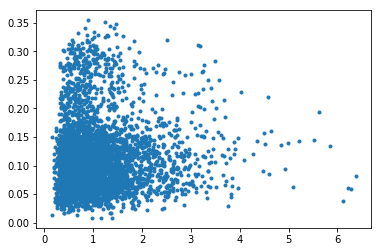

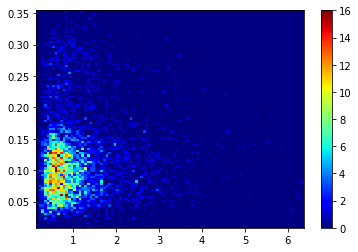

In [23]:
x1=np.log(np.max(np.max(answ, axis=1)/np.min(answ, axis=1),axis=1))
y1=np.max(correlations_original,axis=0)
plt.plot(x1,y1,".")
plt.show()
plt.hist2d(x1, y1, (100, 100), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [15]:
nbr_points1=np.zeros([2,2])
nbr_points1[0,0]=sum(np.logical_and(y1>0.15,x1<2))
nbr_points1[0,1]=sum(np.logical_and(y1>0.15,x1>2))
nbr_points1[1,0]=sum(np.logical_and(y1<0.15,x1<2))
nbr_points1[1,1]=sum(np.logical_and(y1<0.15,x1>2))
print(nbr_points1)

[[ 766.   94.]
 [3838.  302.]]


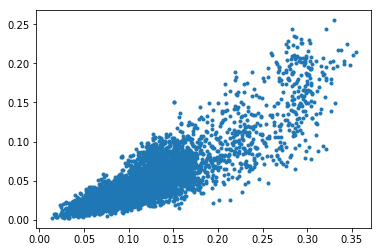

In [12]:
plt.plot((np.max(np.abs(correlations_original), axis=0)), np.mean(np.abs(correlations_original), axis=0), ".")

With normalisation

In [6]:
from sklearn.preprocessing import quantile_transform
expr=quantile_transform(expr.reshape(-1,1), output_distribution="normal", copy=True)[:,0]

In [7]:
correlations_normalized=np.empty([919,sys.argv[2]])
for i in range(sys.argv[2]):
    correlations_normalized[:,i]=np.corrcoef(np.transpose(quantile_transform(answ[i,:,:], output_distribution="normal", copy=True)),expr)[-1][:-1]

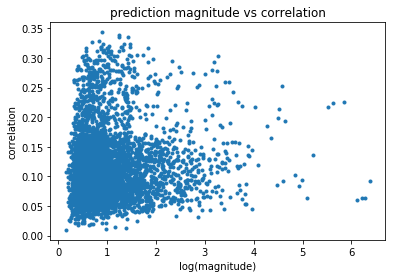

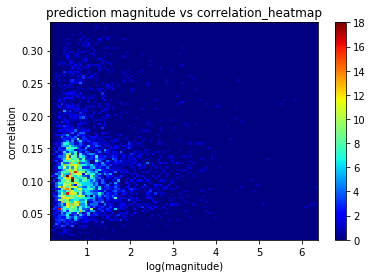

In [29]:
x2=np.log(np.max(np.max(answ, axis=1)/np.min(answ, axis=1),axis=1))
y2=np.max(correlations_normalized,axis=0)
plt.plot(x2,y2,".")
plt.title("prediction magnitude vs correlation")
plt.xlabel("log(magnitude)")
plt.ylabel("correlation")
plt.show()
plt.hist2d(x2, y2, (100, 100), cmap=plt.cm.jet)
plt.colorbar()
plt.title("prediction magnitude vs correlation heatmap")
plt.xlabel("log(magnitude)")
plt.ylabel("correlation")
plt.show()

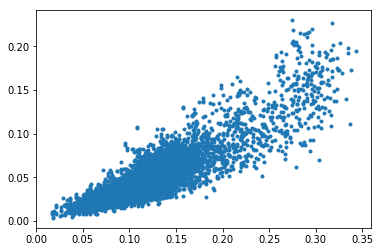

In [13]:
plt.plot((np.max(np.abs(correlations_normalized), axis=0)), np.mean(np.abs(correlations_normalized), axis=0), ".")

In [17]:
nbr_points2=np.zeros([2,2])
nbr_points2[0,0]=sum(np.logical_and(y2>0.18,x2<2))
nbr_points2[0,1]=sum(np.logical_and(y2>0.18,x2>2))
nbr_points2[1,0]=sum(np.logical_and(y2<0.18,x2<2))
nbr_points2[1,1]=sum(np.logical_and(y2<0.18,x2>2))
print(nbr_points2)

[[ 482.   58.]
 [4122.  338.]]


In [17]:
np.argmax(np.max(np.max(answ, axis=1)/np.min(answ, axis=1),axis=1))

1620

In [25]:
np.argmax(np.max(answ[1620,:,:],axis=0)/np.min(answ[1620,:,:],axis=0))

684

In [27]:
(np.max(answ[1620,:,684])/np.min(answ[1620,:,684]))

590.6549275600356

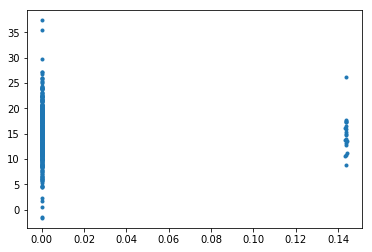

In [30]:
plt.plot(answ[1620,:,684], expr,".")
#plt.plot(answ[position_i,:,mark_i] , expr[1],'.')


In [36]:
np.mean(expr[answ[1620,:,684]<0.1])

15.288214720207327

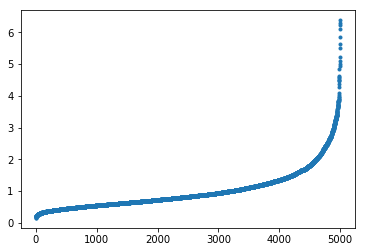

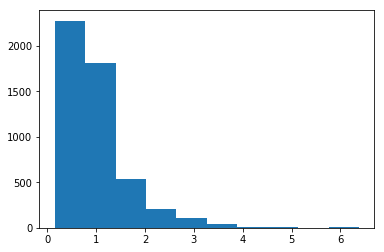

In [44]:
stats=np.max(np.max(answ, axis=1)/np.min(answ, axis=1),axis=1)
#stats=(np.max(answ, axis=1)/np.min(answ, axis=1)).flatten()
plt.plot(np.log(np.sort(stats)),".")
plt.show()
plt.hist(np.log(np.sort(stats)))
plt.show()

In [45]:
start_cor = datetime.datetime.now()
gene_info = pd.read_csv("gene_info_"+sys.argv[8]+".txt", sep="\t",header = 0,index_col=0)
column_names = list(pd.read_csv("correlations_small/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz",header = 0))
with open('deepsea_postprocessing/predictor.names') as f:
    row_names = f.read().splitlines()
correlations_original=np.empty([919,sys.argv[2]])
for i in range(sys.argv[2]):
    correlations_original[:,i]=np.corrcoef(np.transpose(answ[i,:,:]),expr)[-1][:-1]

IndexError: list index out of range

In [ ]:
gene_n=0

for gene in dfexpr["TargetID"]:
    print(gene_n)
    gene=gene.split(".")[0]
    #create empty correlation file
    correlations=np.empty([919,sys.argv[2]])
    #ignore warnings when std == 0
    np.seterr(divide='ignore', invalid='ignore')
    #compute all the correlations
    for i in range(sys.argv[2]):
        print(i)
        correlations[:,i]=np.corrcoef(np.transpose(answ[i,:,:]),expr[gene_n])[-1][:-1]
    np.seterr(divide='warn', invalid='warn')
    #print(i)
    #convert np_array to pd DataFrame to add column and row names and then save correlations to .csv.gz
    df = pd.DataFrame(correlations, columns=column_names, index=row_names)
    #df.to_csv("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+"/"+gene_info.loc[gene][4]+".csv.gz")
    """with open("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+"/"+gene_info.loc[gene][4]+".csv.gz.info","w+") as f:
        sign_cutoff=0.1550258
        f.write(str(df.abs().max().max())+"\n"+str(np.sum(((df.abs())>sign_cutoff).values)))"""
    gene_n+=1


In [14]:
#for all positions
#column_names = np.arange(sys.argv[4],sys.argv[6],sys.argv[5])-1-sys.argv[6]/2
#for interesting positions
column_names = pd.read_csv("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+"/BIN1.csv.gz", index_col=0, header=0).columns
with open('deepsea_postprocessing/predictor.names') as f:
    row_names = f.read().splitlines()
df = pd.DataFrame(correlations, columns=column_names, index=row_names)
"""df.to_csv("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz")

#np.savetxt("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv", correlations, delimiter=",")

test_time = open("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".time", 'w')
test_time.write(str(start)+"\n"+str(start_cor)+"\n"+str(datetime.datetime.now()))
test_time.close()"""

'df.to_csv("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv.gz")\n\n#np.savetxt("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".csv", correlations, delimiter=",")\n\ntest_time = open("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+".time", \'w\')\ntest_time.write(str(start)+"\n"+str(start_cor)+"\n"+str(datetime.datetime.now()))\ntest_time.close()'

# To plot correlation for one point for one gene

In [21]:
df= pd.read_csv("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+"/BIN1.csv.gz", header=0, index_col=0)

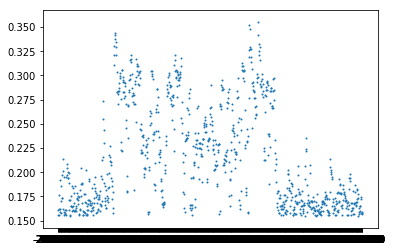

In [22]:
import matplotlib.pyplot as plt
df=df.fillna(0)
#print(list(df.abs().max().sort_values().iloc[-50:].index))
#print(df.abs().idxmax())
#df.abs().max().plot()
#plt.show()
plt.scatter(df.abs().max().index, df.abs().max(),s=1)
plt.show()

In [23]:
pos=df.abs().max().sort_values().iloc[-50:]
#df[list(pos.index)].abs().mean(axis=1).sort_values()

In [24]:
#get list of best positions
pos=df.abs().max().sort_values().iloc[-50:]
#get list of best mark at these positions
mark=df.abs().idxmax()[list(pos.index)]
import matplotlib.pyplot as plt

In [25]:
position_i=(df.columns.get_loc(list(pos.index)[-15]))
mark_i=(df.index.get_loc(list(mark)[-15]))

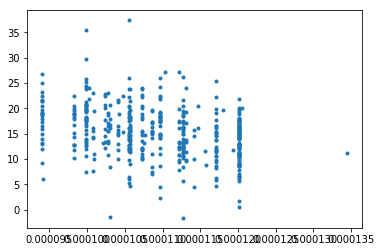

array([[ 1.        , -0.32704178],
       [-0.32704178,  1.        ]])

In [28]:
plt.plot(answ[position_i,:,mark_i] , expr[1],'.')
plt.show()
np.corrcoef(answ[position_i,:,mark_i] , expr[1])
#answ=np.empty([sys.argv[2],445,919])
#expr=np.empty([445])

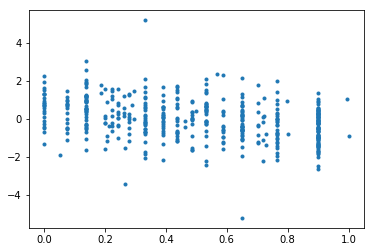

array([[ 1.        , -0.32483741],
       [-0.32483741,  1.        ]])

In [43]:
from sklearn.preprocessing import quantile_transform
X=np.copy(answ[position_i,:,mark_i])
Y=np.copy(expr[1])
X=X.reshape(-1, 1)
Y=Y.reshape(-1, 1)
X=quantile_transform(X, output_distribution="uniform", copy=True)
Y=quantile_transform(Y, output_distribution="normal", copy=True)
plt.plot(X, Y,'.')
plt.show()
np.corrcoef(X.reshape(-1), Y.reshape(-1))

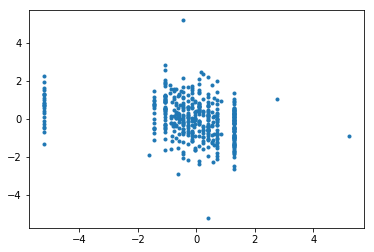

array([[ 1.       , -0.2808633],
       [-0.2808633,  1.       ]])

In [32]:
from sklearn.preprocessing import quantile_transform
X=np.copy(answ[position_i,:,mark_i])
Y=np.copy(expr[1])
X=X.reshape(-1, 1)
Y=Y.reshape(-1, 1)
X=quantile_transform(X, n_quantiles=1000, output_distribution="normal", copy=True)
Y=quantile_transform(Y, n_quantiles=1000, output_distribution="normal", copy=True)
plt.plot(X, Y,'.')
plt.show()
np.corrcoef(X.reshape(-1), Y.reshape(-1))

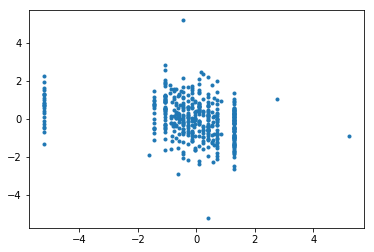

array([[ 1.       , -0.2808633],
       [-0.2808633,  1.       ]])

In [63]:
from sklearn.preprocessing import quantile_transform
X=np.copy(answ[position_i,:,mark_i])
Y=np.copy(expr[1])
X=X.reshape(-1, 1)
Y=Y.reshape(-1, 1)
Z=np.concatenate((X,Y),axis=1)
Z=quantile_transform(Z, n_quantiles=1000, output_distribution="normal", copy=True)
plt.plot(Z[:,0],Z[:,1],'.')
plt.show()
np.corrcoef(Z[:,0],Z[:,1])

In [120]:
rng = np.random.RandomState(0)
X = np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
quantile_transform(X, n_quantiles=10, random_state=0, copy=True)
X.shape
print(sys.argv[1]+"_"+sys.argv[3])

2_127864931_BIN1


HDX


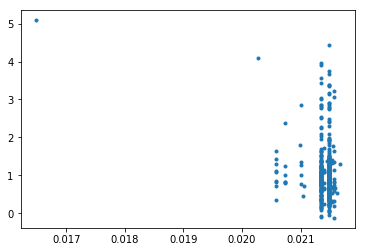

556 840 (445,)
[[ 1.         -0.25563881]
 [-0.25563881  1.        ]]


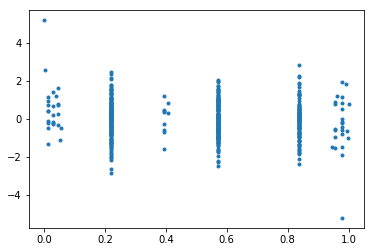

[[ 1.         -0.10416602]
 [-0.10416602  1.        ]]
LHX8
EBF1


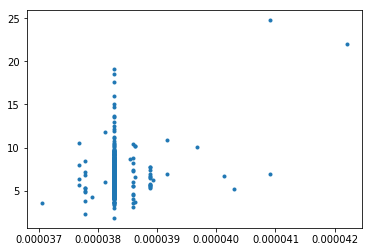

10 541 (445,)
[[1.        0.3137382]
 [0.3137382 1.       ]]


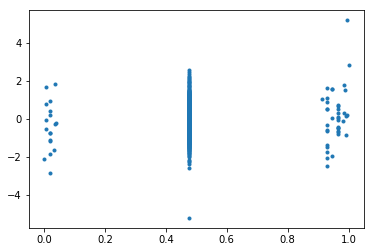

[[1.         0.08903781]
 [0.08903781 1.        ]]
TBX19


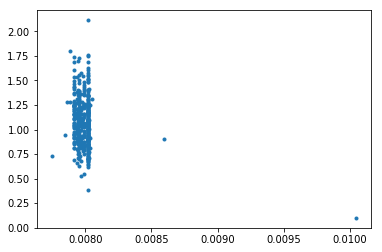

733 304 (445,)
[[ 1.         -0.21780719]
 [-0.21780719  1.        ]]


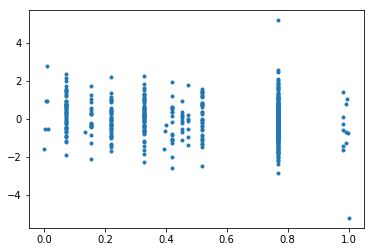

[[ 1.        -0.1333457]
 [-0.1333457  1.       ]]
DUXA
KLF14
ZBTB7B


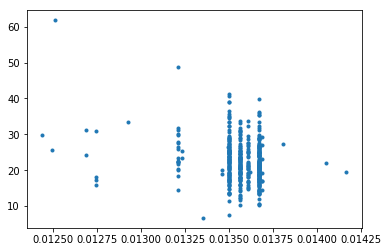

691 711 (445,)
[[ 1.         -0.22133913]
 [-0.22133913  1.        ]]


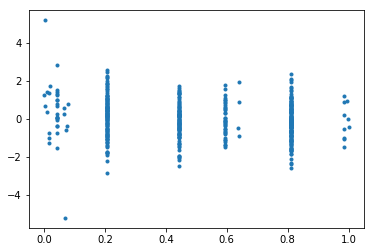

[[ 1.         -0.14977559]
 [-0.14977559  1.        ]]
BACH2


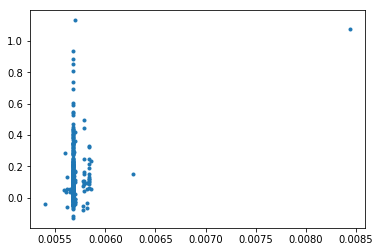

10 618 (445,)
[[1.         0.28399937]
 [0.28399937 1.        ]]


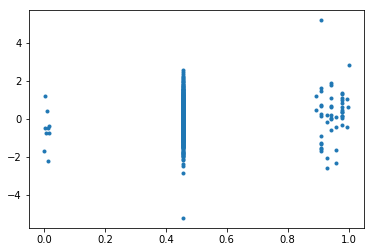

[[1.         0.10970842]
 [0.10970842 1.        ]]
MAFK


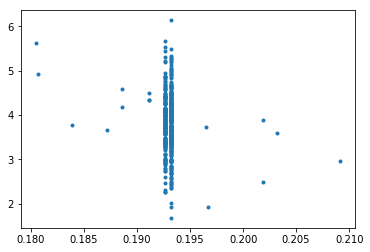

132 853 (445,)
[[ 1.         -0.17321486]
 [-0.17321486  1.        ]]


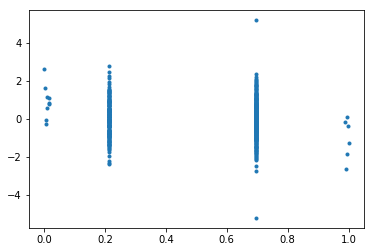

[[ 1.         -0.08484527]
 [-0.08484527  1.        ]]
TBX15


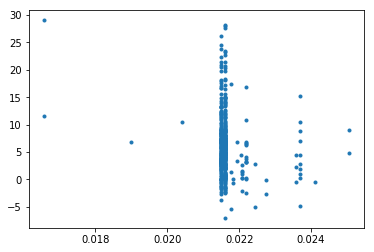

512 386 (445,)
[[ 1.         -0.18881473]
 [-0.18881473  1.        ]]


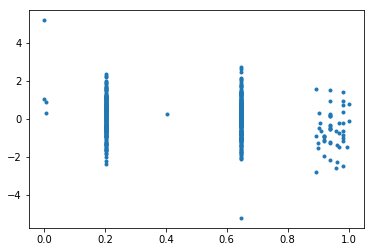

[[ 1.       -0.161014]
 [-0.161014  1.      ]]
DBP


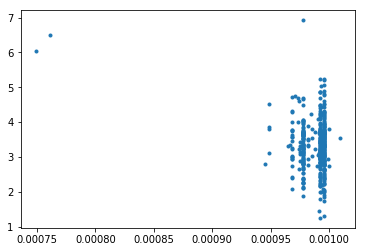

173 551 (445,)
[[ 1.         -0.24749896]
 [-0.24749896  1.        ]]


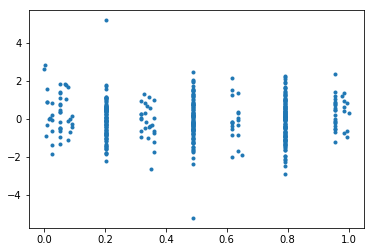

[[ 1.         -0.01592554]
 [-0.01592554  1.        ]]
MEIS3
SOX10
PDX1


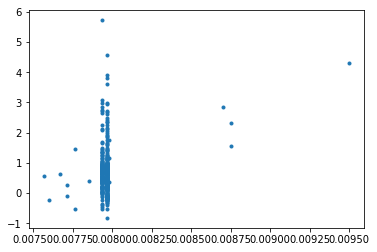

132 184 (445,)
[[1.        0.2770859]
 [0.2770859 1.       ]]


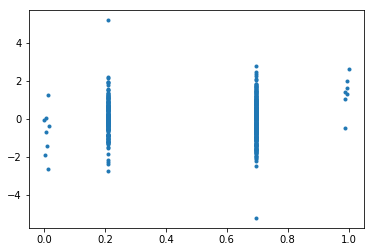

[[1.         0.01017366]
 [0.01017366 1.        ]]
DMRT2
NR5A2


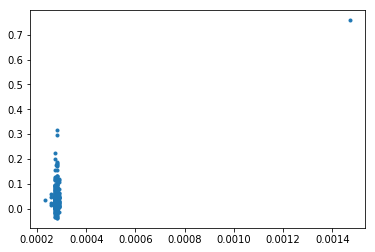

426 542 (445,)
[[1.         0.63735922]
 [0.63735922 1.        ]]


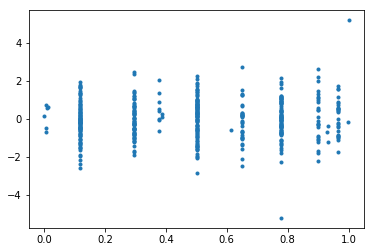

[[1.         0.04736366]
 [0.04736366 1.        ]]
HMX3


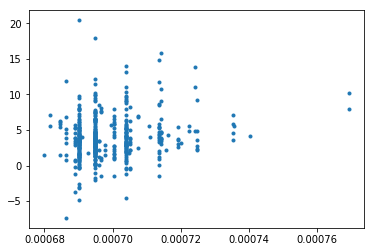

49 683 (445,)
[[1.         0.18486937]
 [0.18486937 1.        ]]


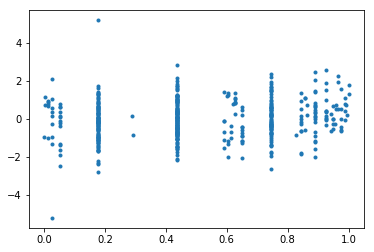

[[1.         0.14932656]
 [0.14932656 1.        ]]
SOX2
MYF6


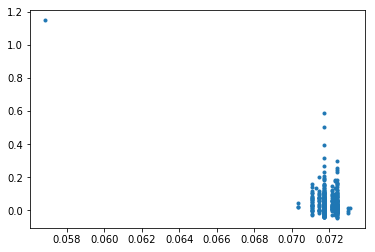

410 46 (445,)
[[ 1.         -0.55408402]
 [-0.55408402  1.        ]]


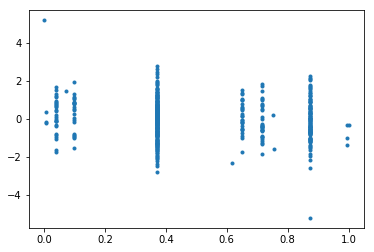

[[ 1.         -0.11002489]
 [-0.11002489  1.        ]]
POU2F3


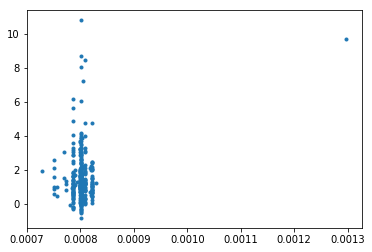

703 534 (445,)
[[1.         0.25991088]
 [0.25991088 1.        ]]


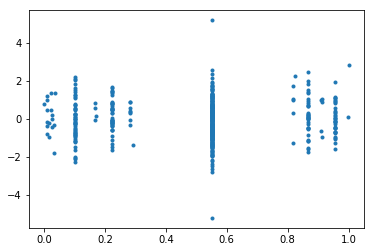

[[1.         0.01170463]
 [0.01170463 1.        ]]
HLF


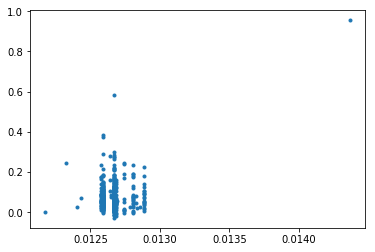

65 68 (445,)
[[1.         0.36674581]
 [0.36674581 1.        ]]


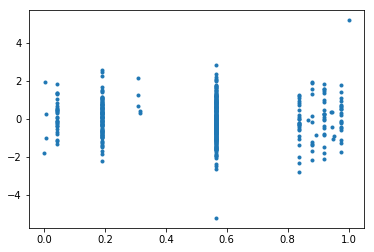

[[ 1.         -0.04034022]
 [-0.04034022  1.        ]]
TP63


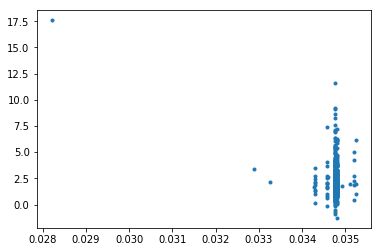

297 417 (445,)
[[ 1.         -0.35945587]
 [-0.35945587  1.        ]]


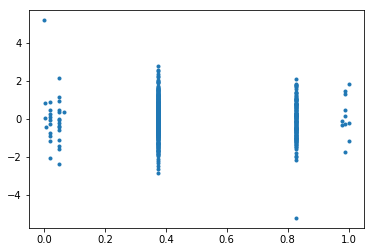

[[ 1.        -0.0425161]
 [-0.0425161  1.       ]]
ELF4


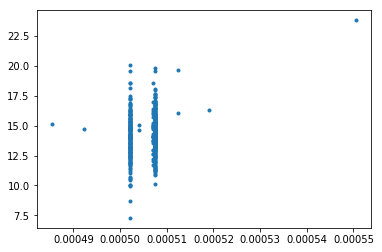

813 667 (445,)
[[1.        0.2443461]
 [0.2443461 1.       ]]


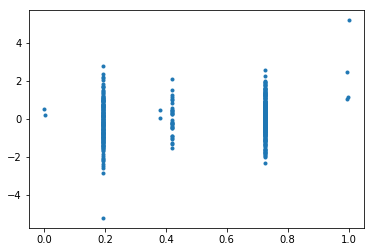

[[1.         0.14928449]
 [0.14928449 1.        ]]
NR4A2


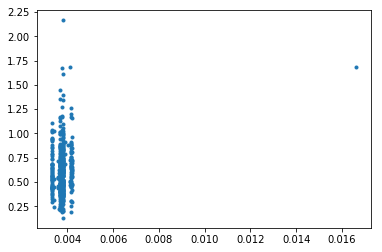

271 73 (445,)
[[1.         0.21045322]
 [0.21045322 1.        ]]


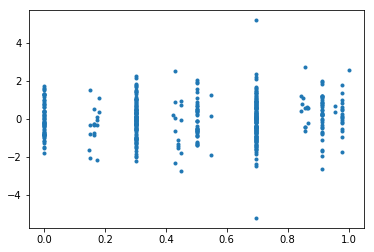

[[1.         0.06891284]
 [0.06891284 1.        ]]
RXRG
FOXO3


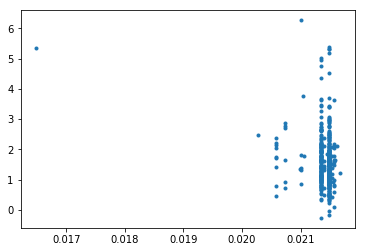

556 840 (445,)
[[ 1.         -0.22118746]
 [-0.22118746  1.        ]]


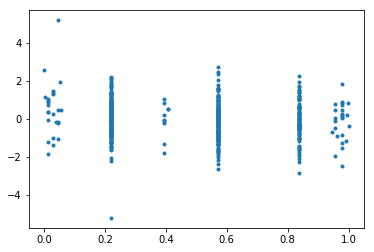

[[ 1.         -0.12218996]
 [-0.12218996  1.        ]]
PRDM4


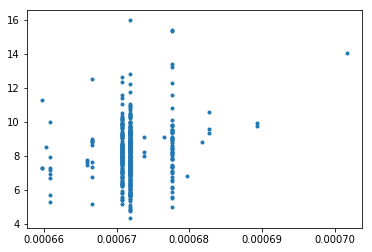

442 349 (445,)
[[1.         0.19481822]
 [0.19481822 1.        ]]


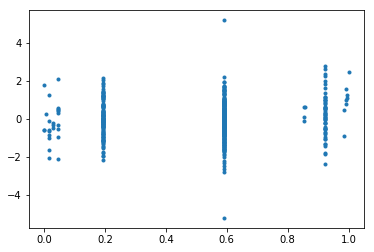

[[1.       0.076218]
 [0.076218 1.      ]]
EGR4


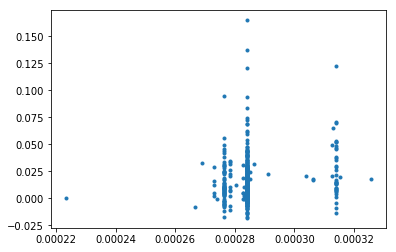

21 468 (445,)
[[1.         0.16705575]
 [0.16705575 1.        ]]


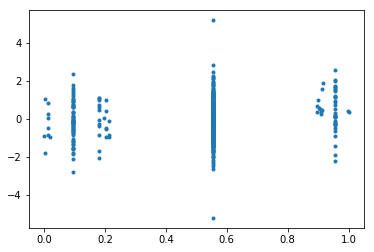

[[1.         0.13879383]
 [0.13879383 1.        ]]
MAFF


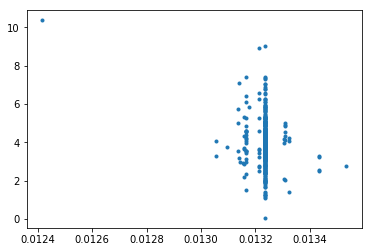

0 451 (445,)
[[ 1.        -0.2487317]
 [-0.2487317  1.       ]]


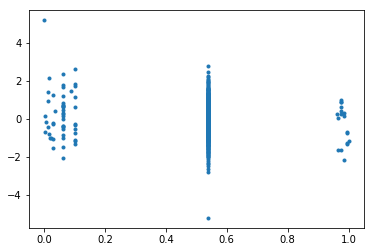

[[ 1.         -0.10773648]
 [-0.10773648  1.        ]]
POU5F1
LMX1A
STAT6


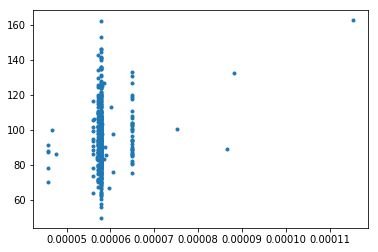

21 795 (445,)
[[1.         0.19305832]
 [0.19305832 1.        ]]


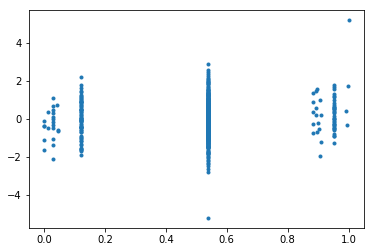

[[1.         0.09195031]
 [0.09195031 1.        ]]
SP100


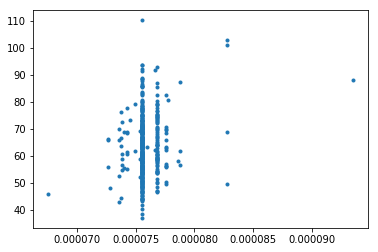

234 424 (445,)
[[1.         0.19648316]
 [0.19648316 1.        ]]


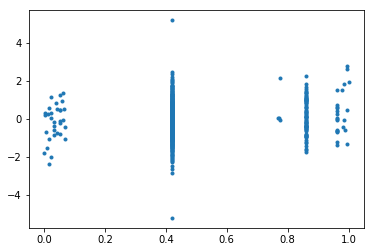

[[1.         0.11451543]
 [0.11451543 1.        ]]
LHX5
PRRX1


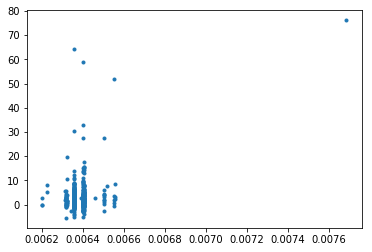

114 46 (445,)
[[1.         0.44469382]
 [0.44469382 1.        ]]


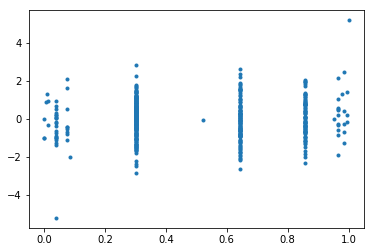

[[1.         0.07507341]
 [0.07507341 1.        ]]
ATF6


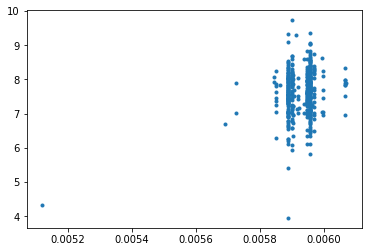

849 79 (445,)
[[1.        0.2307515]
 [0.2307515 1.       ]]


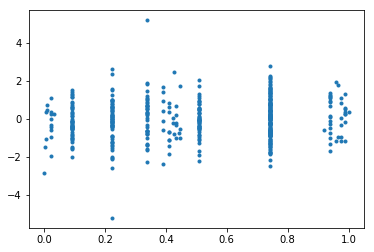

[[1.         0.10494393]
 [0.10494393 1.        ]]
HNF1A


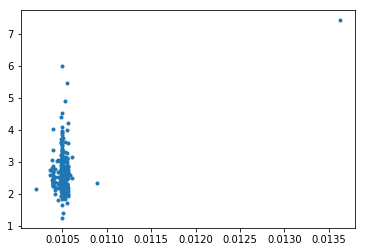

733 307 (445,)
[[1.         0.41785815]
 [0.41785815 1.        ]]


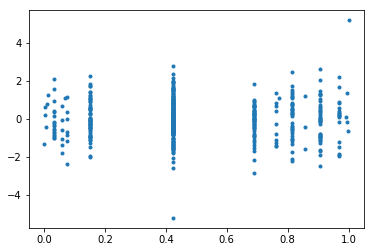

[[1.         0.01726915]
 [0.01726915 1.        ]]
PITX2


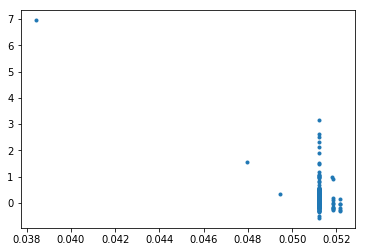

803 860 (445,)
[[ 1.         -0.66637778]
 [-0.66637778  1.        ]]


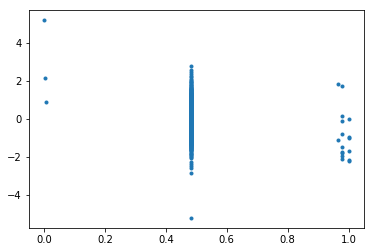

[[ 1.         -0.24108242]
 [-0.24108242  1.        ]]
MEF2D


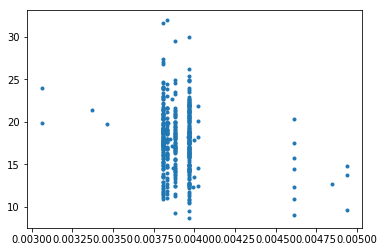

634 47 (445,)
[[ 1.         -0.20272662]
 [-0.20272662  1.        ]]


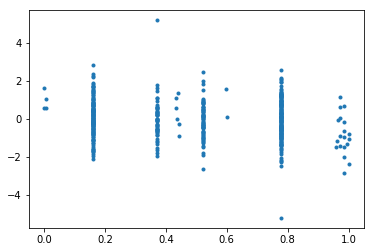

[[ 1.         -0.11957786]
 [-0.11957786  1.        ]]
PROP1
MAX


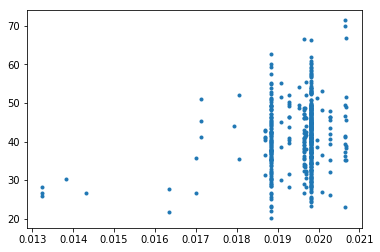

914 386 (445,)
[[1.         0.21492155]
 [0.21492155 1.        ]]


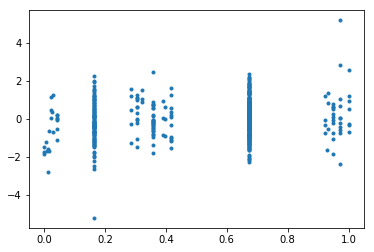

[[1.         0.15531686]
 [0.15531686 1.        ]]
ESR2


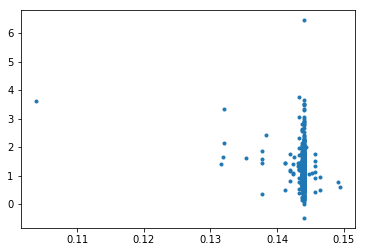

234 61 (445,)
[[ 1.         -0.20537734]
 [-0.20537734  1.        ]]


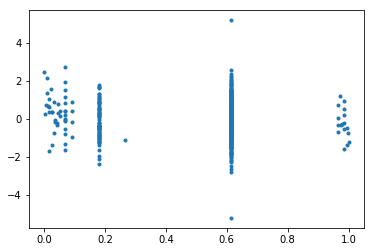

[[ 1.         -0.06361545]
 [-0.06361545  1.        ]]
BATF3


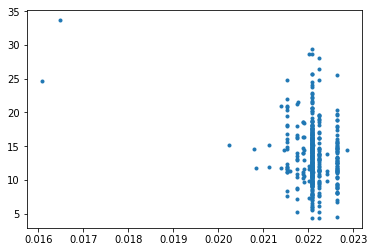

69 65 (445,)
[[ 1.         -0.24322881]
 [-0.24322881  1.        ]]


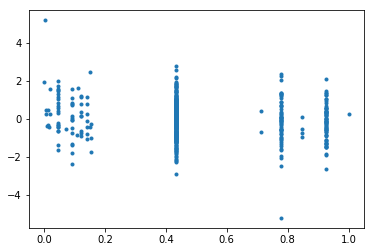

[[ 1.         -0.12568572]
 [-0.12568572  1.        ]]
ATF3


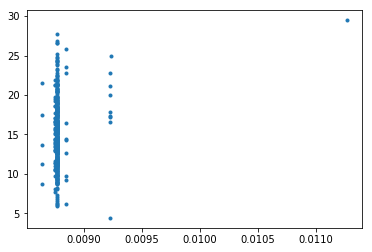

872 135 (445,)
[[1.         0.19180145]
 [0.19180145 1.        ]]


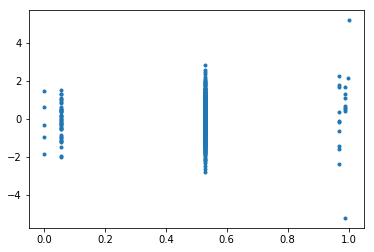

[[1.         0.07119165]
 [0.07119165 1.        ]]
ZBTB18


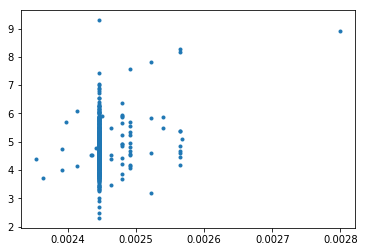

10 677 (445,)
[[1.         0.26845352]
 [0.26845352 1.        ]]


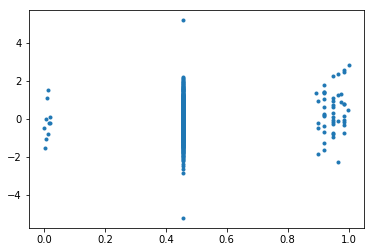

[[1.         0.13697059]
 [0.13697059 1.        ]]
NHLH1


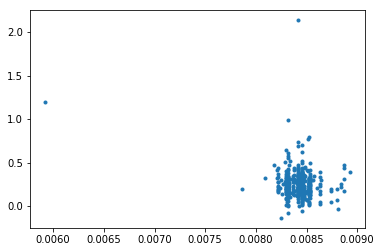

660 377 (445,)
[[ 1.        -0.2229099]
 [-0.2229099  1.       ]]


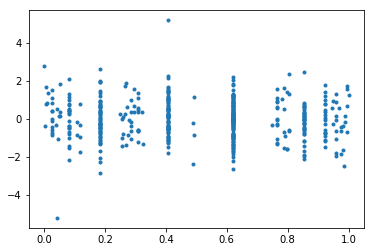

[[ 1.         -0.05099738]
 [-0.05099738  1.        ]]
TGIF1


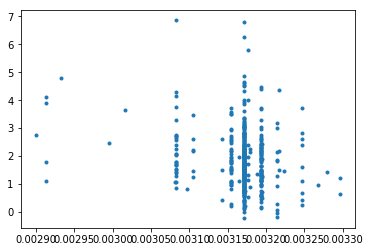

710 190 (445,)
[[ 1.         -0.20620798]
 [-0.20620798  1.        ]]


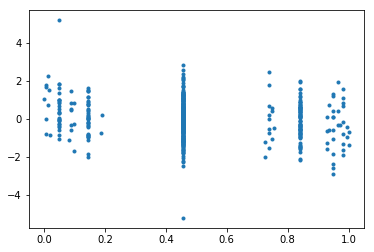

[[ 1.        -0.1636431]
 [-0.1636431  1.       ]]
YY2


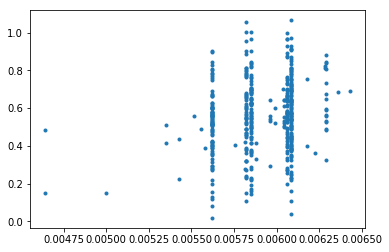

385 819 (445,)
[[1.         0.20107264]
 [0.20107264 1.        ]]


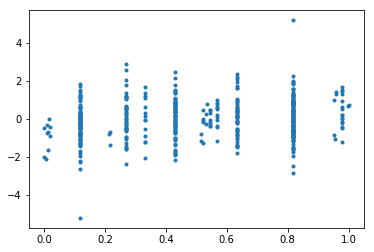

[[1.        0.1686361]
 [0.1686361 1.       ]]
SREBF1


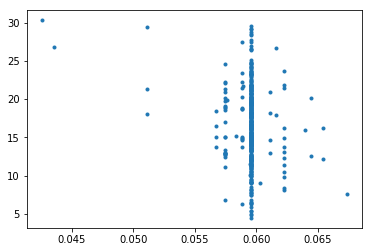

511 840 (445,)
[[ 1.         -0.20358755]
 [-0.20358755  1.        ]]


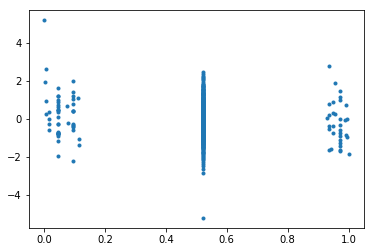

[[ 1.         -0.10644978]
 [-0.10644978  1.        ]]
NRF1


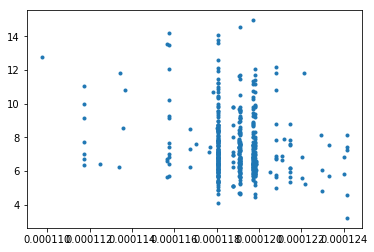

804 569 (445,)
[[ 1.         -0.19415077]
 [-0.19415077  1.        ]]


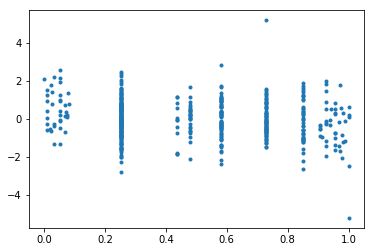

[[ 1.        -0.1493629]
 [-0.1493629  1.       ]]
ZBTB12
FOXD3
SPZ1
POU3F2
NFIB


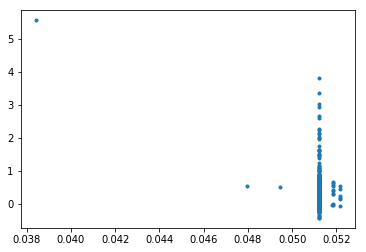

803 860 (445,)
[[ 1.         -0.41813272]
 [-0.41813272  1.        ]]


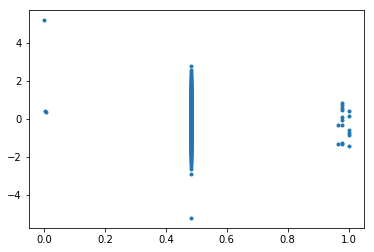

[[ 1.         -0.11006922]
 [-0.11006922  1.        ]]
ELF5
ETS1


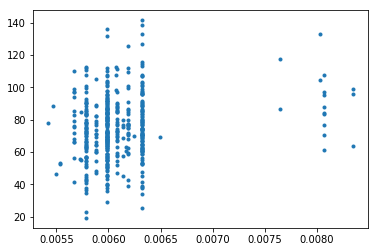

28 69 (445,)
[[1.         0.18910353]
 [0.18910353 1.        ]]


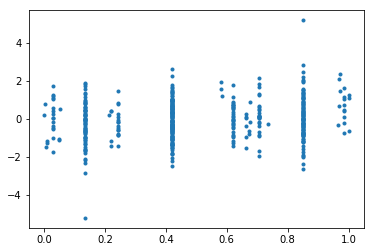

[[1.         0.15900941]
 [0.15900941 1.        ]]
THRB
IRF9


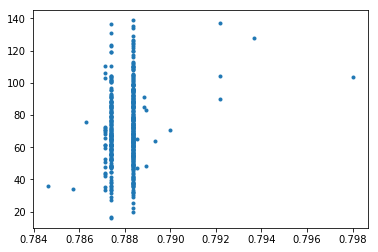

133 805 (445,)
[[1.         0.20931132]
 [0.20931132 1.        ]]


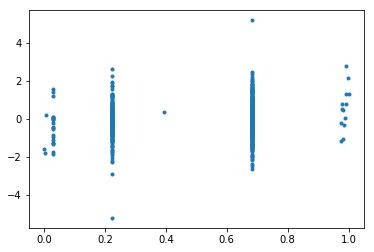

[[1.         0.15356348]
 [0.15356348 1.        ]]
ZNF524


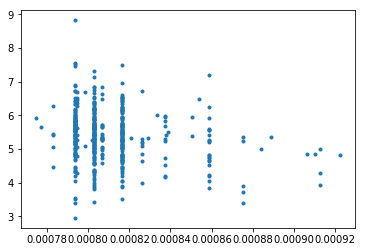

58 218 (445,)
[[ 1.         -0.21015511]
 [-0.21015511  1.        ]]


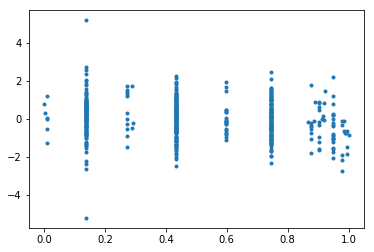

[[ 1.         -0.16519499]
 [-0.16519499  1.        ]]
DLX5
ETV3


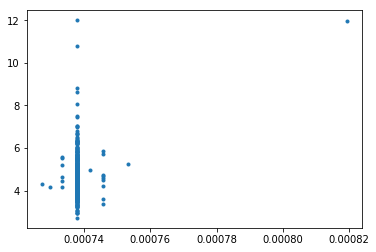

803 241 (445,)
[[1.         0.31080419]
 [0.31080419 1.        ]]


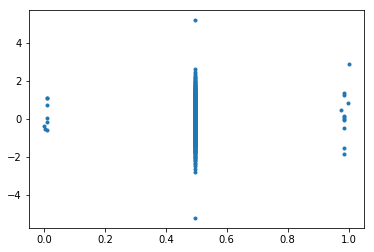

[[1.         0.01937463]
 [0.01937463 1.        ]]
MTF1


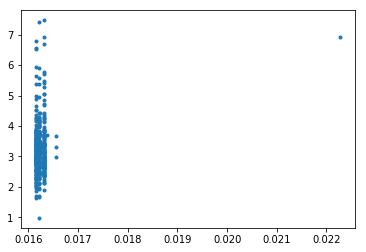

182 48 (445,)
[[1.        0.2070208]
 [0.2070208 1.       ]]


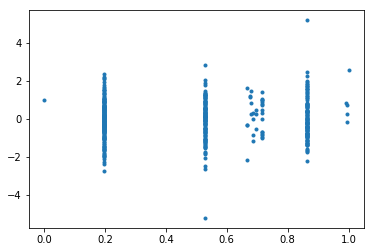

[[1.         0.06234635]
 [0.06234635 1.        ]]
MGA


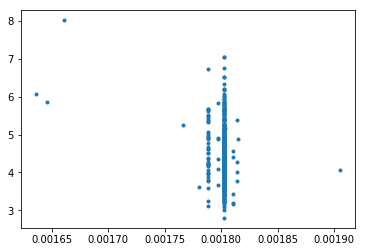

870 519 (445,)
[[ 1.         -0.23403478]
 [-0.23403478  1.        ]]


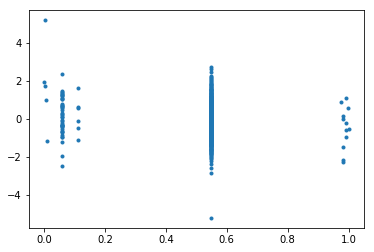

[[ 1.         -0.13569452]
 [-0.13569452  1.        ]]
PTEN


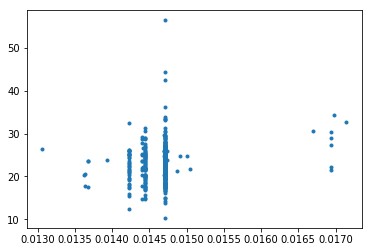

21 5 (445,)
[[1.         0.19281135]
 [0.19281135 1.        ]]


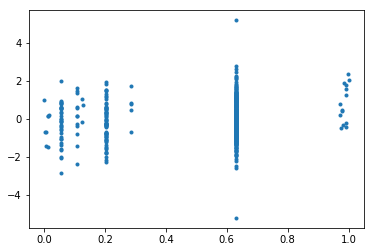

[[1.         0.13023893]
 [0.13023893 1.        ]]
SRY
TFAP2B
OTX2
ALX4
DBX2
NFIA
KLF7


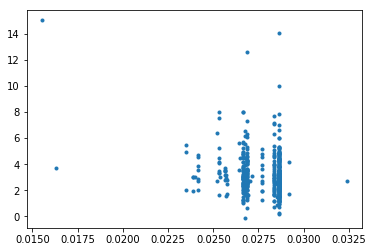

696 39 (445,)
[[ 1.         -0.22686865]
 [-0.22686865  1.        ]]


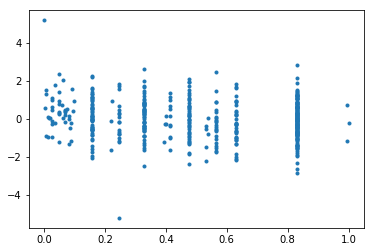

[[ 1.         -0.13144051]
 [-0.13144051  1.        ]]
YY1


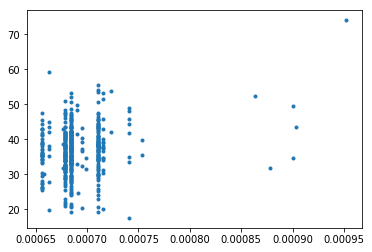

741 788 (445,)
[[1.         0.22492728]
 [0.22492728 1.        ]]


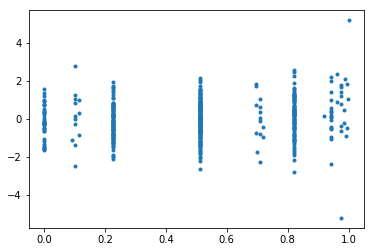

[[1.         0.12852878]
 [0.12852878 1.        ]]
BHLHA15


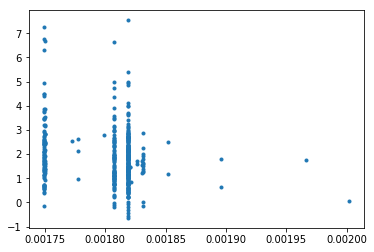

581 331 (445,)
[[ 1.         -0.19456597]
 [-0.19456597  1.        ]]


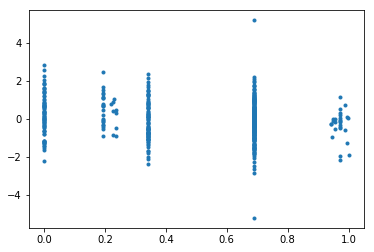

[[ 1.        -0.1377536]
 [-0.1377536  1.       ]]
TBX5
PBX1
SREBF2


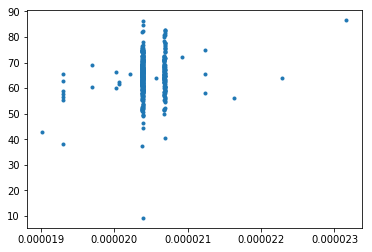

635 498 (445,)
[[1.         0.20043435]
 [0.20043435 1.        ]]


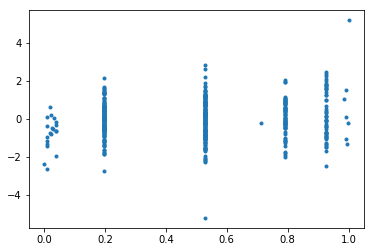

[[1.         0.12050897]
 [0.12050897 1.        ]]
BHLHE23
JDP2


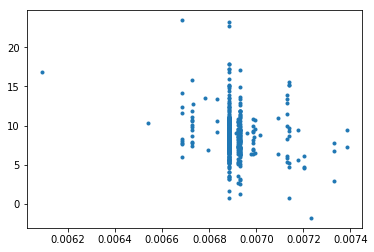

708 255 (445,)
[[ 1.         -0.19936953]
 [-0.19936953  1.        ]]


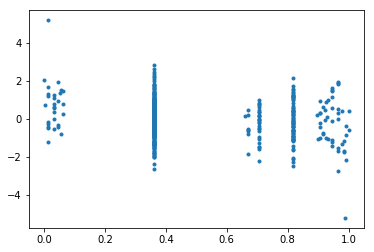

[[ 1.         -0.17948439]
 [-0.17948439  1.        ]]
NKX6-3


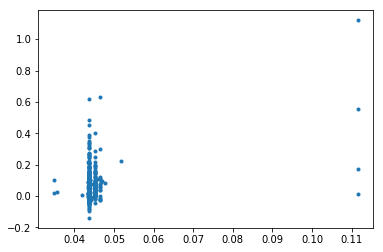

236 232 (445,)
[[1.         0.35211378]
 [0.35211378 1.        ]]


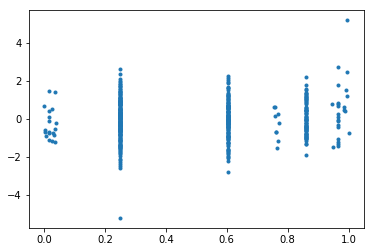

[[1.         0.08066154]
 [0.08066154 1.        ]]
ISX


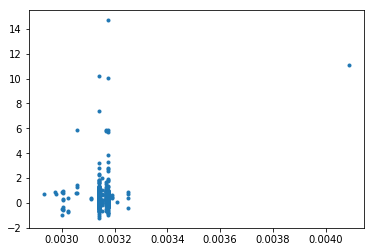

671 91 (445,)
[[1.         0.30145949]
 [0.30145949 1.        ]]


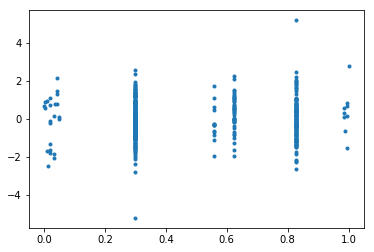

[[1.         0.05077785]
 [0.05077785 1.        ]]
POU5F1


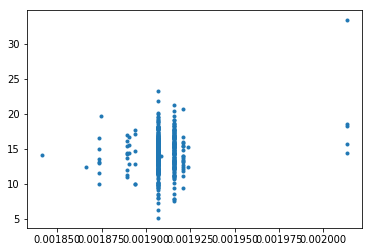

829 169 (445,)
[[1.         0.20319389]
 [0.20319389 1.        ]]


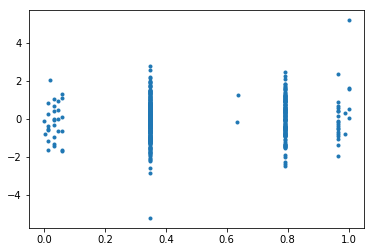

[[1.         0.09330859]
 [0.09330859 1.        ]]
PROP1
MESP1


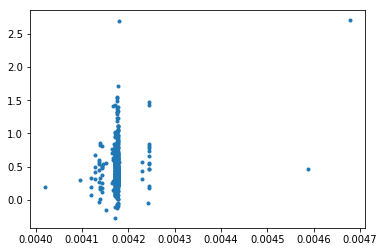

264 610 (445,)
[[1.         0.26595419]
 [0.26595419 1.        ]]


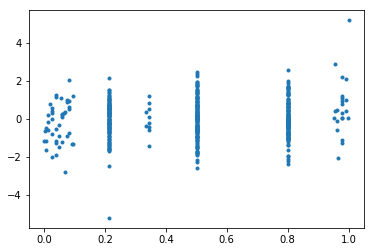

[[1.         0.09963059]
 [0.09963059 1.        ]]
NR3C1


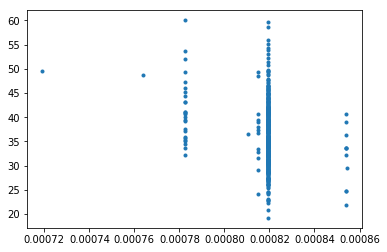

784 217 (445,)
[[ 1.         -0.24749878]
 [-0.24749878  1.        ]]


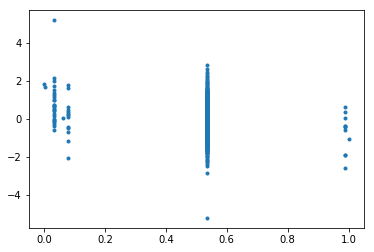

[[ 1.         -0.22144098]
 [-0.22144098  1.        ]]
ZNF350


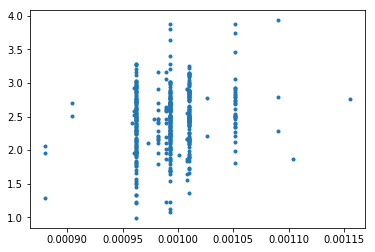

188 413 (445,)
[[1.         0.19977313]
 [0.19977313 1.        ]]


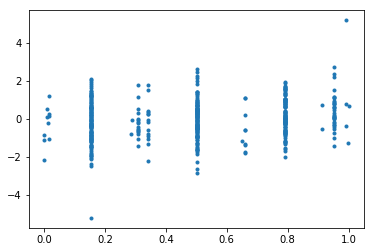

[[1.         0.18400878]
 [0.18400878 1.        ]]
DMRTA2
ESRRA


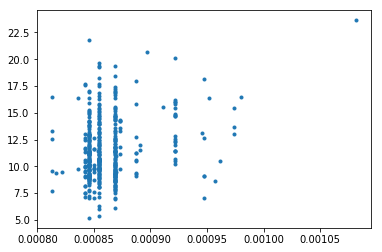

58 241 (445,)
[[1.         0.24958136]
 [0.24958136 1.        ]]


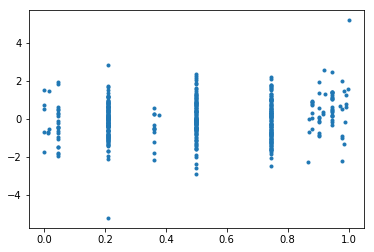

[[1.         0.15124287]
 [0.15124287 1.        ]]
POU5F1
TLX2


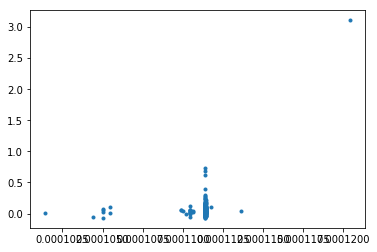

919 703 (445,)
[[1.         0.39576526]
 [0.39576526 1.        ]]


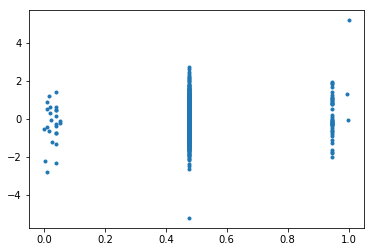

[[1.         0.10136117]
 [0.10136117 1.        ]]
FOXA1
ATF7


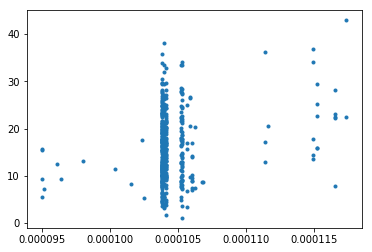

215 598 (445,)
[[1.         0.23113132]
 [0.23113132 1.        ]]


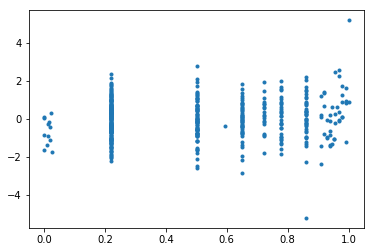

[[1.         0.10035574]
 [0.10035574 1.        ]]
NFIL3


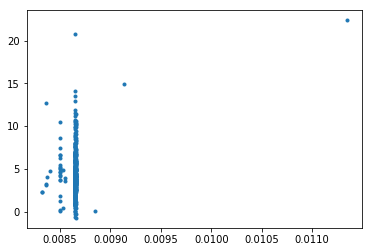

109 816 (445,)
[[1.         0.30796873]
 [0.30796873 1.        ]]


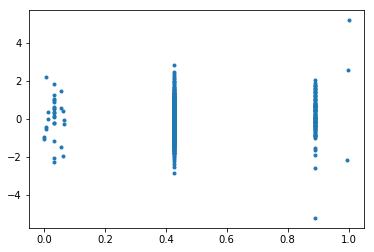

[[1.         0.09602392]
 [0.09602392 1.        ]]
FOXJ2


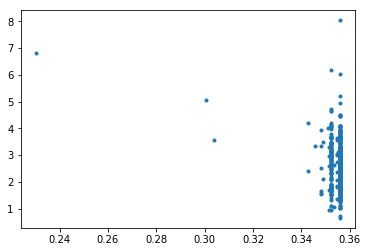

14 83 (445,)
[[ 1.        -0.2492458]
 [-0.2492458  1.       ]]


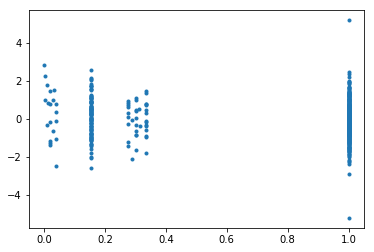

[[ 1.       -0.076336]
 [-0.076336  1.      ]]
FOXC1


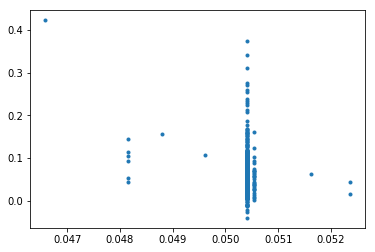

754 917 (445,)
[[ 1.         -0.23543023]
 [-0.23543023  1.        ]]


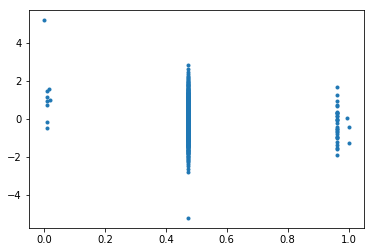

[[ 1.         -0.14485921]
 [-0.14485921  1.        ]]
UNCX
BACH1


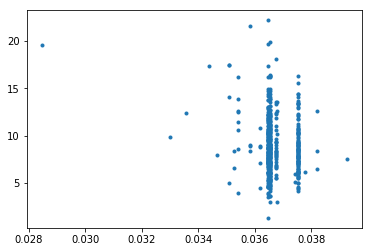

284 834 (445,)
[[ 1.         -0.20292779]
 [-0.20292779  1.        ]]


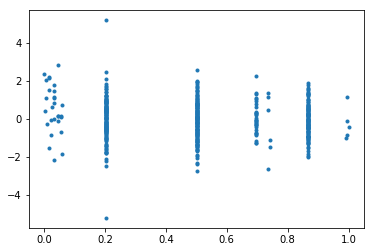

[[ 1.         -0.08434856]
 [-0.08434856  1.        ]]
DLX6
NEUROD2


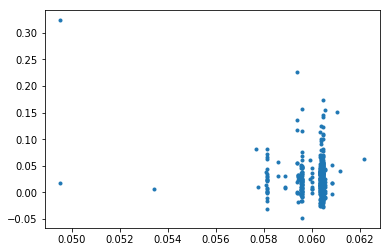

722 93 (445,)
[[ 1.         -0.20378662]
 [-0.20378662  1.        ]]


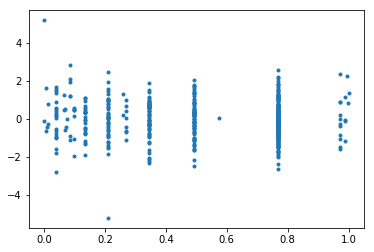

[[ 1.         -0.05454652]
 [-0.05454652  1.        ]]
POU3F1


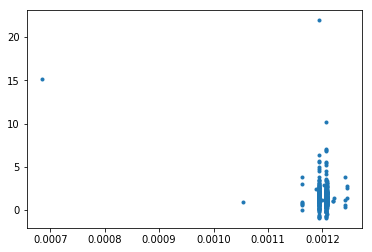

362 251 (445,)
[[ 1.        -0.3517984]
 [-0.3517984  1.       ]]


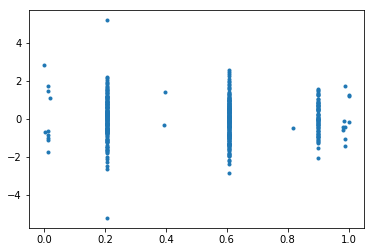

[[ 1.         -0.02727584]
 [-0.02727584  1.        ]]
ZSCAN4


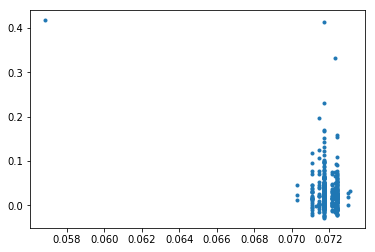

410 46 (445,)
[[ 1.         -0.37074813]
 [-0.37074813  1.        ]]


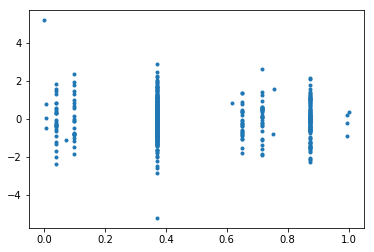

[[ 1.         -0.04786215]
 [-0.04786215  1.        ]]
POU2F1


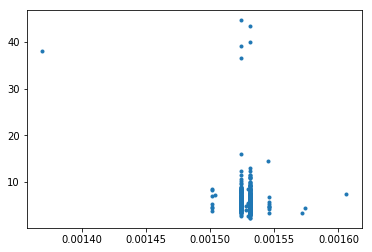

775 572 (445,)
[[ 1.         -0.27952886]
 [-0.27952886  1.        ]]


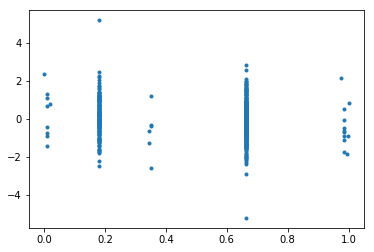

[[ 1.         -0.10976808]
 [-0.10976808  1.        ]]
LHX1
ELK4


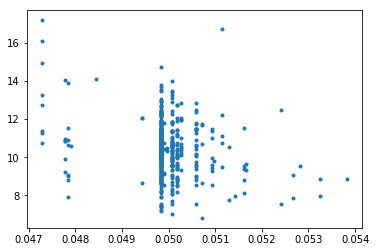

700 861 (445,)
[[ 1.         -0.24653266]
 [-0.24653266  1.        ]]


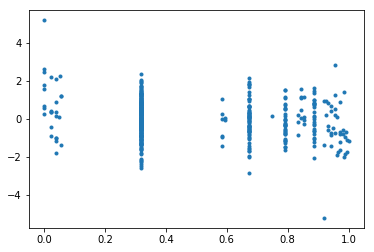

[[ 1.         -0.16220554]
 [-0.16220554  1.        ]]
HIF1A


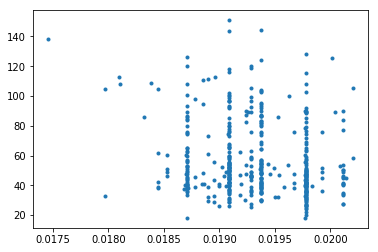

663 866 (445,)
[[ 1.         -0.18906402]
 [-0.18906402  1.        ]]


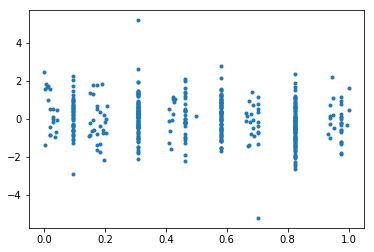

[[ 1.         -0.17239064]
 [-0.17239064  1.        ]]
MYBL1


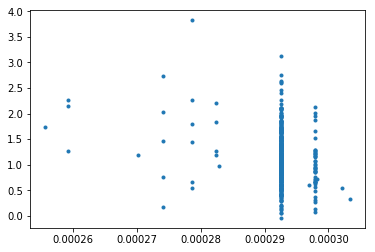

868 165 (445,)
[[ 1.         -0.22497015]
 [-0.22497015  1.        ]]


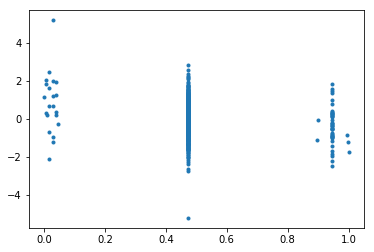

[[ 1.         -0.19942046]
 [-0.19942046  1.        ]]
GLIS1
SOX4


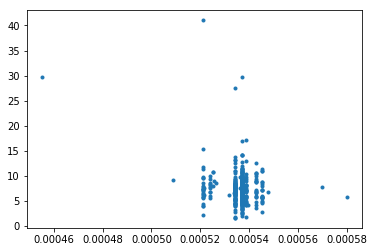

65 687 (445,)
[[ 1.         -0.24487408]
 [-0.24487408  1.        ]]


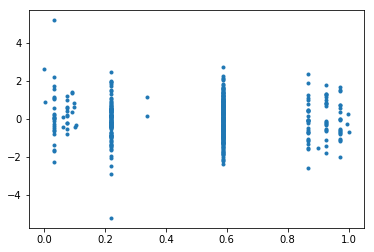

[[ 1.         -0.04454168]
 [-0.04454168  1.        ]]
SP4


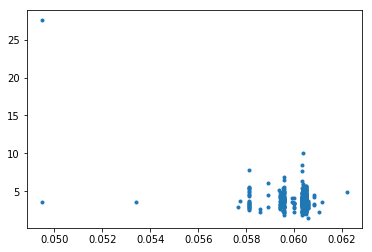

722 93 (445,)
[[ 1.        -0.4144187]
 [-0.4144187  1.       ]]


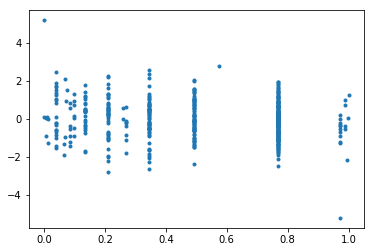

[[ 1.         -0.12473611]
 [-0.12473611  1.        ]]
TFEB


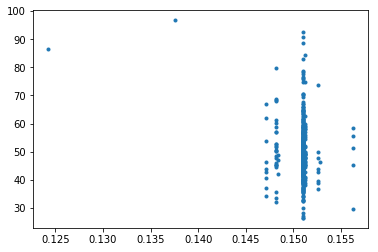

873 869 (445,)
[[ 1.      -0.21512]
 [-0.21512  1.     ]]


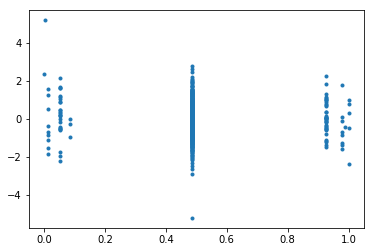

[[ 1.         -0.05284889]
 [-0.05284889  1.        ]]
ZNF384


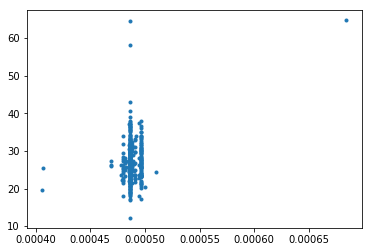

166 778 (445,)
[[1.         0.31064643]
 [0.31064643 1.        ]]


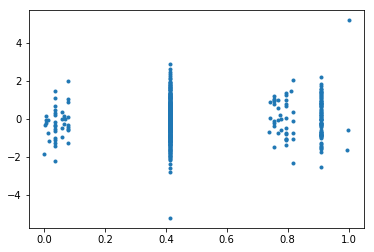

[[1.         0.08413956]
 [0.08413956 1.        ]]
NFKB1


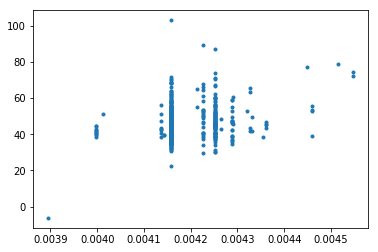

90 152 (445,)
[[1.         0.26581411]
 [0.26581411 1.        ]]


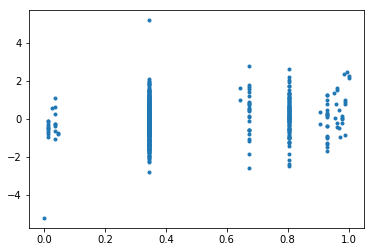

[[1.         0.17920265]
 [0.17920265 1.        ]]
IRF2


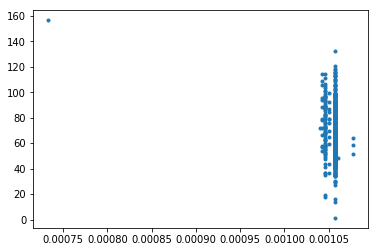

16 122 (445,)
[[ 1.         -0.22154362]
 [-0.22154362  1.        ]]


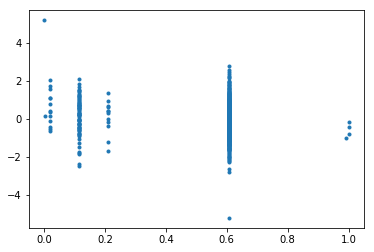

[[ 1.         -0.14977891]
 [-0.14977891  1.        ]]
PGR
ELK3


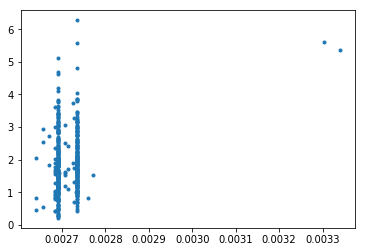

686 221 (445,)
[[1.         0.26409181]
 [0.26409181 1.        ]]


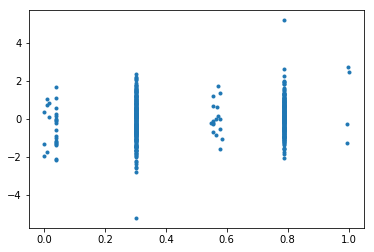

[[1.         0.14970935]
 [0.14970935 1.        ]]
E4F1


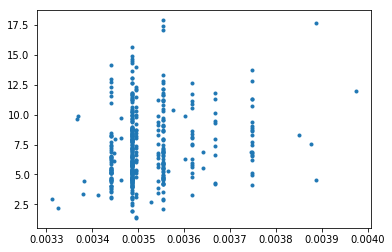

73 271 (445,)
[[1.         0.19510241]
 [0.19510241 1.        ]]


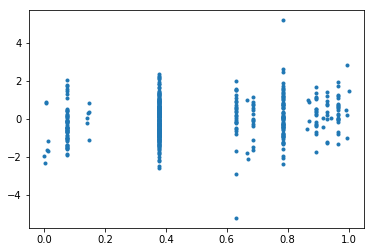

[[1.         0.18901211]
 [0.18901211 1.        ]]
USF1


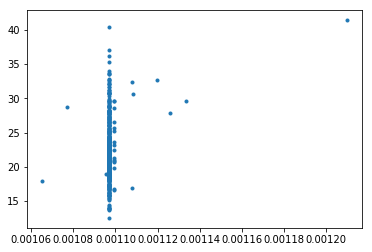

3 166 (445,)
[[1.         0.23437715]
 [0.23437715 1.        ]]


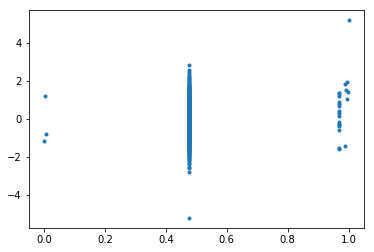

[[1.         0.13950938]
 [0.13950938 1.        ]]
SRF


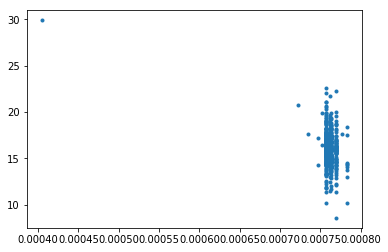

797 755 (445,)
[[ 1.         -0.35970911]
 [-0.35970911  1.        ]]


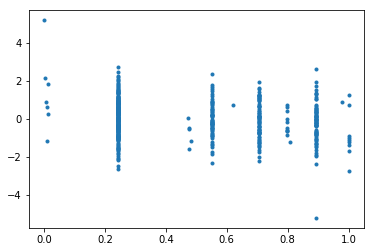

[[ 1.        -0.1673328]
 [-0.1673328  1.       ]]
ELK1


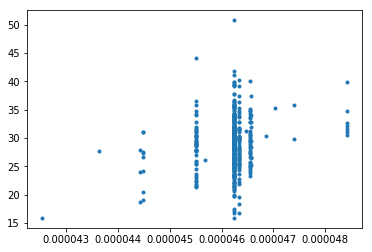

706 566 (445,)
[[1.         0.20570243]
 [0.20570243 1.        ]]


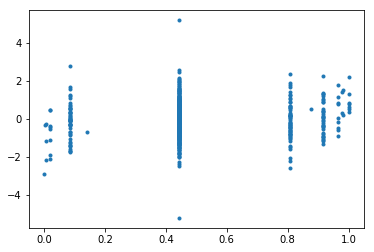

[[1.         0.11113728]
 [0.11113728 1.        ]]
PKNOX2
LMX1B
NANOG
TEAD3


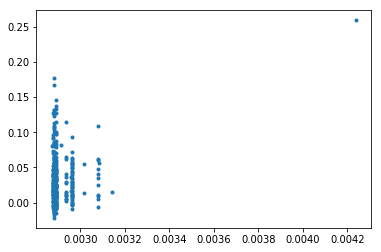

402 693 (445,)
[[1.         0.28368007]
 [0.28368007 1.        ]]


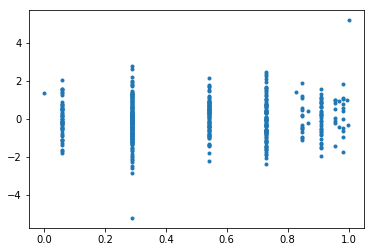

[[1.         0.05888744]
 [0.05888744 1.        ]]
ZNF784


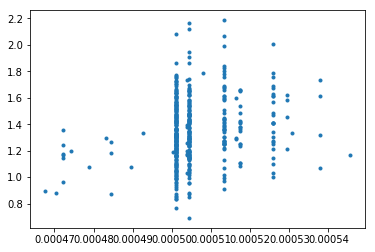

839 537 (445,)
[[1.        0.2134983]
 [0.2134983 1.       ]]


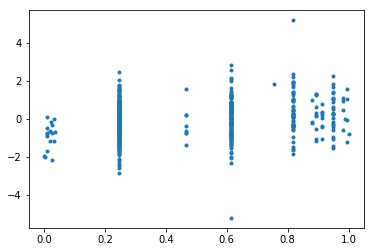

[[1.         0.19956582]
 [0.19956582 1.        ]]
RUNX2


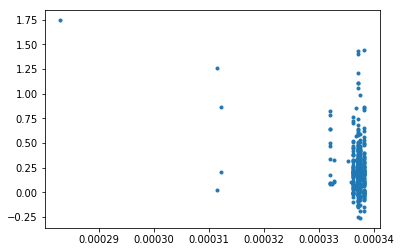

798 361 (445,)
[[ 1.         -0.31755984]
 [-0.31755984  1.        ]]


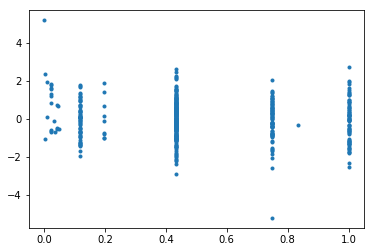

[[ 1.         -0.09051014]
 [-0.09051014  1.        ]]
HSF1


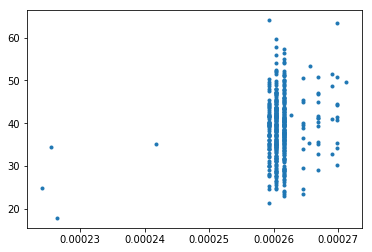

355 704 (445,)
[[1.         0.18728302]
 [0.18728302 1.        ]]


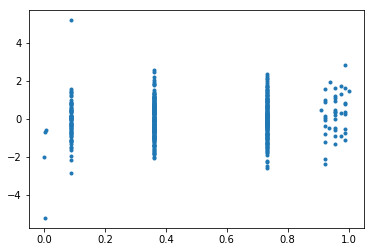

[[1.         0.08768641]
 [0.08768641 1.        ]]
POU3F4
RXRB


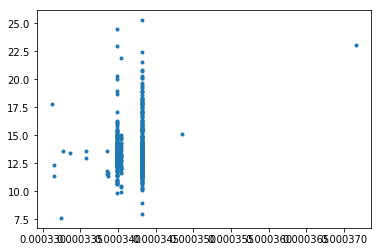

844 810 (445,)
[[1.         0.21045059]
 [0.21045059 1.        ]]


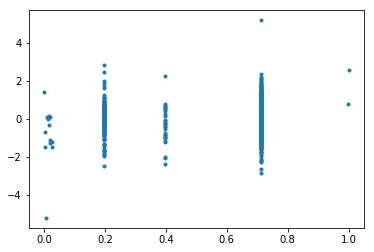

[[1.         0.11745433]
 [0.11745433 1.        ]]
DMRTC2
IRF4


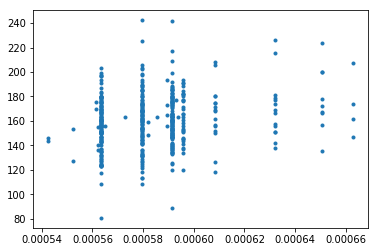

189 544 (445,)
[[1.         0.19616325]
 [0.19616325 1.        ]]


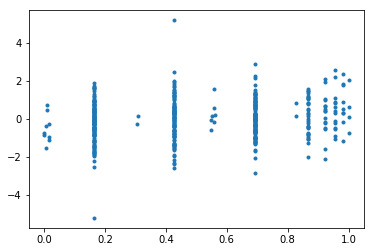

[[1.         0.16747867]
 [0.16747867 1.        ]]
AHR


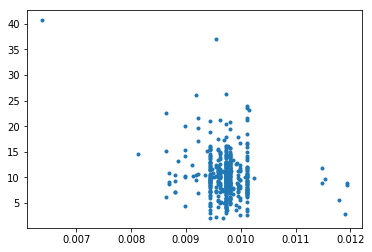

661 701 (445,)
[[ 1.         -0.22840036]
 [-0.22840036  1.        ]]


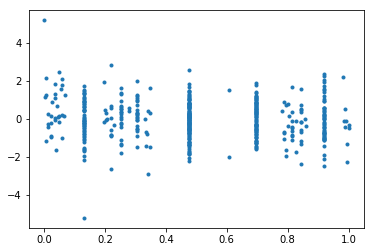

[[ 1.         -0.09098498]
 [-0.09098498  1.        ]]
IRX5
POU4F2
KLF16


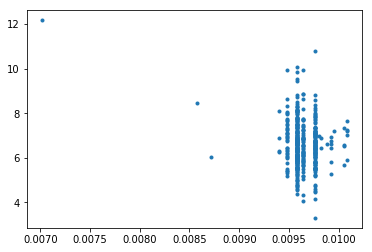

677 417 (445,)
[[ 1.         -0.22235101]
 [-0.22235101  1.        ]]


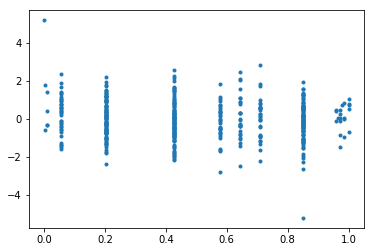

[[ 1.         -0.09700037]
 [-0.09700037  1.        ]]
RXRB
ZBTB12
ONECUT3
RAX


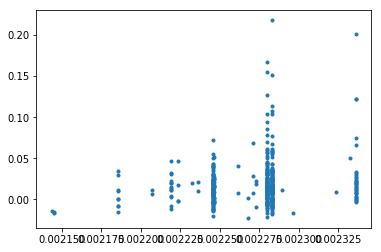

191 667 (445,)
[[1.         0.19875273]
 [0.19875273 1.        ]]


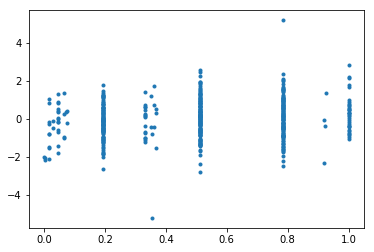

[[1.         0.15233927]
 [0.15233927 1.        ]]
TBX20
GBX1
BHLHE22


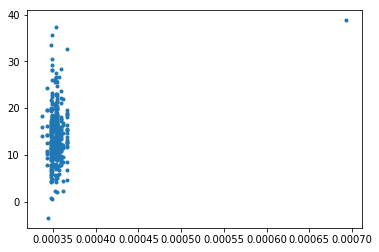

344 243 (445,)
[[1.         0.21428573]
 [0.21428573 1.        ]]


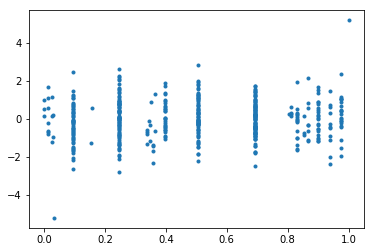

[[1.         0.06844938]
 [0.06844938 1.        ]]
ARID5B


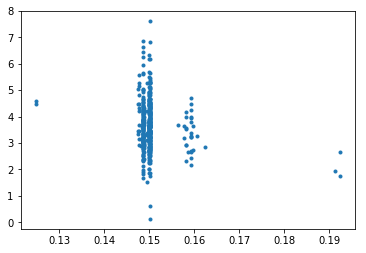

50 855 (445,)
[[ 1.         -0.18125532]
 [-0.18125532  1.        ]]


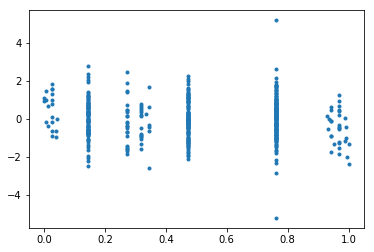

[[ 1.         -0.06752527]
 [-0.06752527  1.        ]]
NR2E1
EP300


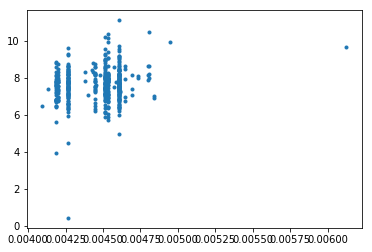

614 18 (445,)
[[1.         0.19677822]
 [0.19677822 1.        ]]


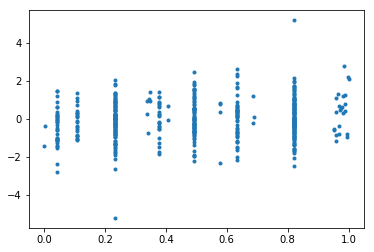

[[1.        0.1467905]
 [0.1467905 1.       ]]
ERG
NR6A1


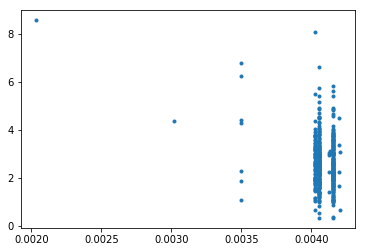

362 342 (445,)
[[ 1.         -0.29212161]
 [-0.29212161  1.        ]]


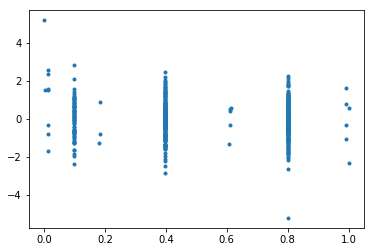

[[ 1.         -0.09074344]
 [-0.09074344  1.        ]]
ZNF423


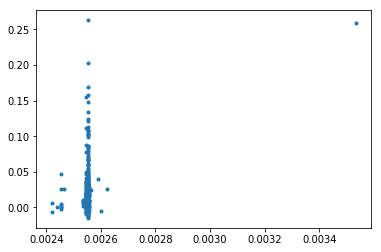

248 285 (445,)
[[1.         0.34525125]
 [0.34525125 1.        ]]


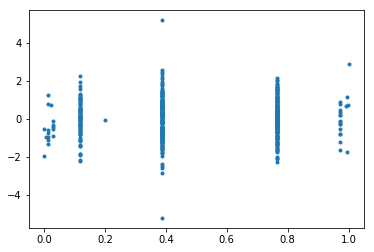

[[1.         0.05208575]
 [0.05208575 1.        ]]
TGIF2


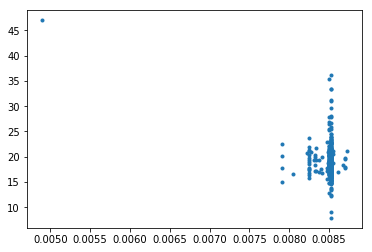

233 351 (445,)
[[ 1.         -0.35362197]
 [-0.35362197  1.        ]]


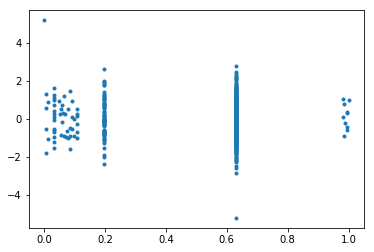

[[ 1.        -0.0351749]
 [-0.0351749  1.       ]]
BHLHE41


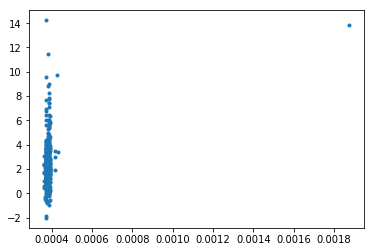

188 201 (445,)
[[1.         0.29539147]
 [0.29539147 1.        ]]


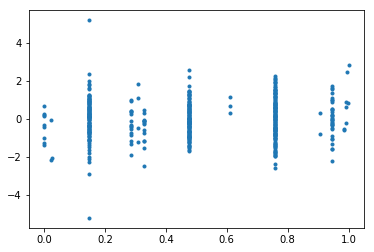

[[1.        0.0675352]
 [0.0675352 1.       ]]
BCL6B


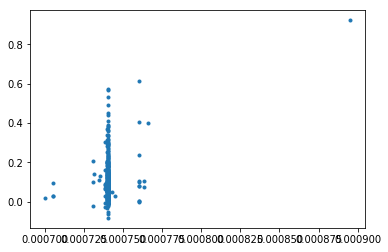

329 582 (445,)
[[1.         0.36514316]
 [0.36514316 1.        ]]


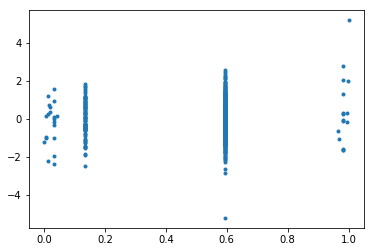

[[1.         0.04376163]
 [0.04376163 1.        ]]
MYEF2


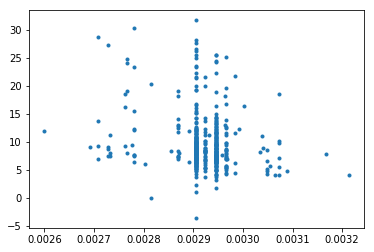

662 332 (445,)
[[ 1.         -0.21004124]
 [-0.21004124  1.        ]]


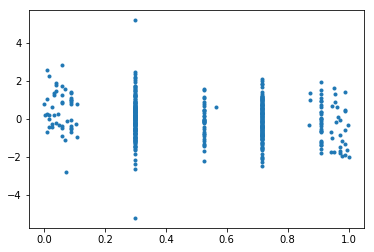

[[ 1.         -0.17372332]
 [-0.17372332  1.        ]]
IRX4
PAX3


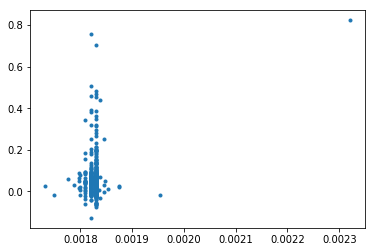

119 299 (445,)
[[1.         0.31153414]
 [0.31153414 1.        ]]


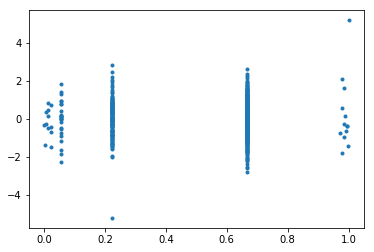

[[1.         0.00549407]
 [0.00549407 1.        ]]
CREB3L2


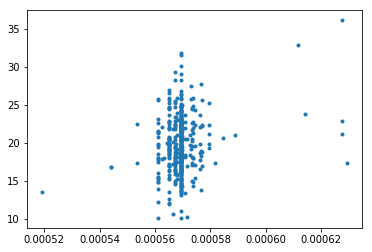

699 705 (445,)
[[1.         0.21200806]
 [0.21200806 1.        ]]


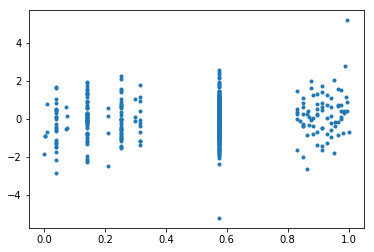

[[1.        0.1070772]
 [0.1070772 1.       ]]
LBX2


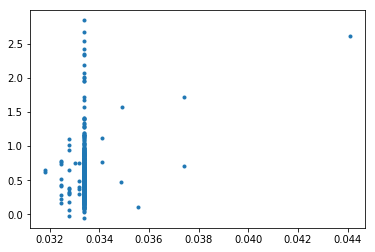

920 879 (445,)
[[1.         0.24628481]
 [0.24628481 1.        ]]


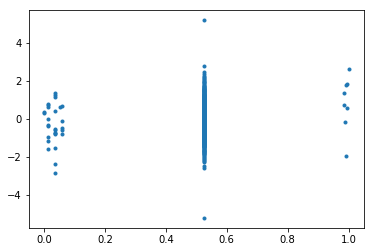

[[1.         0.11024673]
 [0.11024673 1.        ]]
ZIC1
RXRA


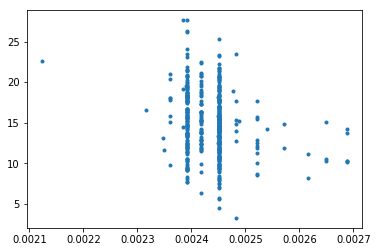

851 190 (445,)
[[ 1.         -0.23247738]
 [-0.23247738  1.        ]]


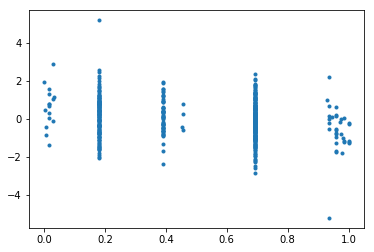

[[ 1.         -0.21067327]
 [-0.21067327  1.        ]]
GSX1
PLAGL1


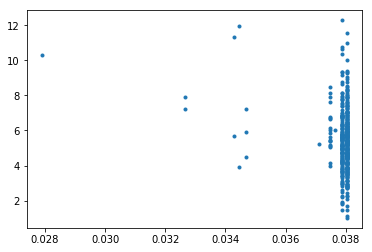

819 888 (445,)
[[ 1.         -0.21080088]
 [-0.21080088  1.        ]]


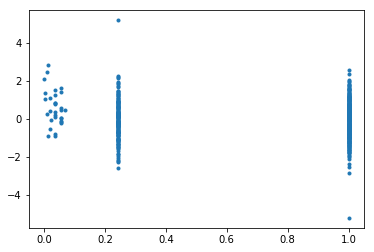

[[ 1.         -0.08672475]
 [-0.08672475  1.        ]]
E2F3


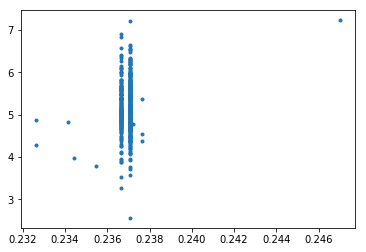

277 858 (445,)
[[1.         0.18680209]
 [0.18680209 1.        ]]


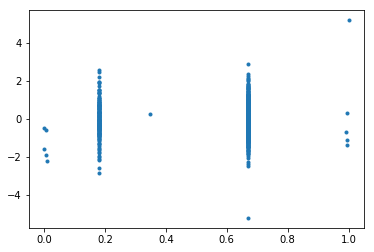

[[1.         0.05446509]
 [0.05446509 1.        ]]
ESRRB


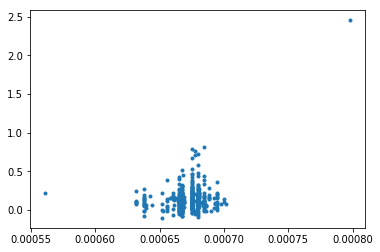

160 268 (445,)
[[1.         0.33162694]
 [0.33162694 1.        ]]


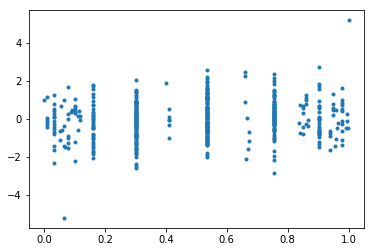

[[1.        0.1442688]
 [0.1442688 1.       ]]
GLIS2


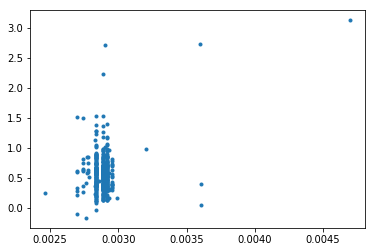

205 584 (445,)
[[1.         0.33810533]
 [0.33810533 1.        ]]


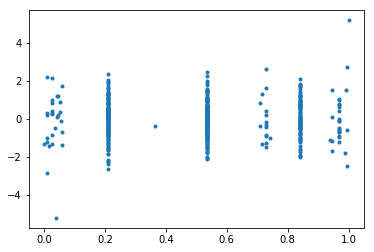

[[1.         0.02624082]
 [0.02624082 1.        ]]
NKX2-5


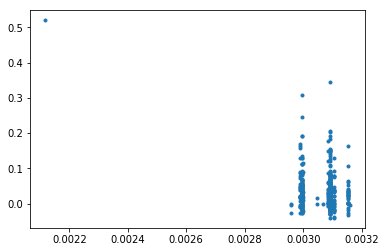

409 387 (445,)
[[ 1.         -0.33461557]
 [-0.33461557  1.        ]]


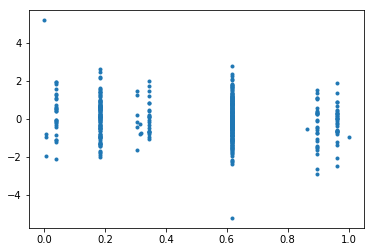

[[ 1.         -0.12214105]
 [-0.12214105  1.        ]]
IRF1


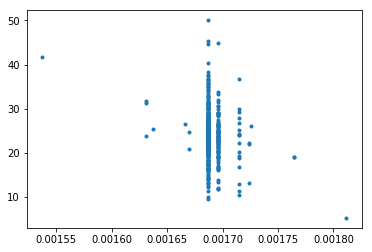

110 114 (445,)
[[ 1.         -0.24046415]
 [-0.24046415  1.        ]]


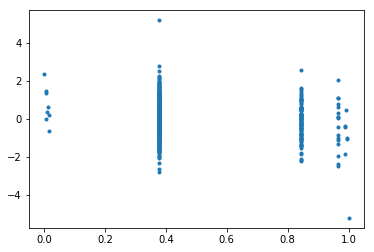

[[ 1.         -0.15182351]
 [-0.15182351  1.        ]]
ESRRG
LHX2


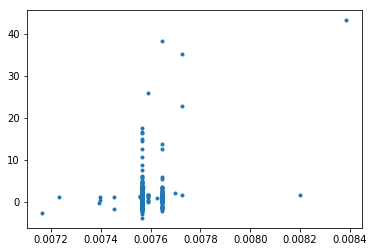

331 817 (445,)
[[1.         0.38024236]
 [0.38024236 1.        ]]


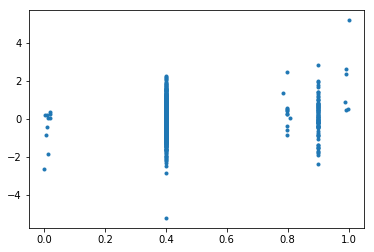

[[1.         0.14052556]
 [0.14052556 1.        ]]
TFAP4


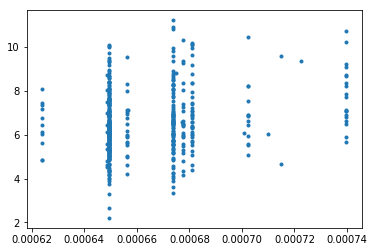

863 154 (445,)
[[1.         0.21346365]
 [0.21346365 1.        ]]


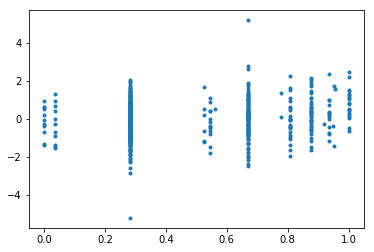

[[1.        0.1825094]
 [0.1825094 1.       ]]
PROX1


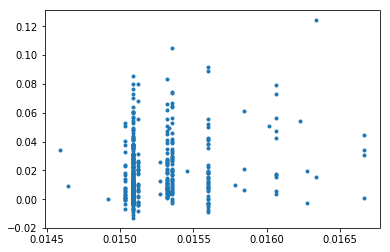

482 108 (445,)
[[1.        0.1992711]
 [0.1992711 1.       ]]


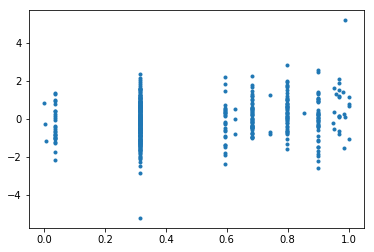

[[1.         0.19262906]
 [0.19262906 1.        ]]
GLI2
ETV6


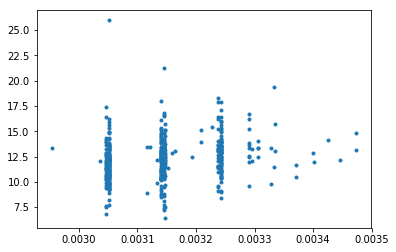

612 282 (445,)
[[1.         0.20263647]
 [0.20263647 1.        ]]


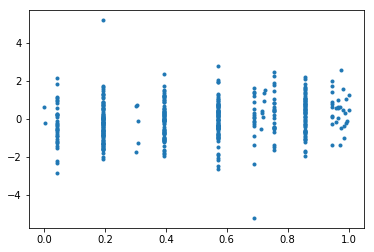

[[1.         0.20420533]
 [0.20420533 1.        ]]
SOX21
SIX2
SPIB
OLIG3
FOXF2
PROP1
E2F1


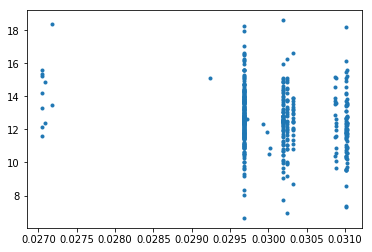

597 815 (445,)
[[ 1.         -0.21077609]
 [-0.21077609  1.        ]]


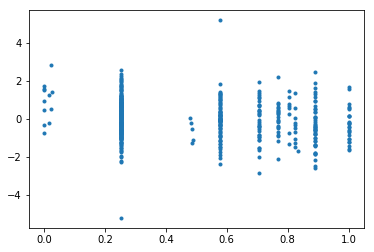

[[ 1.         -0.17963526]
 [-0.17963526  1.        ]]
HOXD10
TFE3


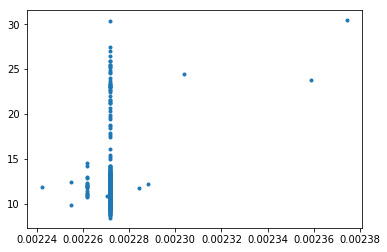

4 79 (445,)
[[1.        0.2770763]
 [0.2770763 1.       ]]


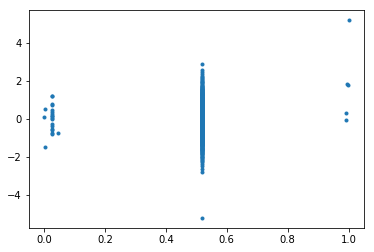

[[1.         0.07414727]
 [0.07414727 1.        ]]
FOXQ1
ARNT


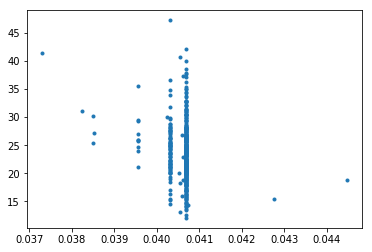

331 823 (445,)
[[ 1.         -0.21145489]
 [-0.21145489  1.        ]]


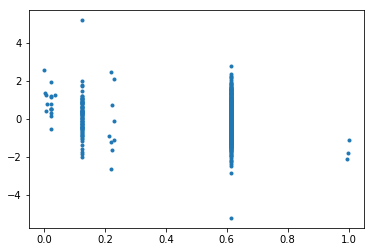

[[ 1.         -0.15776959]
 [-0.15776959  1.        ]]
TBX2
ETS2


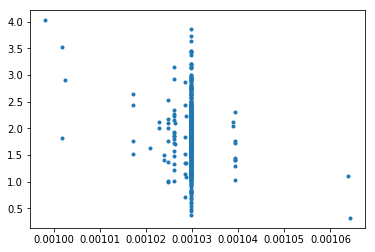

75 207 (445,)
[[ 1.         -0.20938224]
 [-0.20938224  1.        ]]


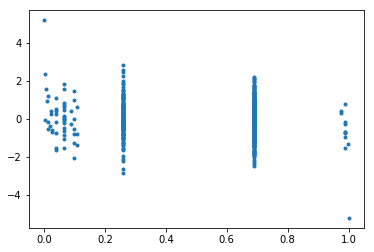

[[ 1.         -0.09644733]
 [-0.09644733  1.        ]]
MIXL1


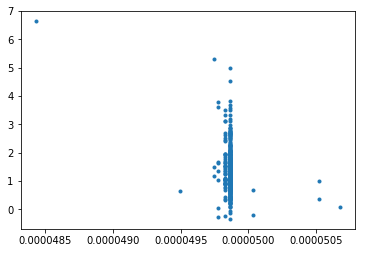

23 216 (445,)
[[ 1.         -0.30612601]
 [-0.30612601  1.        ]]


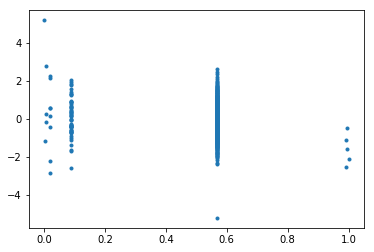

[[ 1.         -0.12168312]
 [-0.12168312  1.        ]]
REL


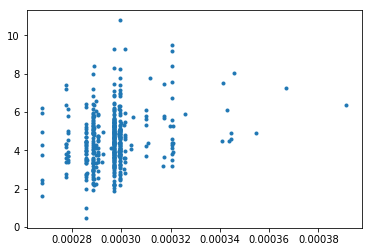

727 247 (445,)
[[1.         0.24628385]
 [0.24628385 1.        ]]


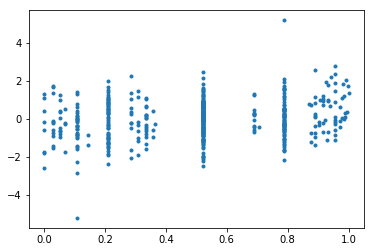

[[1.         0.21045315]
 [0.21045315 1.        ]]
POU4F3


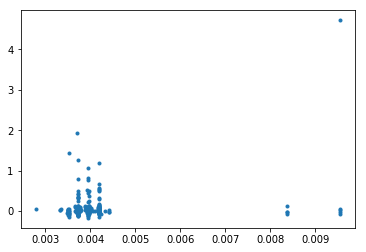

750 34 (445,)
[[1.         0.24617996]
 [0.24617996 1.        ]]


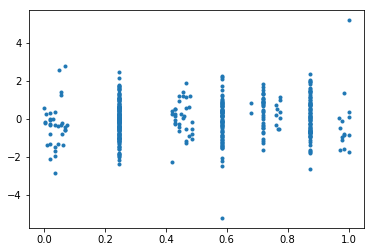

[[1.         0.09324396]
 [0.09324396 1.        ]]
ETV2


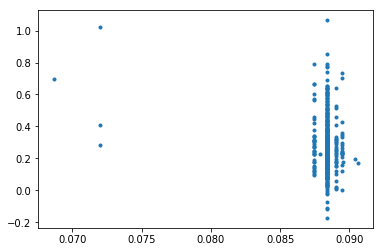

714 810 (445,)
[[ 1.         -0.18912448]
 [-0.18912448  1.        ]]


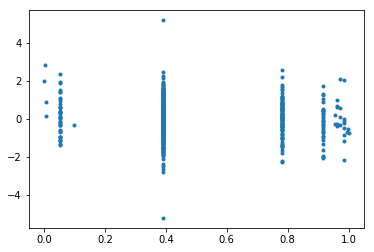

[[ 1.         -0.04939071]
 [-0.04939071  1.        ]]
EHF
FOXB1
LHX4


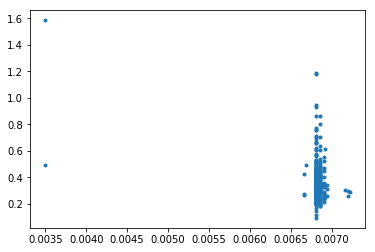

108 690 (445,)
[[ 1.         -0.32518713]
 [-0.32518713  1.        ]]


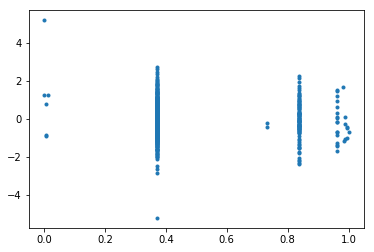

[[ 1.         -0.06540762]
 [-0.06540762  1.        ]]
HBP1


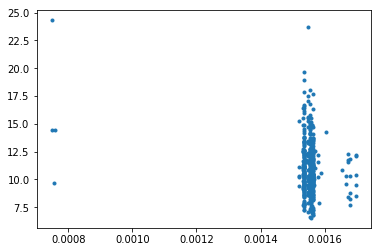

216 402 (445,)
[[ 1.         -0.20017197]
 [-0.20017197  1.        ]]


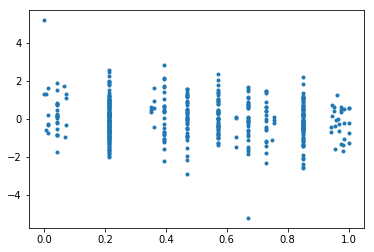

[[ 1.         -0.11870218]
 [-0.11870218  1.        ]]
SOX30


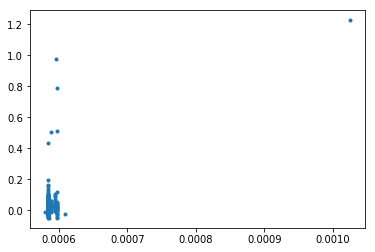

130 541 (445,)
[[1.         0.60983669]
 [0.60983669 1.        ]]


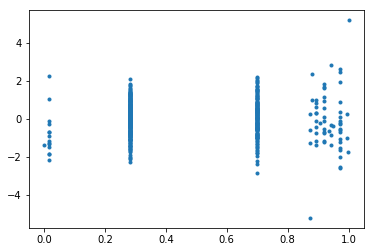

[[1.         0.04129028]
 [0.04129028 1.        ]]
ZNF8
E2F7


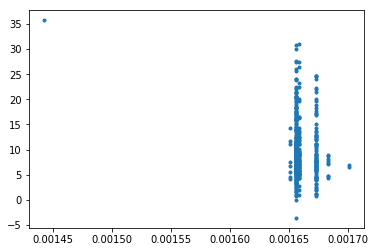

311 503 (445,)
[[ 1.         -0.20754881]
 [-0.20754881  1.        ]]


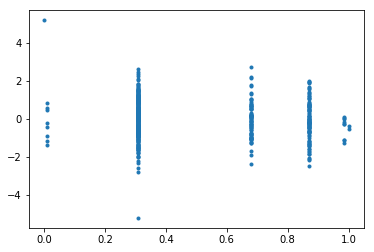

[[ 1.         -0.07943058]
 [-0.07943058  1.        ]]
VDR


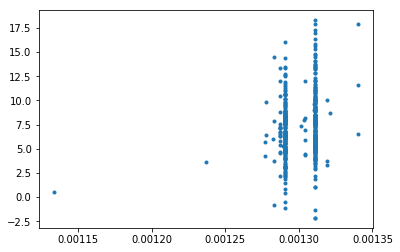

688 298 (445,)
[[1.         0.20621336]
 [0.20621336 1.        ]]


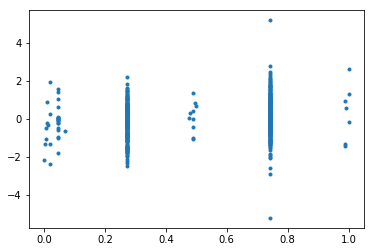

[[1.         0.15320523]
 [0.15320523 1.        ]]
RFX4
NFAT5


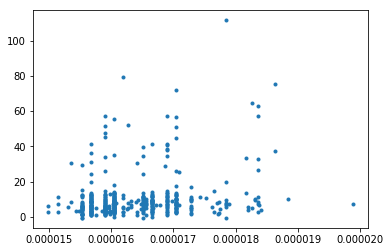

668 540 (445,)
[[1.         0.22413193]
 [0.22413193 1.        ]]


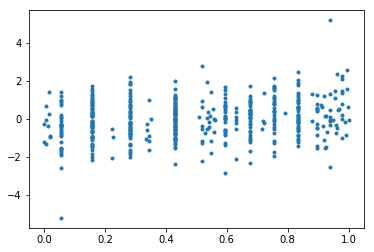

[[1.         0.21217074]
 [0.21217074 1.        ]]
ZNF410


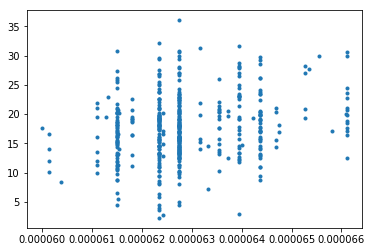

305 501 (445,)
[[1.         0.22587119]
 [0.22587119 1.        ]]


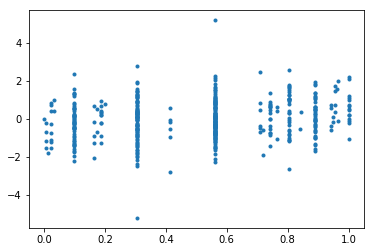

[[1.         0.19944781]
 [0.19944781 1.        ]]
HLX


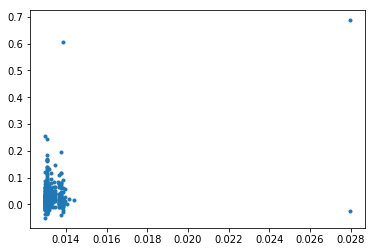

47 94 (445,)
[[1.         0.36579271]
 [0.36579271 1.        ]]


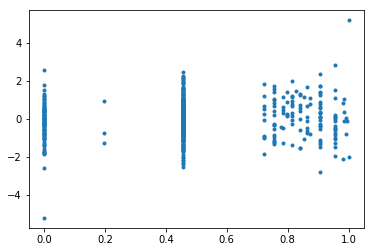

[[1.         0.10260965]
 [0.10260965 1.        ]]
ETV5


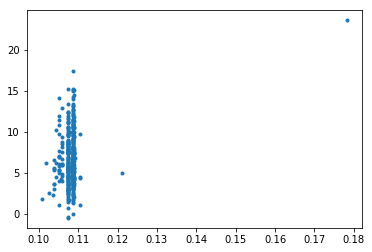

672 355 (445,)
[[1.         0.25929496]
 [0.25929496 1.        ]]


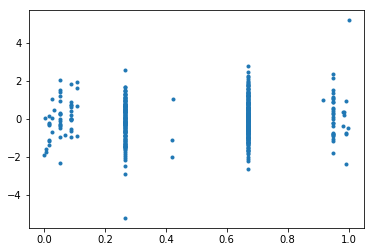

[[1.         0.08297576]
 [0.08297576 1.        ]]
SIX3


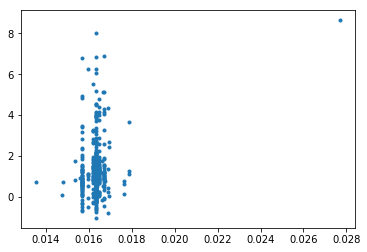

703 633 (445,)
[[1.         0.25256199]
 [0.25256199 1.        ]]


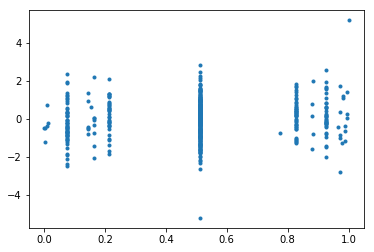

[[1.         0.10925645]
 [0.10925645 1.        ]]
NOTO
ZSCAN26


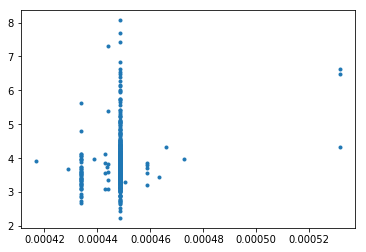

868 511 (445,)
[[1.         0.22790212]
 [0.22790212 1.        ]]


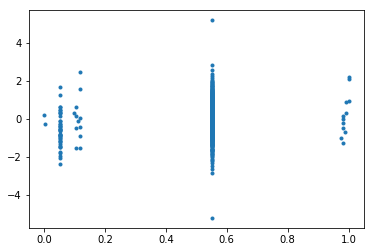

[[1.         0.16059327]
 [0.16059327 1.        ]]
GATA1
GTF2I
PTF1A
SMAD3


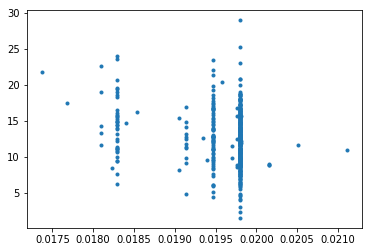

21 251 (445,)
[[ 1.         -0.19438354]
 [-0.19438354  1.        ]]


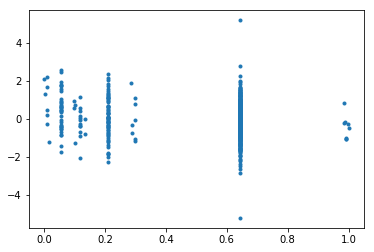

[[ 1.         -0.14918608]
 [-0.14918608  1.        ]]
PAX4
OTP


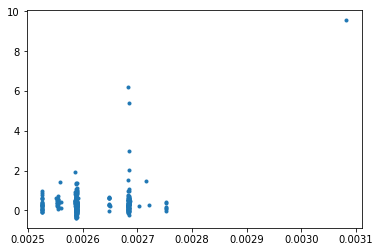

451 555 (445,)
[[1.         0.36845469]
 [0.36845469 1.        ]]


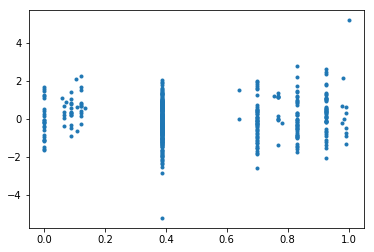

[[1.         0.05129797]
 [0.05129797 1.        ]]
CDC5L


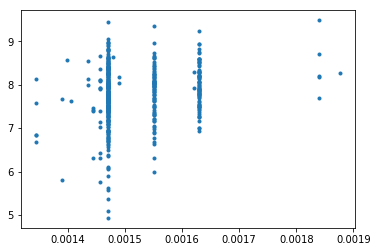

222 20 (445,)
[[1.         0.21872766]
 [0.21872766 1.        ]]


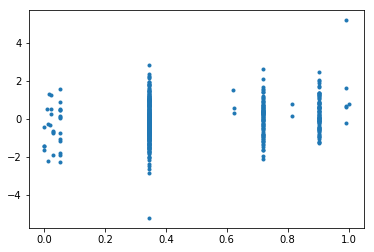

[[1.         0.20346121]
 [0.20346121 1.        ]]
CCDC6


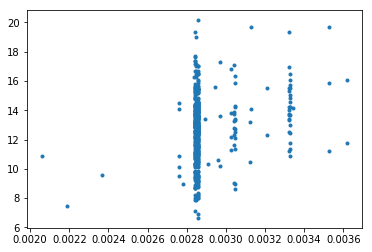

657 620 (445,)
[[1.         0.23209393]
 [0.23209393 1.        ]]


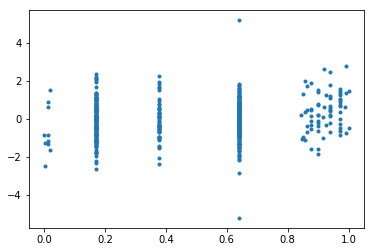

[[1.        0.1367043]
 [0.1367043 1.       ]]
CUX1


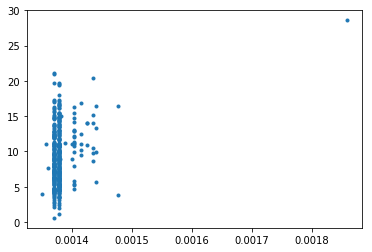

686 114 (445,)
[[1.         0.28611377]
 [0.28611377 1.        ]]


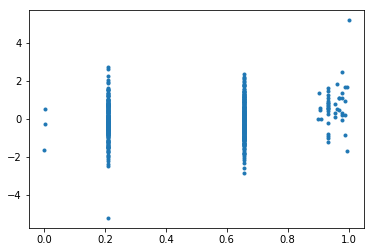

[[1.         0.14994539]
 [0.14994539 1.        ]]
PATZ1


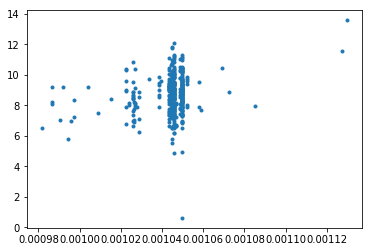

162 350 (445,)
[[1.         0.21585221]
 [0.21585221 1.        ]]


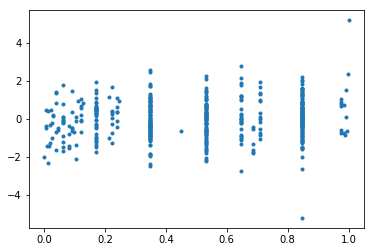

[[1.         0.11547612]
 [0.11547612 1.        ]]
HIC2


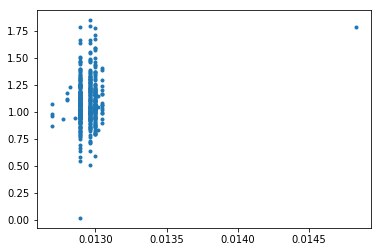

183 50 (445,)
[[1.         0.17794447]
 [0.17794447 1.        ]]


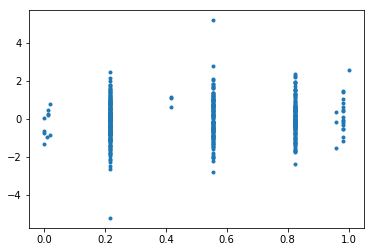

[[1.        0.0802426]
 [0.0802426 1.       ]]
GFI1B


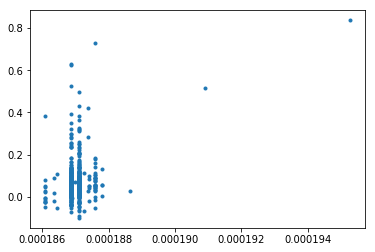

516 594 (445,)
[[1.         0.35745665]
 [0.35745665 1.        ]]


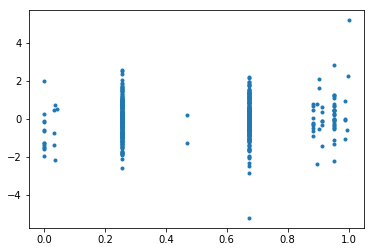

[[1.         0.09038849]
 [0.09038849 1.        ]]
PAX9


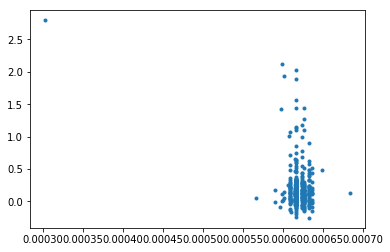

702 236 (445,)
[[ 1.         -0.35598347]
 [-0.35598347  1.        ]]


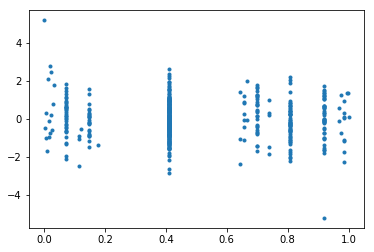

[[ 1.         -0.04752738]
 [-0.04752738  1.        ]]
TFCP2


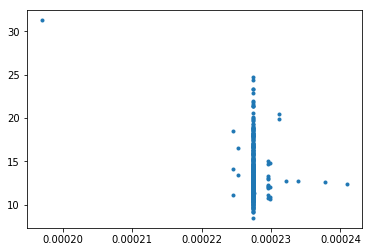

919 555 (445,)
[[ 1.         -0.25067575]
 [-0.25067575  1.        ]]


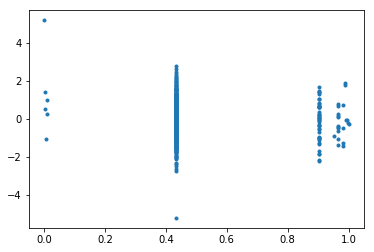

[[ 1.         -0.07291885]
 [-0.07291885  1.        ]]
BRCA1


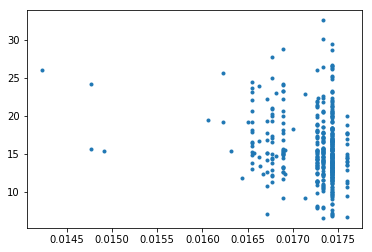

72 819 (445,)
[[ 1.         -0.20424377]
 [-0.20424377  1.        ]]


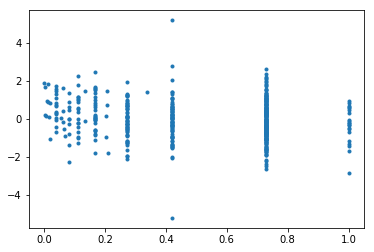

[[ 1.         -0.15177964]
 [-0.15177964  1.        ]]
SCRT1
ZKSCAN3


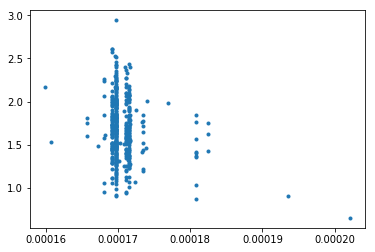

796 631 (445,)
[[ 1.         -0.21505121]
 [-0.21505121  1.        ]]


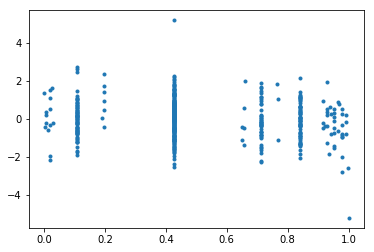

[[ 1.        -0.1283853]
 [-0.1283853  1.       ]]
FOXG1


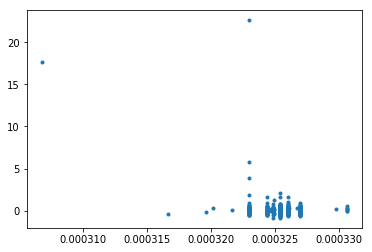

246 358 (445,)
[[ 1.         -0.35612949]
 [-0.35612949  1.        ]]


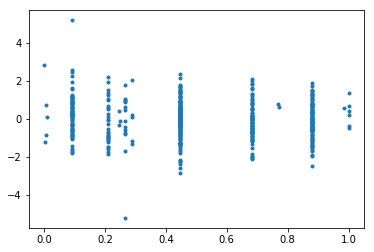

[[ 1.         -0.07611277]
 [-0.07611277  1.        ]]
E2F8


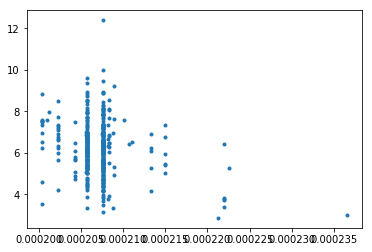

761 243 (445,)
[[ 1.         -0.24524817]
 [-0.24524817  1.        ]]


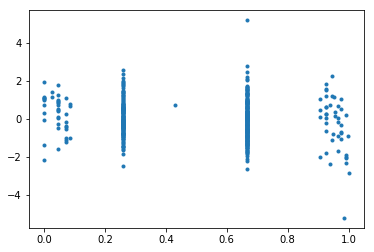

[[ 1.         -0.12980912]
 [-0.12980912  1.        ]]
ZBTB16
TCF21
ZNF628


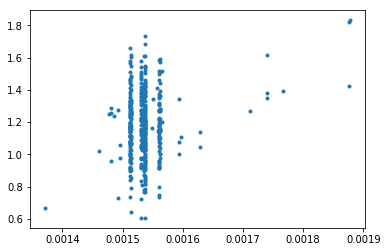

618 140 (445,)
[[1.         0.23032364]
 [0.23032364 1.        ]]


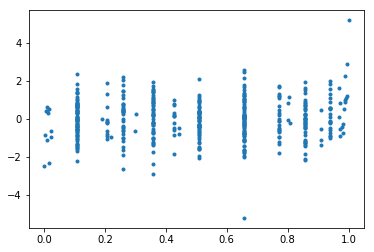

[[1.         0.07091181]
 [0.07091181 1.        ]]
CRX
RBPJ


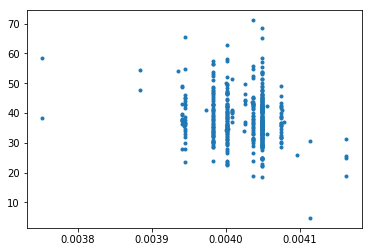

722 383 (445,)
[[ 1.         -0.20255849]
 [-0.20255849  1.        ]]


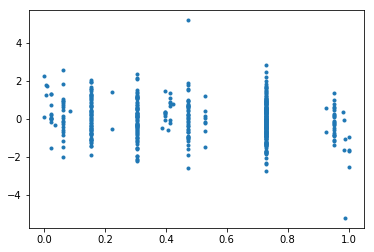

[[ 1.        -0.1591791]
 [-0.1591791  1.       ]]
RARB


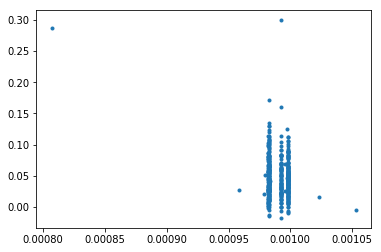

351 792 (445,)
[[ 1.         -0.29760153]
 [-0.29760153  1.        ]]


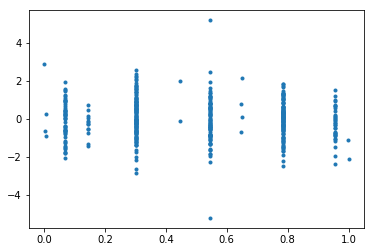

[[ 1.         -0.05193739]
 [-0.05193739  1.        ]]
HOXB9


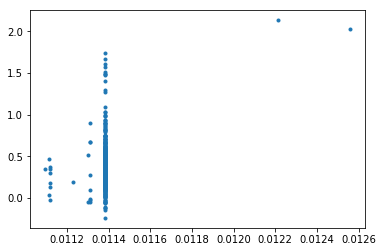

1 820 (445,)
[[1.         0.35525904]
 [0.35525904 1.        ]]


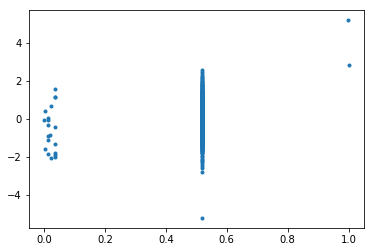

[[1.         0.18484634]
 [0.18484634 1.        ]]
CDX2
HOXB4


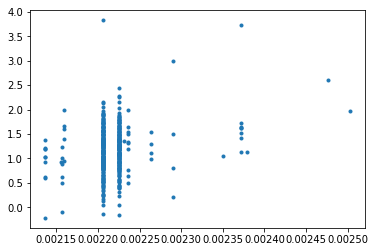

46 249 (445,)
[[1.         0.24165987]
 [0.24165987 1.        ]]


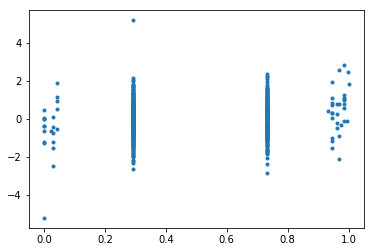

[[1.         0.13938308]
 [0.13938308 1.        ]]
MSX2
HES5


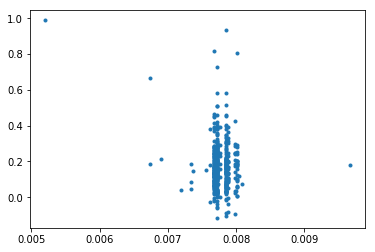

200 398 (445,)
[[ 1.         -0.20774812]
 [-0.20774812  1.        ]]


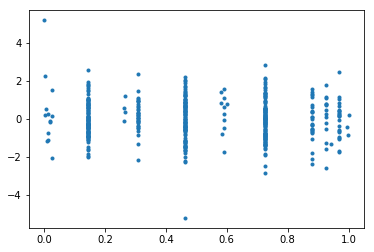

[[ 1.         -0.04828714]
 [-0.04828714  1.        ]]
NR5A1


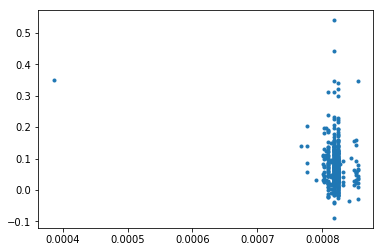

44 297 (445,)
[[ 1.         -0.19815756]
 [-0.19815756  1.        ]]


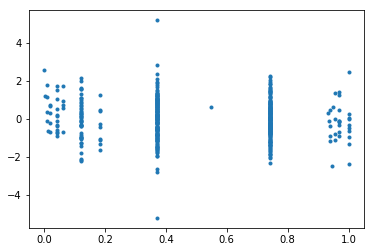

[[ 1.         -0.07626024]
 [-0.07626024  1.        ]]
RFX5


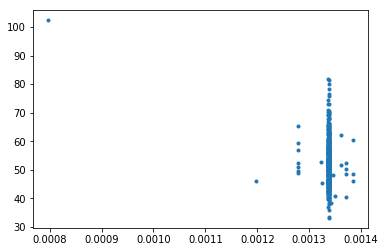

362 232 (445,)
[[ 1.         -0.26274932]
 [-0.26274932  1.        ]]


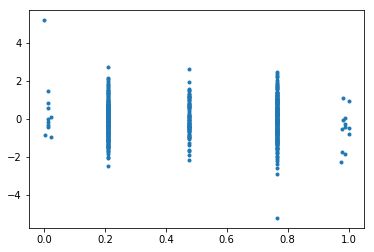

[[ 1.         -0.04809334]
 [-0.04809334  1.        ]]
HSFY2
TFCP2L1


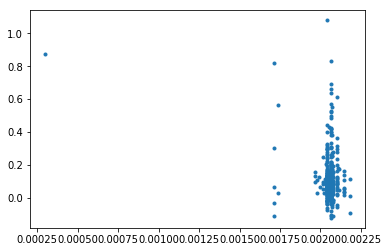

838 368 (445,)
[[ 1.        -0.2681426]
 [-0.2681426  1.       ]]


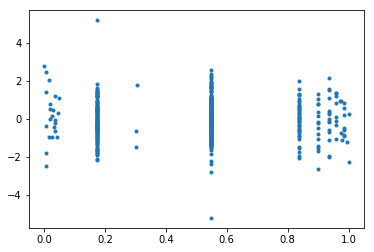

[[ 1.         -0.01656772]
 [-0.01656772  1.        ]]
ZSCAN16


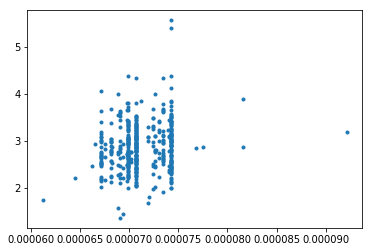

156 142 (445,)
[[1.         0.18082526]
 [0.18082526 1.        ]]


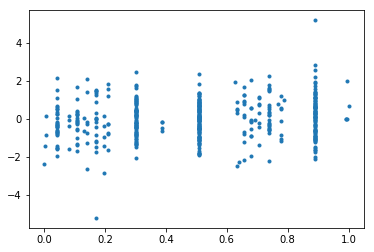

[[1.         0.16177079]
 [0.16177079 1.        ]]
POU6F1


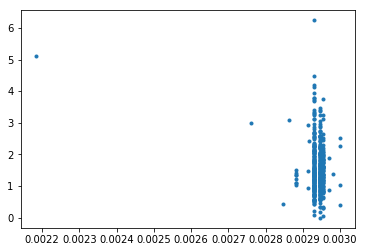

362 381 (445,)
[[ 1.         -0.21413056]
 [-0.21413056  1.        ]]


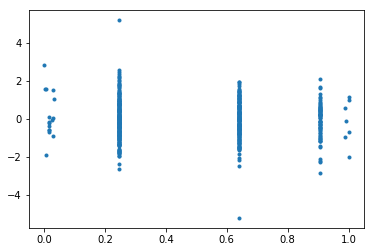

[[ 1.         -0.06273545]
 [-0.06273545  1.        ]]
NKX3-2
ARX


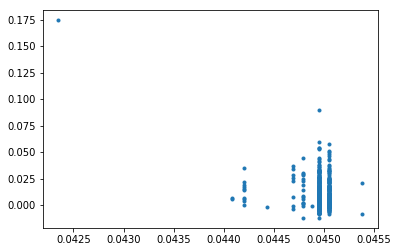

895 712 (445,)
[[ 1.         -0.33551089]
 [-0.33551089  1.        ]]


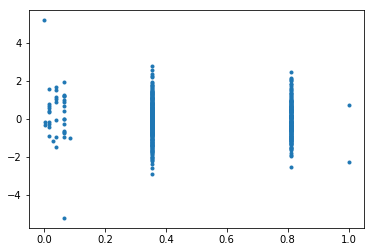

[[ 1.         -0.04299163]
 [-0.04299163  1.        ]]
PAX2
SP1


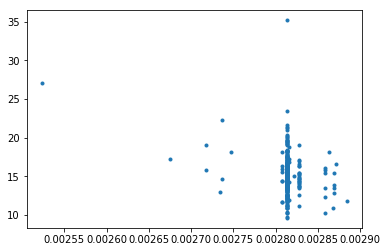

13 182 (445,)
[[ 1.         -0.27217102]
 [-0.27217102  1.        ]]


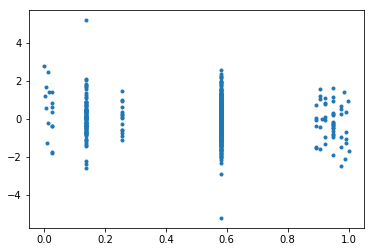

[[ 1.         -0.10826677]
 [-0.10826677  1.        ]]
ONECUT1
GSC
MZF1


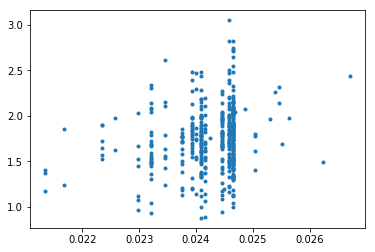

593 888 (445,)
[[1.         0.19012627]
 [0.19012627 1.        ]]


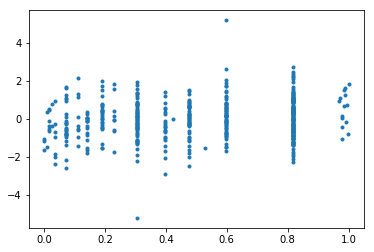

[[1.         0.16147828]
 [0.16147828 1.        ]]
ZIC2
HNF1B
GLIS3


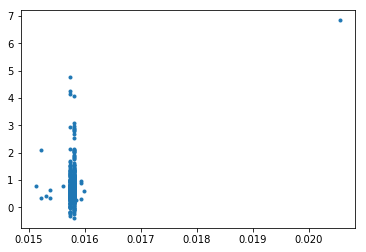

275 64 (445,)
[[1.         0.40460206]
 [0.40460206 1.        ]]


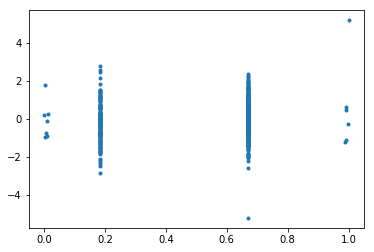

[[1.         0.11236382]
 [0.11236382 1.        ]]
PITX1


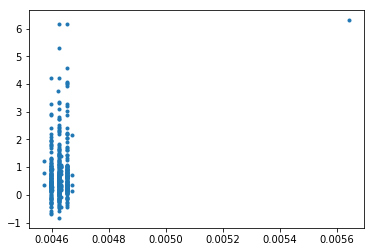

183 212 (445,)
[[1.         0.27553126]
 [0.27553126 1.        ]]


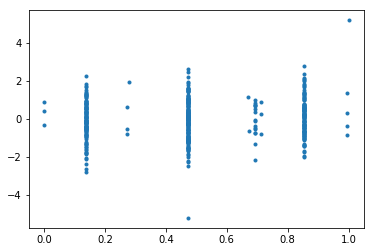

[[1.         0.09257792]
 [0.09257792 1.        ]]
ISL2


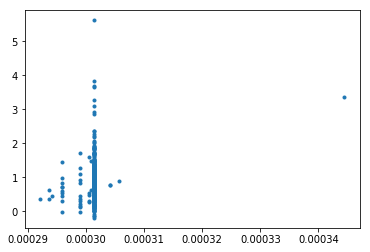

920 420 (445,)
[[1.         0.21980506]
 [0.21980506 1.        ]]


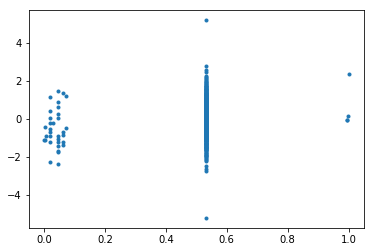

[[1.         0.14844073]
 [0.14844073 1.        ]]
SOX15


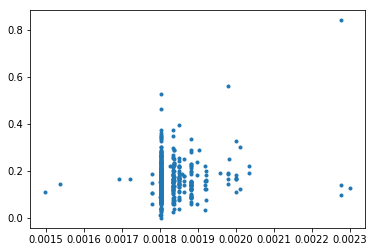

214 131 (445,)
[[1.         0.16817652]
 [0.16817652 1.        ]]


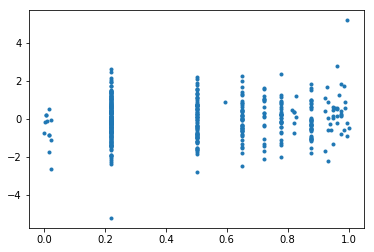

[[1.         0.07744841]
 [0.07744841 1.        ]]
IKZF3


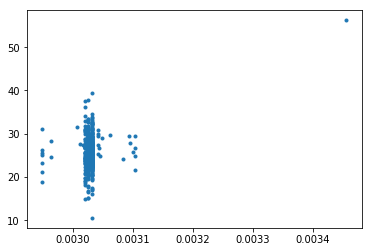

633 274 (445,)
[[1.         0.31543893]
 [0.31543893 1.        ]]


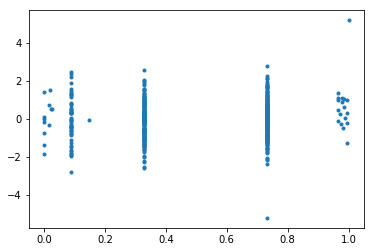

[[1.        0.0607487]
 [0.0607487 1.       ]]
GSC2
RUNX1


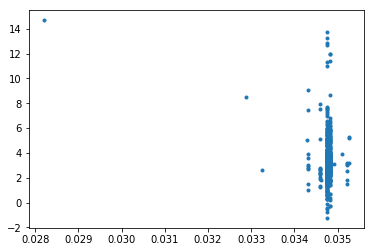

297 417 (445,)
[[ 1.         -0.25069292]
 [-0.25069292  1.        ]]


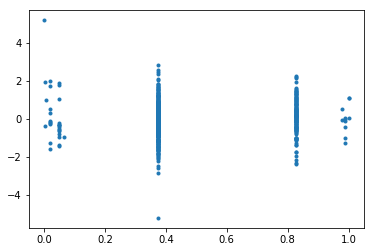

[[1.         0.06759058]
 [0.06759058 1.        ]]
RORA


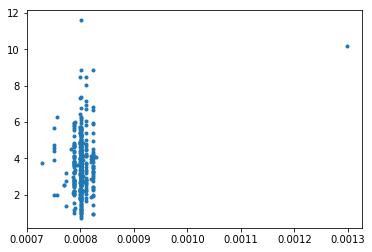

703 534 (445,)
[[1.         0.20338662]
 [0.20338662 1.        ]]


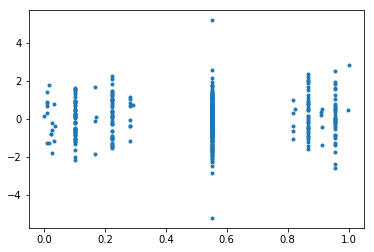

[[1.         0.02796662]
 [0.02796662 1.        ]]
RREB1


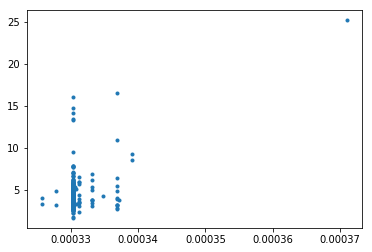

922 242 (445,)
[[1.         0.50804222]
 [0.50804222 1.        ]]


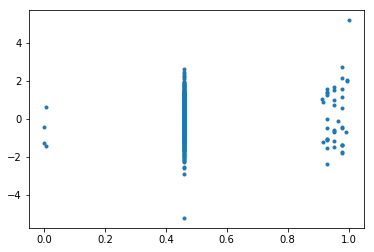

[[1.        0.0766049]
 [0.0766049 1.       ]]
TP53


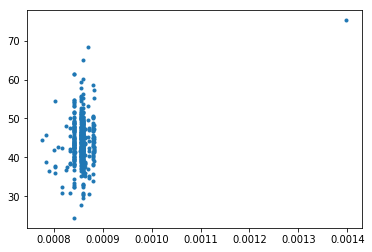

37 285 (445,)
[[1.         0.25247796]
 [0.25247796 1.        ]]


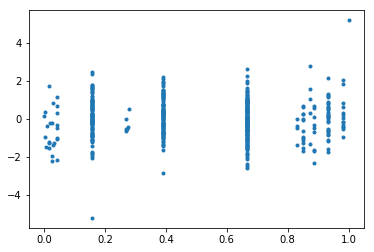

[[1.        0.0190409]
 [0.0190409 1.       ]]
TCF7


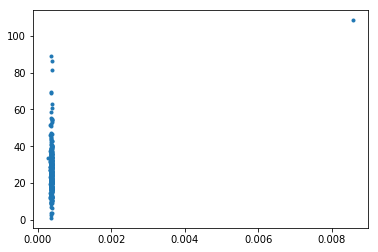

425 388 (445,)
[[1.         0.33567655]
 [0.33567655 1.        ]]


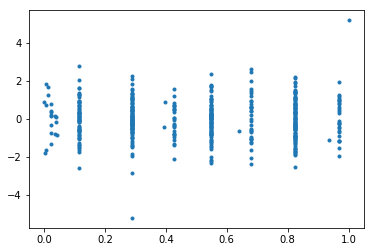

[[1.         0.01042429]
 [0.01042429 1.        ]]
RXRB
FOXO4


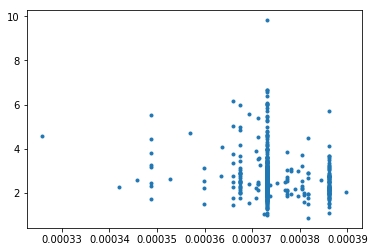

708 640 (445,)
[[ 1.         -0.17536488]
 [-0.17536488  1.        ]]


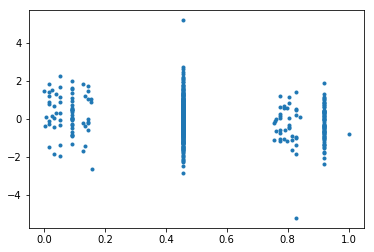

[[ 1.         -0.17255167]
 [-0.17255167  1.        ]]
ZIC4
NKX2-1
HOXB2


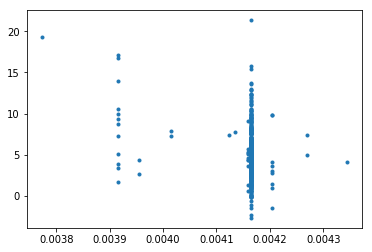

922 20 (445,)
[[ 1.        -0.2410585]
 [-0.2410585  1.       ]]


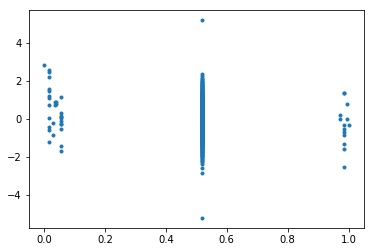

[[ 1.         -0.13120101]
 [-0.13120101  1.        ]]
HOXC5


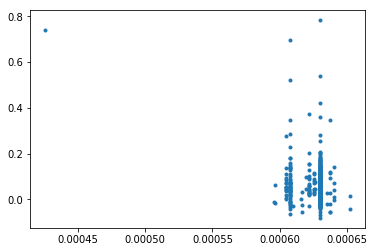

68 438 (445,)
[[ 1.         -0.29238797]
 [-0.29238797  1.        ]]


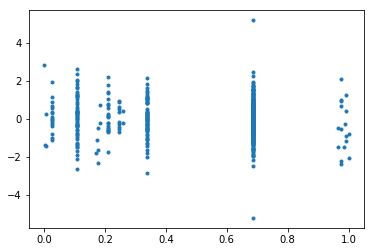

[[ 1.        -0.0609209]
 [-0.0609209  1.       ]]
GMEB2


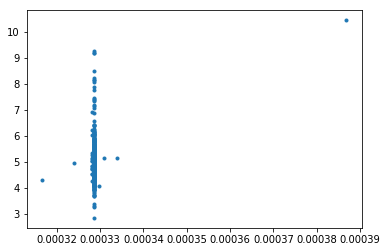

4 193 (445,)
[[1.         0.29219974]
 [0.29219974 1.        ]]


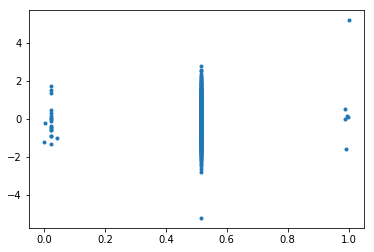

[[1.         0.05944576]
 [0.05944576 1.        ]]
CTCF


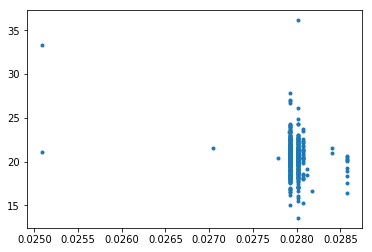

893 696 (445,)
[[ 1.         -0.23738781]
 [-0.23738781  1.        ]]


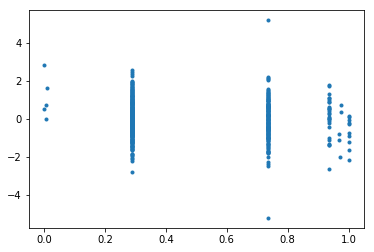

[[ 1.         -0.08364162]
 [-0.08364162  1.        ]]
TBX1
ZNF281


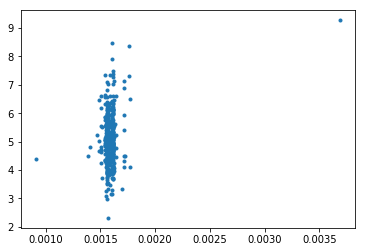

658 731 (445,)
[[1.         0.24501736]
 [0.24501736 1.        ]]


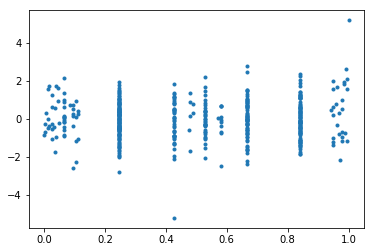

[[1.        0.0602159]
 [0.0602159 1.       ]]
LMO2


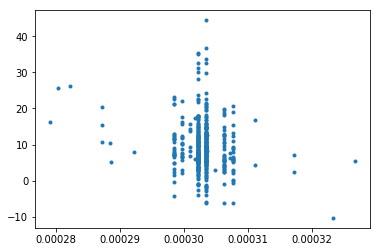

647 428 (445,)
[[ 1.         -0.19510685]
 [-0.19510685  1.        ]]


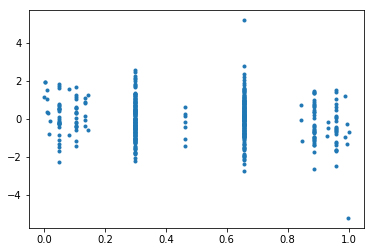

[[ 1.         -0.12532268]
 [-0.12532268  1.        ]]
HINFP


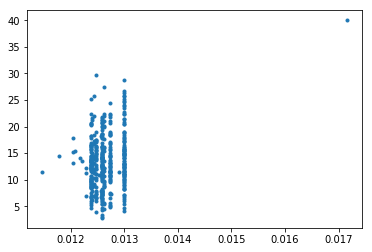

139 63 (445,)
[[1.         0.26978282]
 [0.26978282 1.        ]]


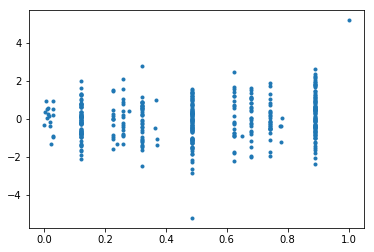

[[1.         0.13157977]
 [0.13157977 1.        ]]
CREB3L1


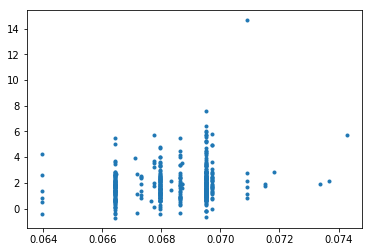

98 880 (445,)
[[1.         0.18805547]
 [0.18805547 1.        ]]


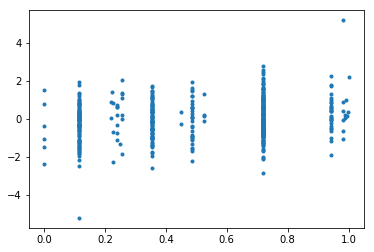

[[1.         0.18511992]
 [0.18511992 1.        ]]
SOX11
FOXJ1


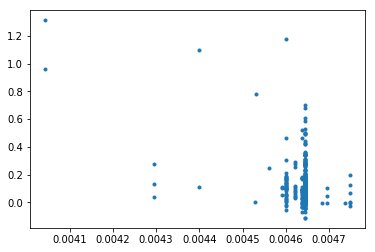

723 105 (445,)
[[ 1.         -0.42440476]
 [-0.42440476  1.        ]]


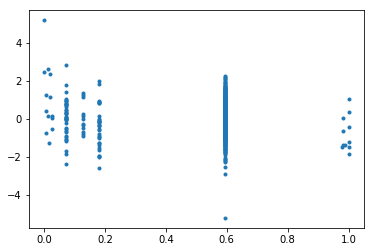

[[ 1.         -0.07749859]
 [-0.07749859  1.        ]]
HOXB13
STAT1


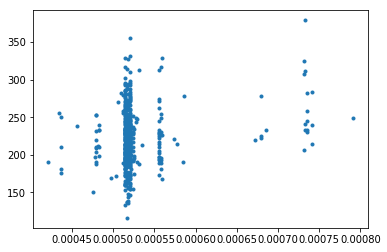

661 329 (445,)
[[1.         0.21114869]
 [0.21114869 1.        ]]


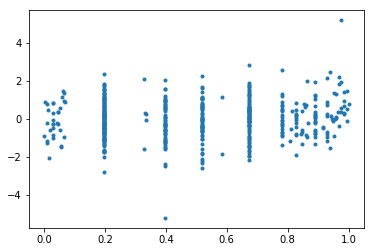

[[1.         0.11090093]
 [0.11090093 1.        ]]
TCF4


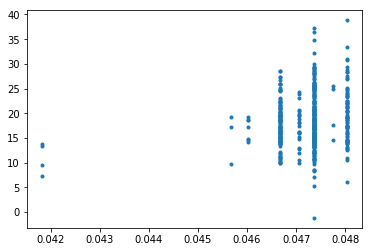

542 112 (445,)
[[1.         0.18737945]
 [0.18737945 1.        ]]


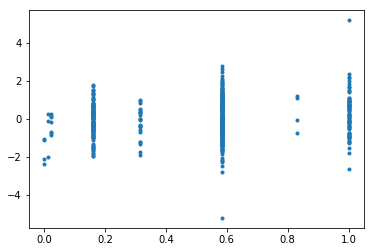

[[1.         0.14224182]
 [0.14224182 1.        ]]
FOXI1
SIX4


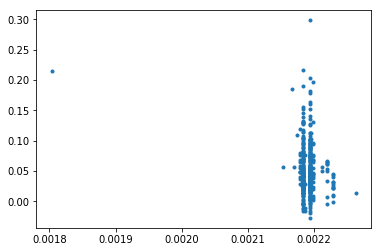

131 299 (445,)
[[ 1.        -0.2201099]
 [-0.2201099  1.       ]]


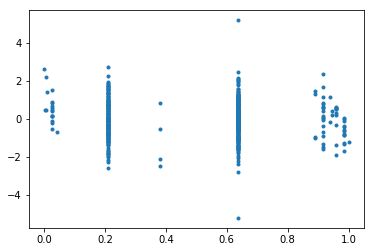

[[ 1.         -0.06304397]
 [-0.06304397  1.        ]]
ELF3


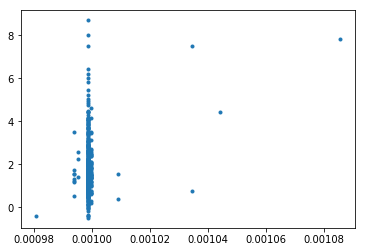

23 531 (445,)
[[1.         0.25847019]
 [0.25847019 1.        ]]


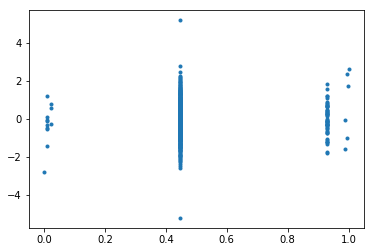

[[1.         0.03773519]
 [0.03773519 1.        ]]
FOXD1
DMRT3
HOXC4


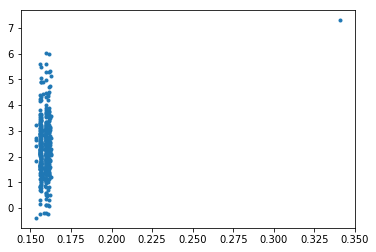

272 4 (445,)
[[1.         0.22309764]
 [0.22309764 1.        ]]


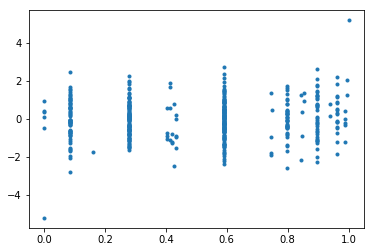

[[1.         0.07803416]
 [0.07803416 1.        ]]
HOXC9
NFE2L1


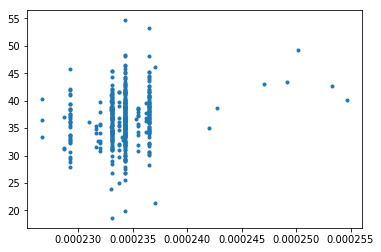

42 525 (445,)
[[1.         0.20439582]
 [0.20439582 1.        ]]


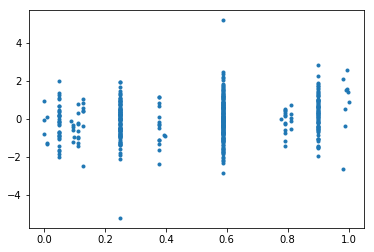

[[1.         0.18034176]
 [0.18034176 1.        ]]
POU5F1B


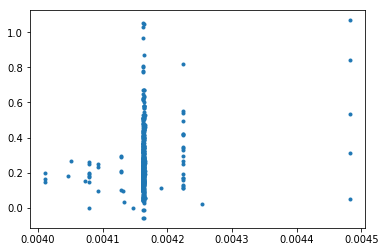

856 80 (445,)
[[1.         0.20691135]
 [0.20691135 1.        ]]


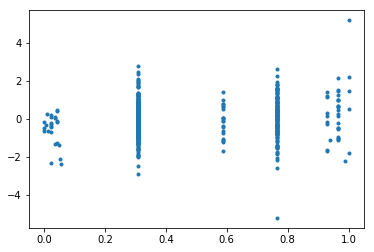

[[1.         0.13644623]
 [0.13644623 1.        ]]
ZNF589


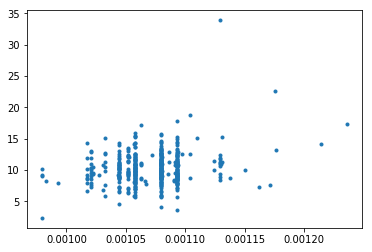

659 852 (445,)
[[1.         0.22238659]
 [0.22238659 1.        ]]


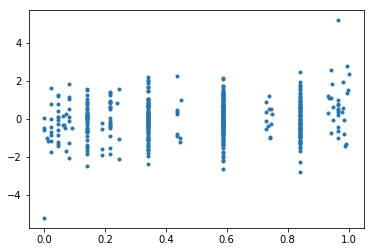

[[1.         0.14697681]
 [0.14697681 1.        ]]
HOXA1


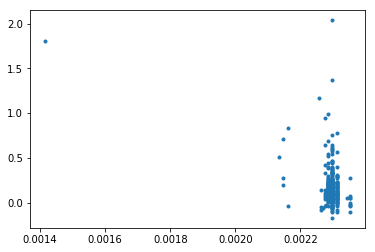

797 805 (445,)
[[ 1.         -0.42594346]
 [-0.42594346  1.        ]]


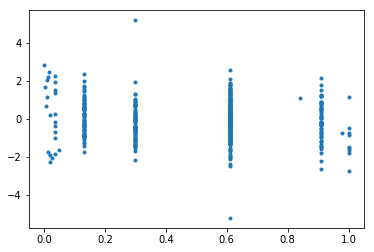

[[ 1.         -0.08646023]
 [-0.08646023  1.        ]]
ZNF282


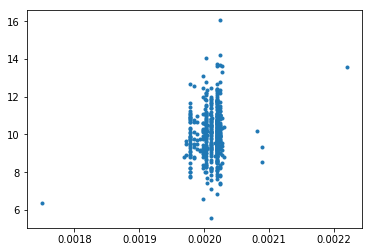

849 494 (445,)
[[1.         0.17417736]
 [0.17417736 1.        ]]


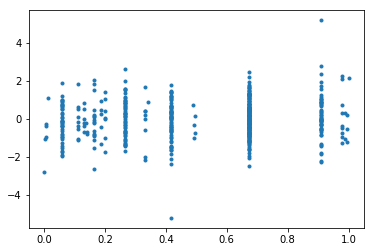

[[1.        0.0977483]
 [0.0977483 1.       ]]
ERF


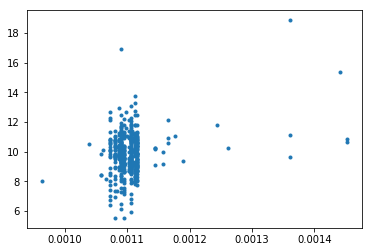

618 146 (445,)
[[1.         0.25759239]
 [0.25759239 1.        ]]


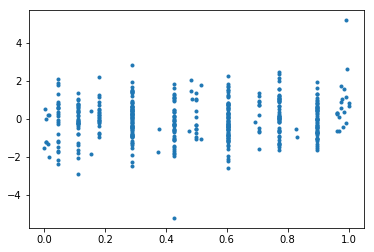

[[1.       0.106904]
 [0.106904 1.      ]]
GMEB1


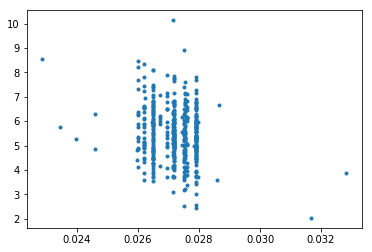

197 195 (445,)
[[ 1.         -0.21615693]
 [-0.21615693  1.        ]]


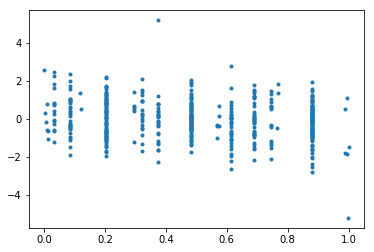

[[ 1.        -0.1719392]
 [-0.1719392  1.       ]]
FOXM1


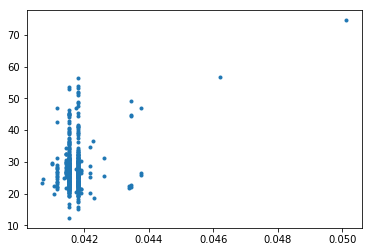

917 843 (445,)
[[1.         0.32306346]
 [0.32306346 1.        ]]


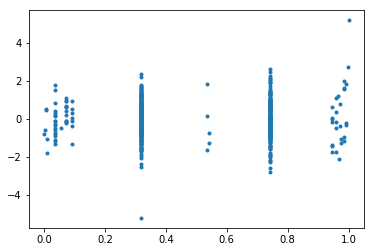

[[1.         0.02090861]
 [0.02090861 1.        ]]
TFAP2E


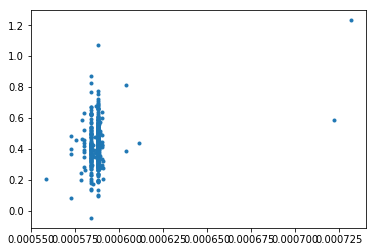

264 659 (445,)
[[1.        0.2691713]
 [0.2691713 1.       ]]


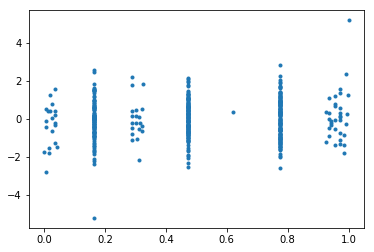

[[1.         0.07843368]
 [0.07843368 1.        ]]
HOXB7


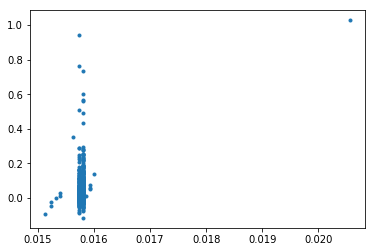

275 64 (445,)
[[1.         0.39039771]
 [0.39039771 1.        ]]


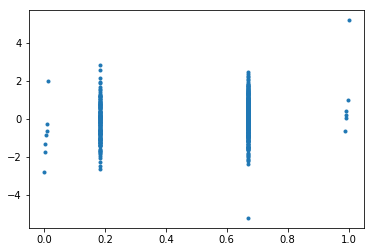

[[1.         0.14463771]
 [0.14463771 1.        ]]
NKX1-2
SP8
DMRT1


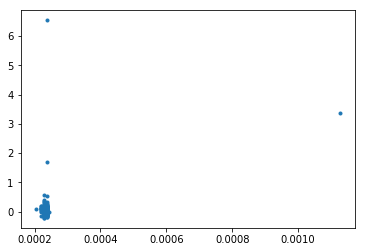

426 286 (445,)
[[1.         0.43293211]
 [0.43293211 1.        ]]


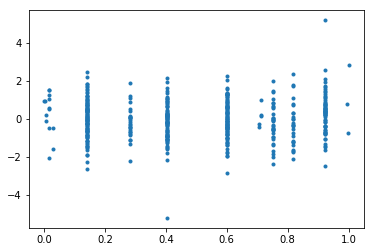

[[1.        0.0453292]
 [0.0453292 1.       ]]
TBR1
ID4
ATF1


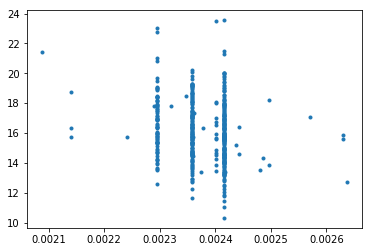

237 383 (445,)
[[ 1.         -0.19631642]
 [-0.19631642  1.        ]]


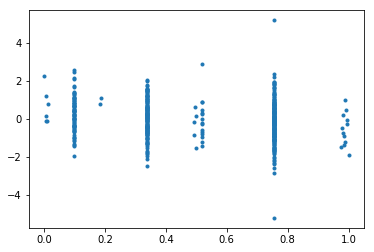

[[ 1.         -0.18369971]
 [-0.18369971  1.        ]]
LHX9
EOMES


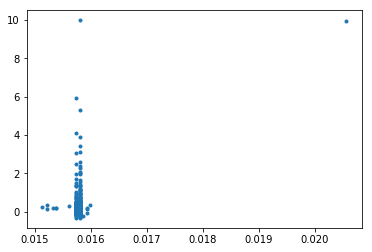

275 64 (445,)
[[1.        0.4788946]
 [0.4788946 1.       ]]


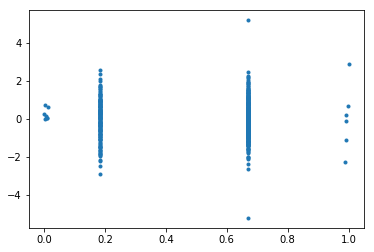

[[ 1.         -0.00979727]
 [-0.00979727  1.        ]]
REST


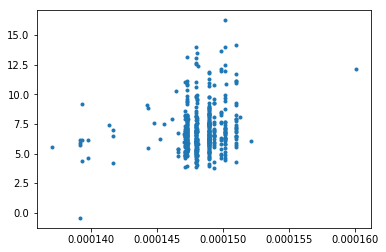

201 740 (445,)
[[1.         0.21280643]
 [0.21280643 1.        ]]


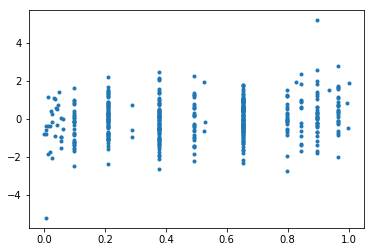

[[1.         0.18792194]
 [0.18792194 1.        ]]
CDX1
EMX1


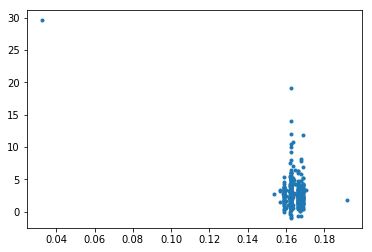

702 107 (445,)
[[ 1.         -0.48256411]
 [-0.48256411  1.        ]]


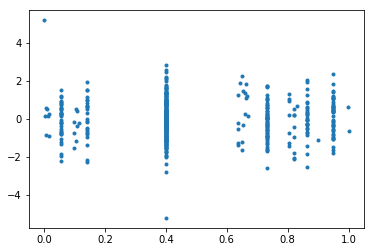

[[ 1.         -0.00366903]
 [-0.00366903  1.        ]]
NKX2-8
POU2F2


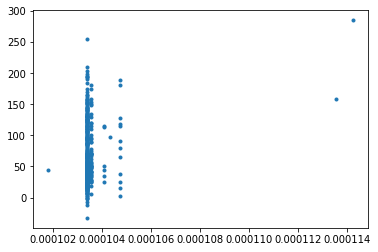

7 606 (445,)
[[1.         0.22460087]
 [0.22460087 1.        ]]


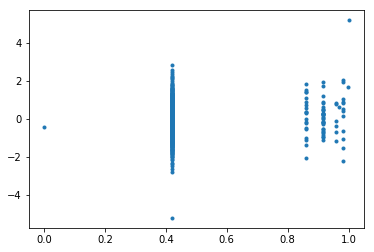

[[1.         0.09857648]
 [0.09857648 1.        ]]
FOXP3


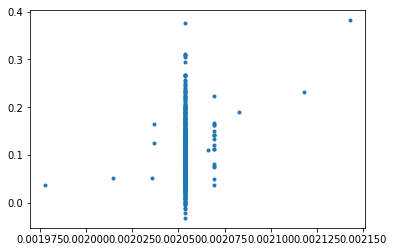

4 553 (445,)
[[1.        0.2067632]
 [0.2067632 1.       ]]


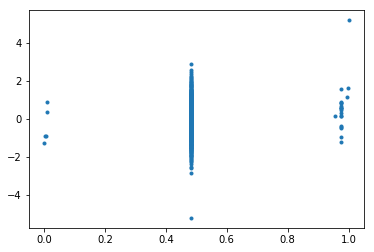

[[1.         0.13216885]
 [0.13216885 1.        ]]
SIX6
RUNX3


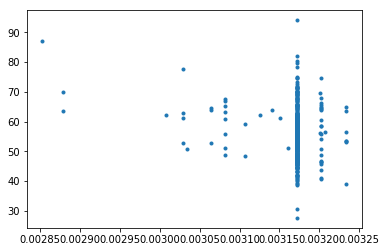

0 241 (445,)
[[ 1.       -0.192998]
 [-0.192998  1.      ]]


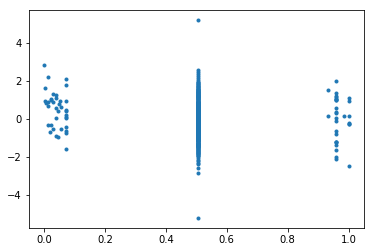

[[ 1.         -0.10707588]
 [-0.10707588  1.        ]]
RARG


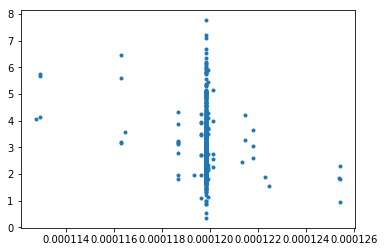

9 524 (445,)
[[ 1.         -0.20019308]
 [-0.20019308  1.        ]]


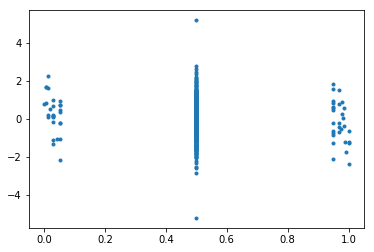

[[ 1.        -0.0866921]
 [-0.0866921  1.       ]]
ALX1
ZNF740


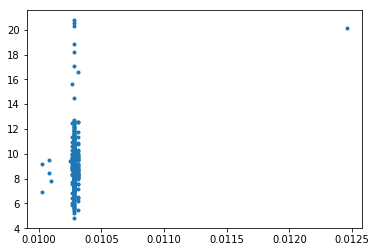

693 632 (445,)
[[1.         0.25732013]
 [0.25732013 1.        ]]


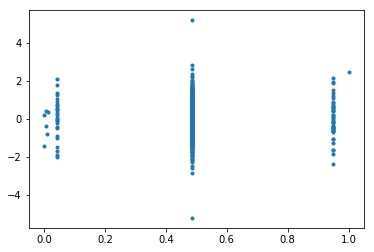

[[1.         0.01907101]
 [0.01907101 1.        ]]
BARHL2
PLAG1


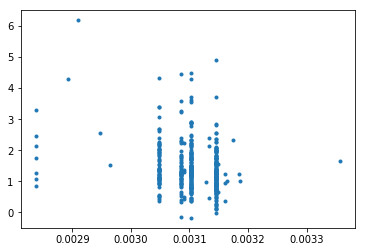

636 316 (445,)
[[ 1.         -0.22607571]
 [-0.22607571  1.        ]]


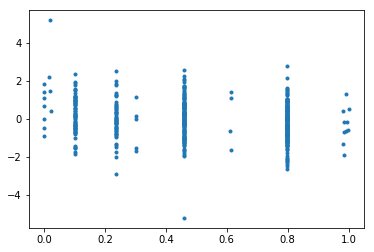

[[ 1.        -0.1764843]
 [-0.1764843  1.       ]]
RHOXF2
RHOXF1


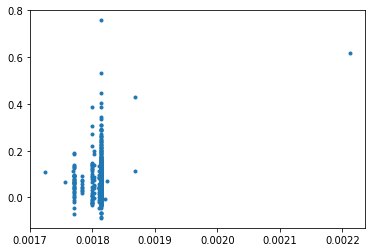

713 384 (445,)
[[1.         0.27624828]
 [0.27624828 1.        ]]


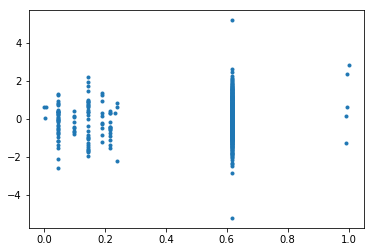

[[1.         0.09086369]
 [0.09086369 1.        ]]
THRA


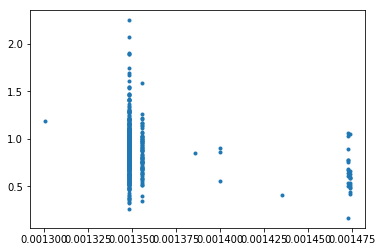

17 66 (445,)
[[ 1.         -0.22370505]
 [-0.22370505  1.        ]]


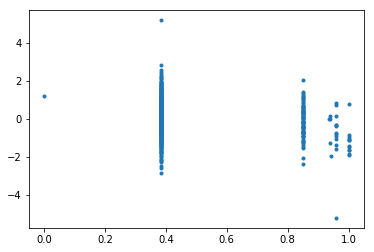

[[ 1.         -0.19972417]
 [-0.19972417  1.        ]]
EGR3


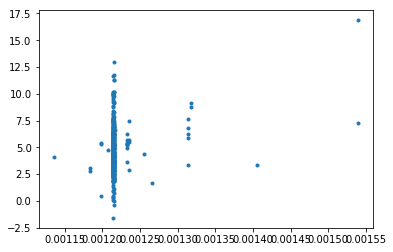

825 399 (445,)
[[1.         0.22678439]
 [0.22678439 1.        ]]


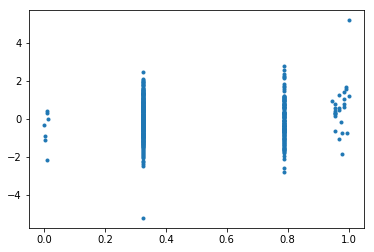

[[1.         0.03472256]
 [0.03472256 1.        ]]
FIGLA
NKX1-1
LEF1


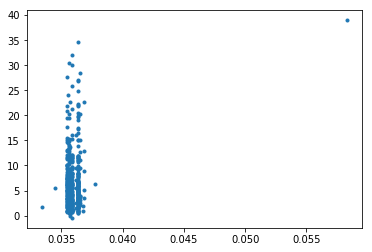

457 9 (445,)
[[1.         0.24832394]
 [0.24832394 1.        ]]


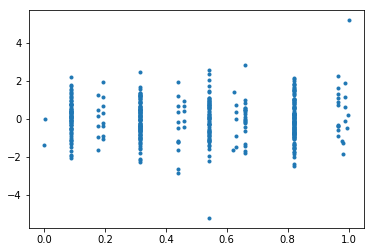

[[1.         0.01048602]
 [0.01048602 1.        ]]
HOXB8
SOX5


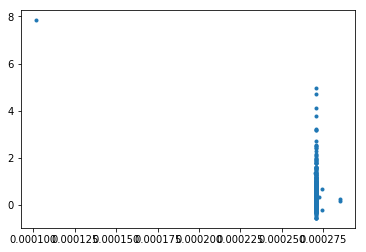

815 478 (445,)
[[ 1.         -0.45306161]
 [-0.45306161  1.        ]]


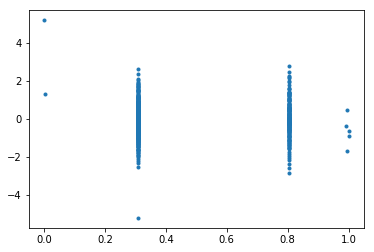

[[ 1.        -0.0247609]
 [-0.0247609  1.       ]]
HOXB5
EGR1


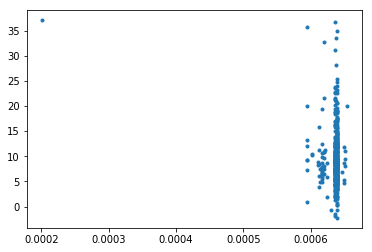

837 194 (445,)
[[ 1.       -0.225088]
 [-0.225088  1.      ]]


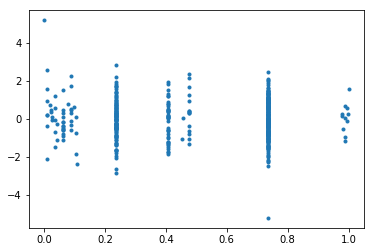

[[ 1.         -0.02685101]
 [-0.02685101  1.        ]]
DMRTA1
NR1H4


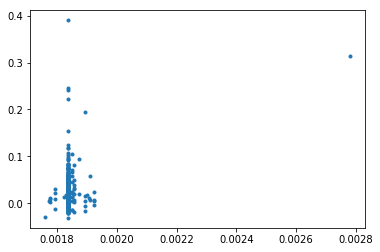

9 356 (445,)
[[1.         0.34083274]
 [0.34083274 1.        ]]


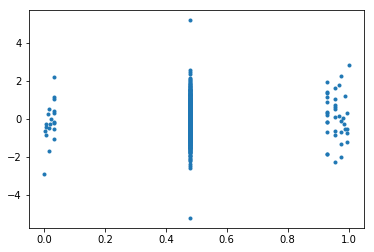

[[1.         0.05242533]
 [0.05242533 1.        ]]
ZBED1


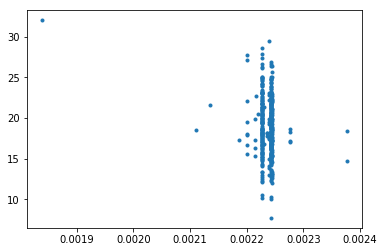

671 560 (445,)
[[ 1.         -0.20236377]
 [-0.20236377  1.        ]]


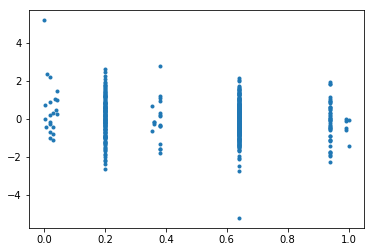

[[ 1.         -0.12534556]
 [-0.12534556  1.        ]]
ARHGEF12


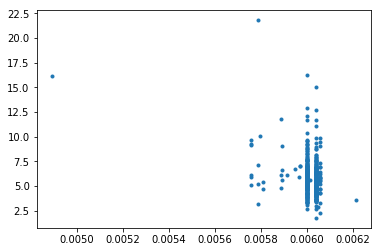

686 677 (445,)
[[ 1.         -0.31804403]
 [-0.31804403  1.        ]]


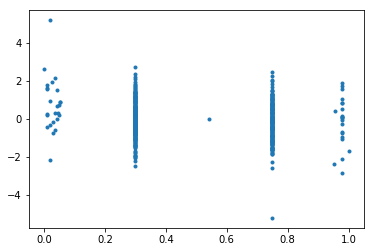

[[ 1.         -0.14672402]
 [-0.14672402  1.        ]]
CREB3


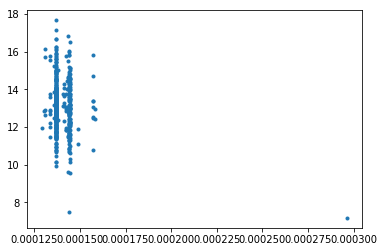

847 246 (445,)
[[ 1.         -0.21084819]
 [-0.21084819  1.        ]]


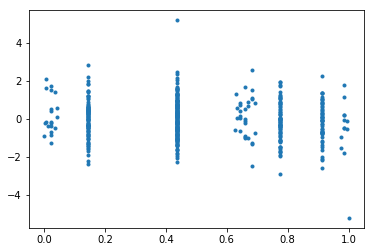

[[ 1.         -0.09091191]
 [-0.09091191  1.        ]]
SPDEF


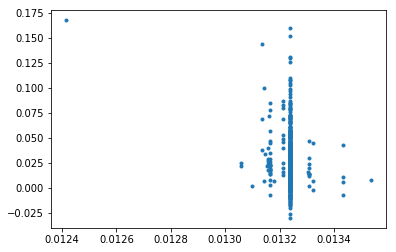

0 451 (445,)
[[ 1.         -0.22814519]
 [-0.22814519  1.        ]]


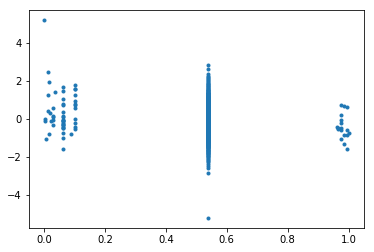

[[ 1.         -0.14756281]
 [-0.14756281  1.        ]]
OSR2


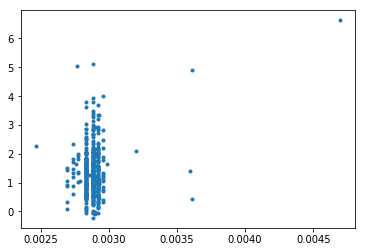

205 584 (445,)
[[1.         0.26522884]
 [0.26522884 1.        ]]


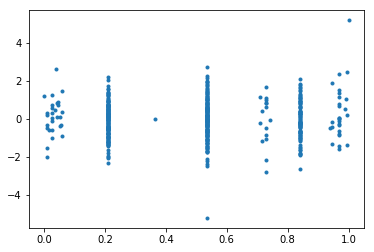

[[1.         0.03349968]
 [0.03349968 1.        ]]
IRF6


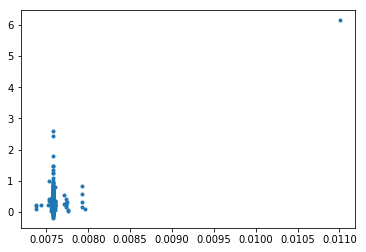

9 299 (445,)
[[1.         0.67531494]
 [0.67531494 1.        ]]


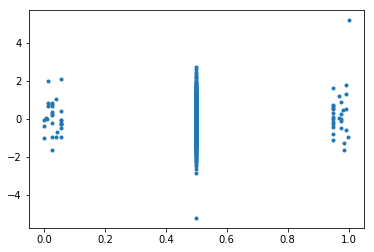

[[1.        0.0397024]
 [0.0397024 1.       ]]
DPRX
ELF2


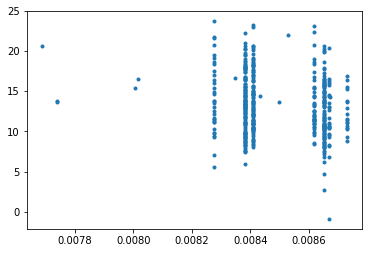

151 689 (445,)
[[ 1.         -0.19570432]
 [-0.19570432  1.        ]]


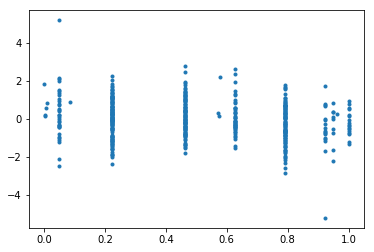

[[ 1.       -0.181911]
 [-0.181911  1.      ]]
BSX
LHX3
HAND1
BARX2


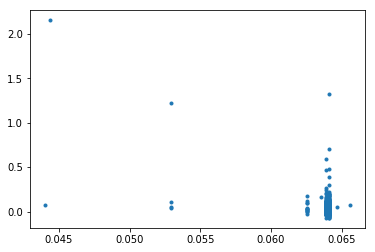

799 752 (445,)
[[ 1.         -0.48258825]
 [-0.48258825  1.        ]]


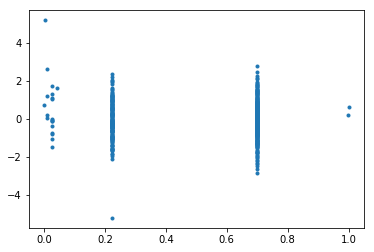

[[ 1.         -0.03436738]
 [-0.03436738  1.        ]]
TBX21


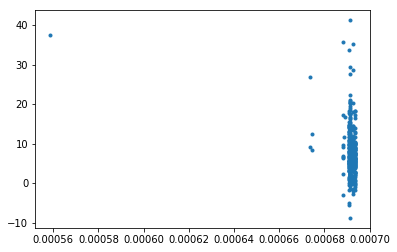

798 297 (445,)
[[ 1.         -0.27409293]
 [-0.27409293  1.        ]]


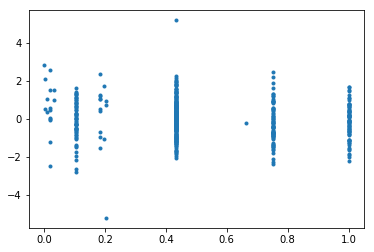

[[ 1.         -0.11037069]
 [-0.11037069  1.        ]]
ZNF691


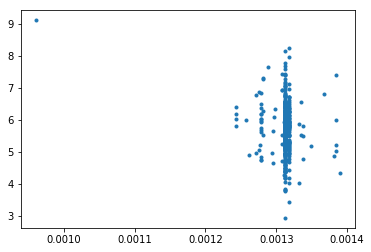

233 602 (445,)
[[ 1.        -0.2037881]
 [-0.2037881  1.       ]]


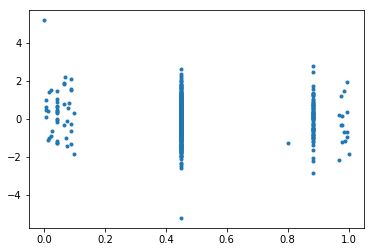

[[ 1.         -0.07152813]
 [-0.07152813  1.        ]]
RELA


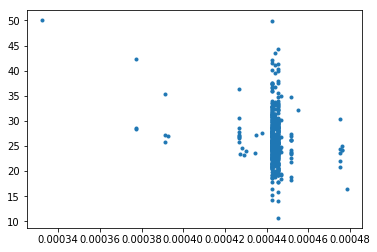

850 643 (445,)
[[ 1.         -0.23131454]
 [-0.23131454  1.        ]]


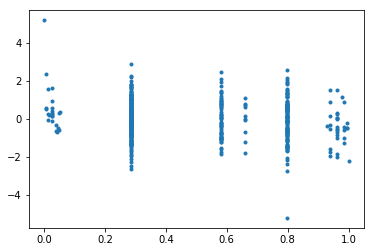

[[ 1.         -0.13314595]
 [-0.13314595  1.        ]]
ITGB2


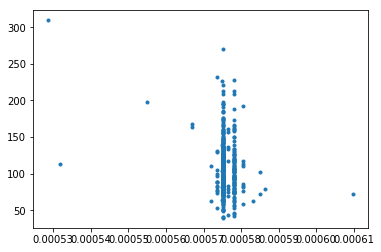

14 127 (445,)
[[ 1.         -0.22841836]
 [-0.22841836  1.        ]]


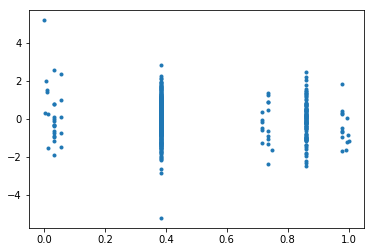

[[ 1.         -0.08708494]
 [-0.08708494  1.        ]]
HOXC8
TFAP2C
CBX5


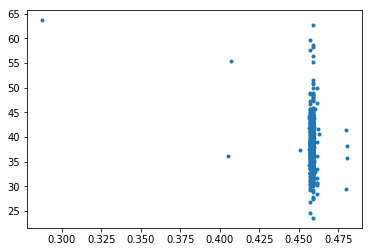

14 110 (445,)
[[ 1.         -0.23622834]
 [-0.23622834  1.        ]]


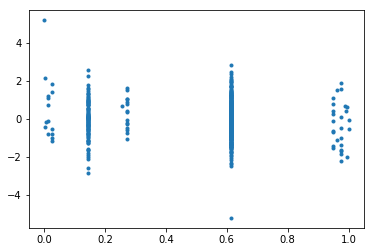

[[ 1.         -0.07657398]
 [-0.07657398  1.        ]]
NFE2
FOXJ3


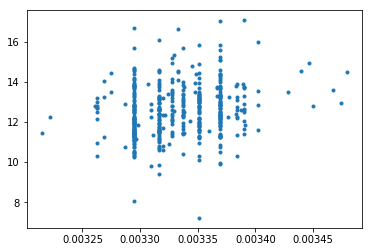

661 233 (445,)
[[1.       0.206953]
 [0.206953 1.      ]]


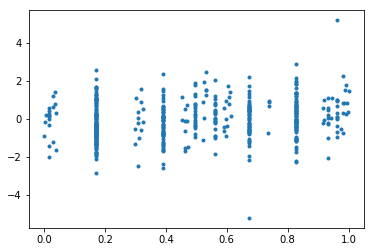

[[1.         0.19679475]
 [0.19679475 1.        ]]
PAX8


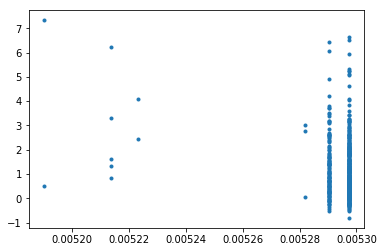

490 49 (445,)
[[ 1.         -0.21179948]
 [-0.21179948  1.        ]]


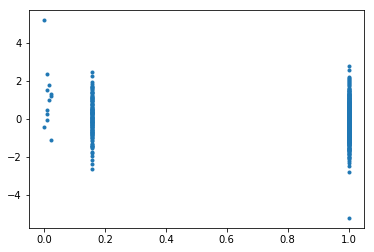

[[ 1.         -0.11084335]
 [-0.11084335  1.        ]]
EN2
HEY2


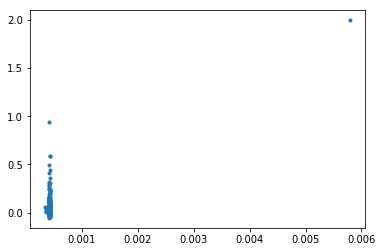

425 193 (445,)
[[1.         0.72614097]
 [0.72614097 1.        ]]


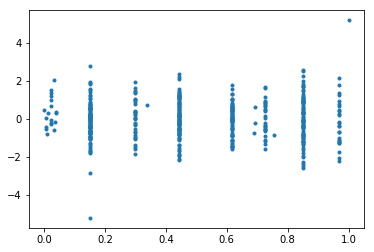

[[1.        0.0025727]
 [0.0025727 1.       ]]
ZFX


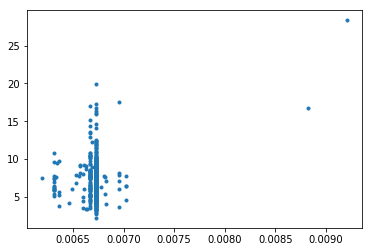

233 81 (445,)
[[1.        0.3270946]
 [0.3270946 1.       ]]


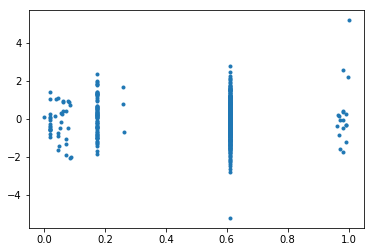

[[1.         0.00274936]
 [0.00274936 1.        ]]
IRF7
BARHL1
NFYA


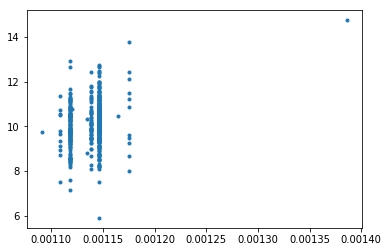

786 122 (445,)
[[1.         0.24923939]
 [0.24923939 1.        ]]


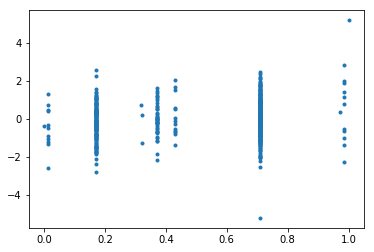

[[1.         0.15129571]
 [0.15129571 1.        ]]
FOXK1


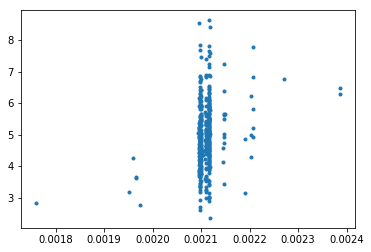

849 649 (445,)
[[1.         0.25117642]
 [0.25117642 1.        ]]


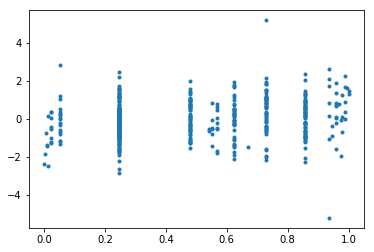

[[1.         0.19237025]
 [0.19237025 1.        ]]
HMX1
CPEB1


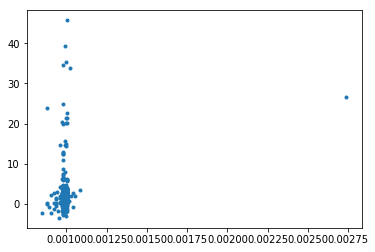

336 425 (445,)
[[1.         0.21577163]
 [0.21577163 1.        ]]


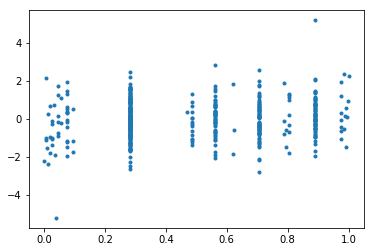

[[1.         0.12923041]
 [0.12923041 1.        ]]
NKX2-3
SCRT2
NRL


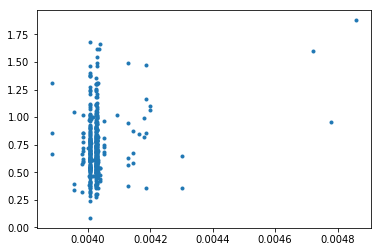

264 896 (445,)
[[1.         0.22876622]
 [0.22876622 1.        ]]


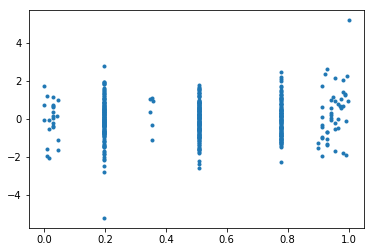

[[1.         0.07342553]
 [0.07342553 1.        ]]
FOXD2


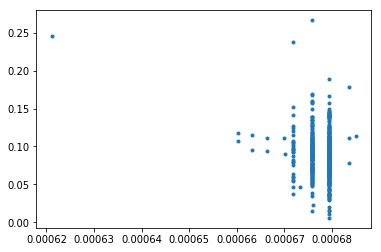

844 729 (445,)
[[ 1.        -0.2327744]
 [-0.2327744  1.       ]]


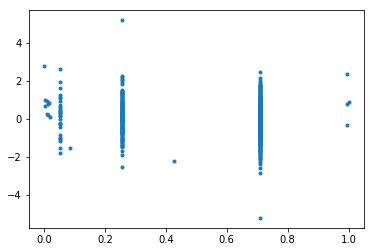

[[ 1.         -0.12476081]
 [-0.12476081  1.        ]]
SOX13


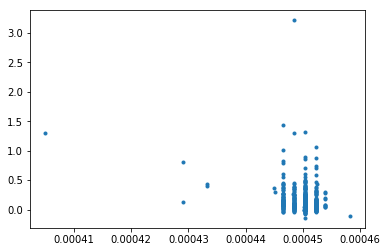

797 296 (445,)
[[ 1.         -0.24285457]
 [-0.24285457  1.        ]]


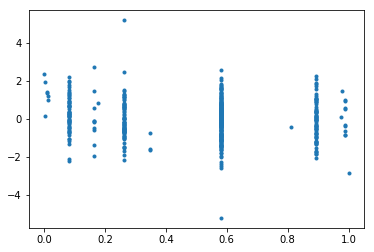

[[ 1.         -0.11725508]
 [-0.11725508  1.        ]]
HOXB3


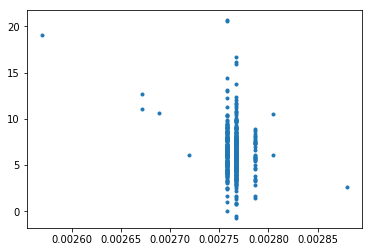

812 51 (445,)
[[ 1.         -0.26466976]
 [-0.26466976  1.        ]]


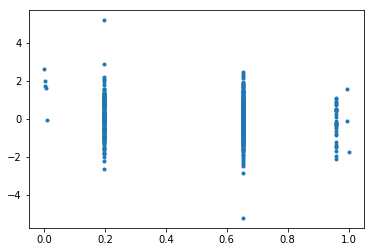

[[ 1.         -0.11845373]
 [-0.11845373  1.        ]]
HOXC6


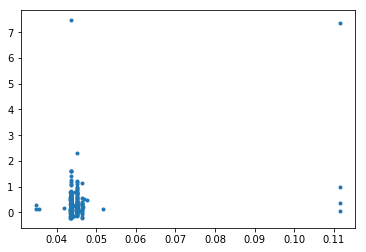

236 232 (445,)
[[1.         0.31789403]
 [0.31789403 1.        ]]


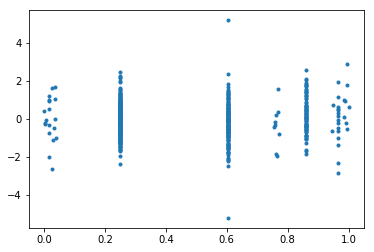

[[1.         0.03245525]
 [0.03245525 1.        ]]
VSX2


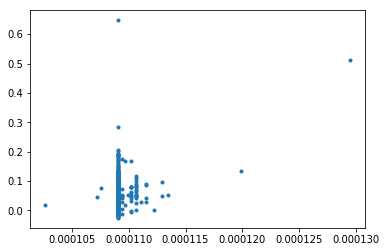

10 51 (445,)
[[1.         0.32556314]
 [0.32556314 1.        ]]


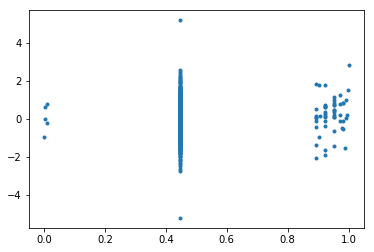

[[1.         0.08080825]
 [0.08080825 1.        ]]
GATA6


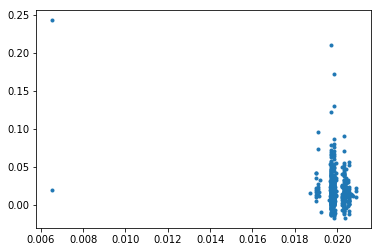

48 480 (445,)
[[ 1.         -0.31078622]
 [-0.31078622  1.        ]]


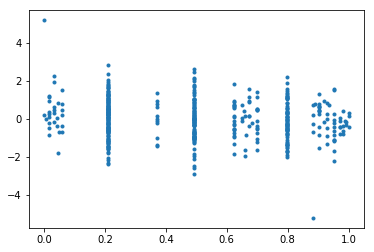

[[ 1.         -0.12903138]
 [-0.12903138  1.        ]]
ESR1


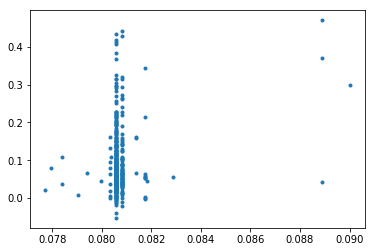

329 912 (445,)
[[1.         0.23275911]
 [0.23275911 1.        ]]


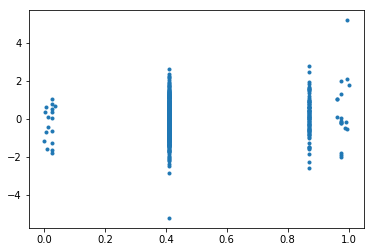

[[1.         0.11386054]
 [0.11386054 1.        ]]
ESX1
IRX2
CLOCK


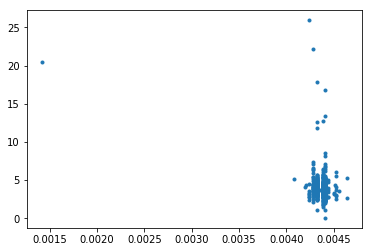

284 125 (445,)
[[ 1.         -0.36496415]
 [-0.36496415  1.        ]]


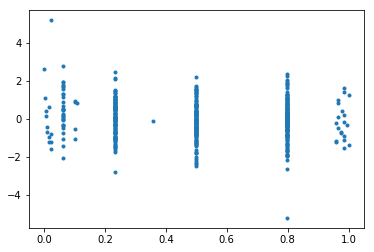

[[ 1.         -0.10550368]
 [-0.10550368  1.        ]]
POU1F1
EN1
ZNF35


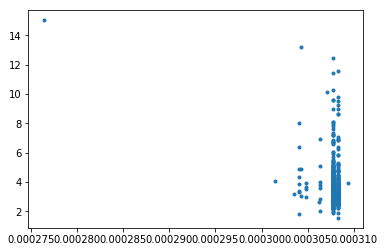

777 264 (445,)
[[ 1.         -0.30471428]
 [-0.30471428  1.        ]]


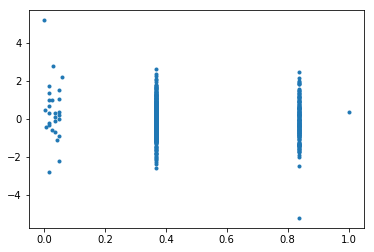

[[ 1.         -0.10201147]
 [-0.10201147  1.        ]]
HNF4A
PRDM1


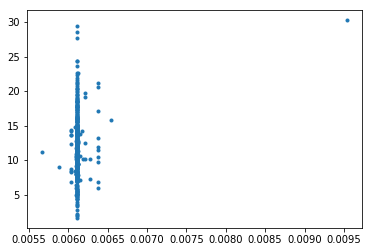

9 274 (445,)
[[1.         0.20403441]
 [0.20403441 1.        ]]


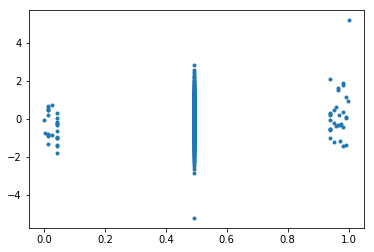

[[1.         0.12189203]
 [0.12189203 1.        ]]
MEIS1
TAL1
HOXC12
PRRX2
SPIC


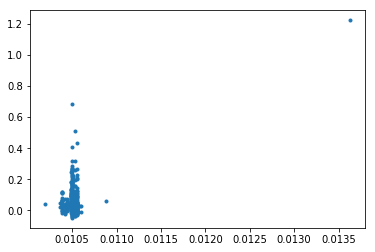

733 307 (445,)
[[1.         0.56117591]
 [0.56117591 1.        ]]


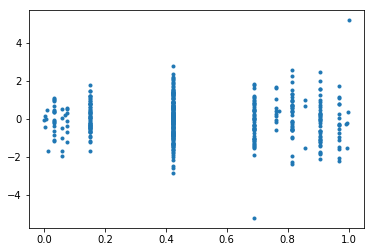

[[ 1.        -0.0178628]
 [-0.0178628  1.       ]]
MEF2B


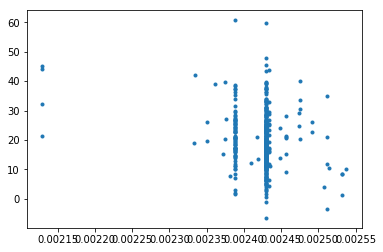

233 202 (445,)
[[ 1.         -0.22105427]
 [-0.22105427  1.        ]]


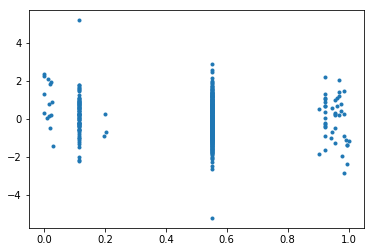

[[ 1.         -0.13353366]
 [-0.13353366  1.        ]]
DLX1


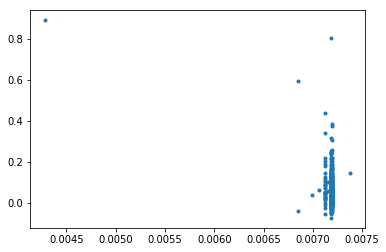

813 210 (445,)
[[ 1.        -0.4558295]
 [-0.4558295  1.       ]]


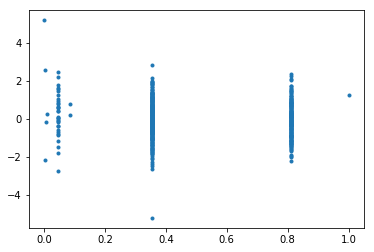

[[ 1.         -0.05261777]
 [-0.05261777  1.        ]]
DLX2


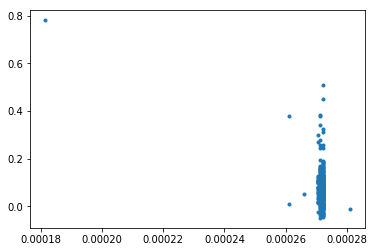

813 213 (445,)
[[ 1.         -0.46463696]
 [-0.46463696  1.        ]]


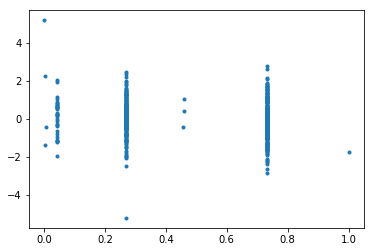

[[ 1.         -0.11461992]
 [-0.11461992  1.        ]]
TFEC


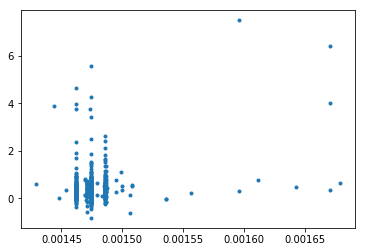

613 2 (445,)
[[1.         0.26793844]
 [0.26793844 1.        ]]


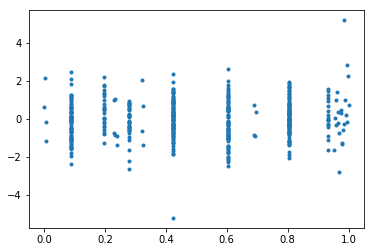

[[1.         0.06143223]
 [0.06143223 1.        ]]
HOMEZ


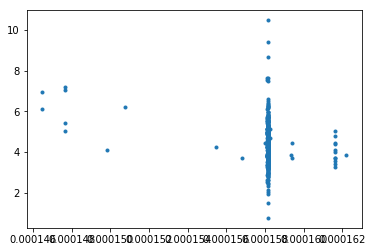

919 546 (445,)
[[ 1.         -0.22243243]
 [-0.22243243  1.        ]]


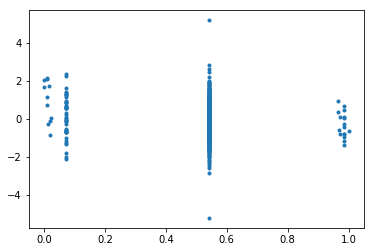

[[ 1.         -0.12705183]
 [-0.12705183  1.        ]]
SOX3
ZBTB12
NKX6-1
ARNTL


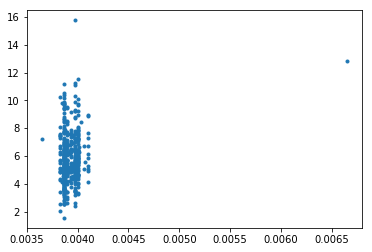

722 307 (445,)
[[1.         0.21183105]
 [0.21183105 1.        ]]


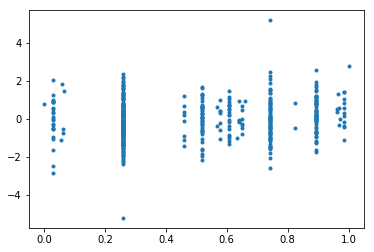

[[1.         0.14715145]
 [0.14715145 1.        ]]
FLI1


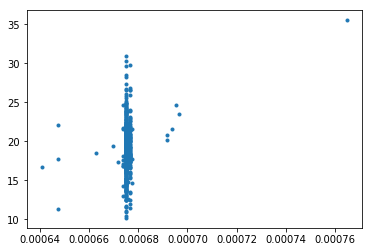

329 587 (445,)
[[1.         0.23793751]
 [0.23793751 1.        ]]


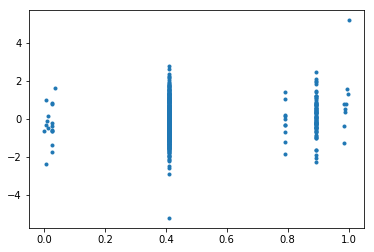

[[1.        0.1201907]
 [0.1201907 1.       ]]
SIX1


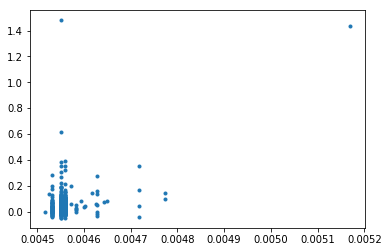

633 486 (445,)
[[1.         0.46969628]
 [0.46969628 1.        ]]


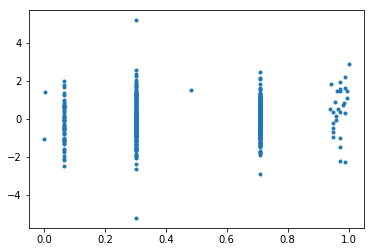

[[1.        0.1144442]
 [0.1144442 1.       ]]
FOXO6


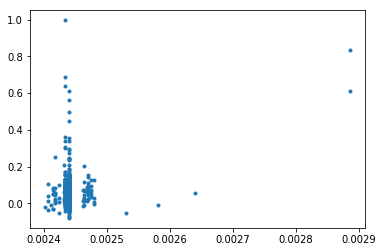

265 402 (445,)
[[1.         0.33369881]
 [0.33369881 1.        ]]


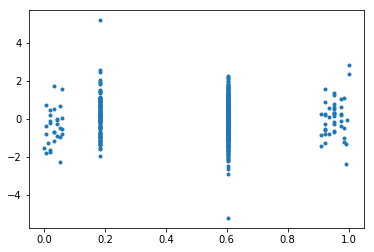

[[ 1.         -0.01395108]
 [-0.01395108  1.        ]]
SHOX2


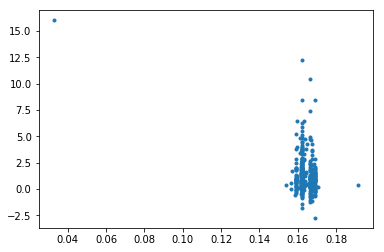

702 107 (445,)
[[ 1.         -0.39042906]
 [-0.39042906  1.        ]]


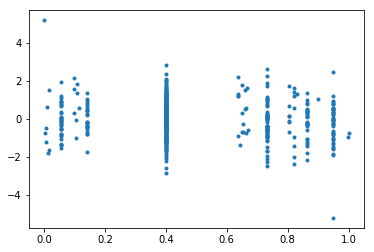

[[ 1.         -0.10181006]
 [-0.10181006  1.        ]]
HOXD3
HOXD12
AR


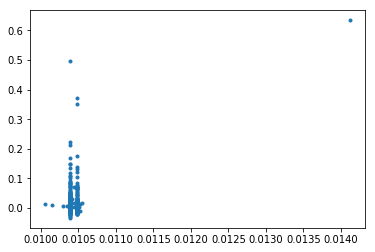

275 81 (445,)
[[1.         0.52153289]
 [0.52153289 1.        ]]


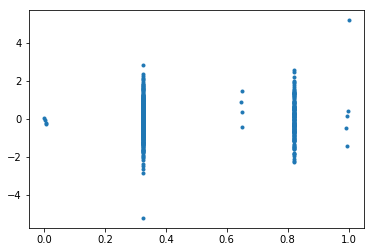

[[1.         0.05005435]
 [0.05005435 1.        ]]
INSM1
GCM1
OSR1
HOXC10
NFIC


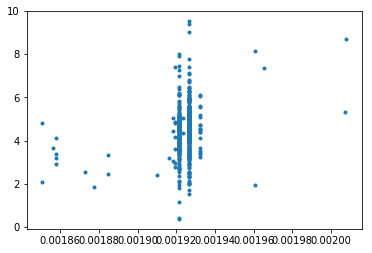

690 757 (445,)
[[1.         0.24173009]
 [0.24173009 1.        ]]


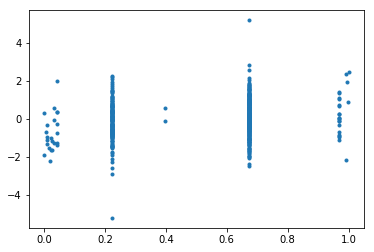

[[1.         0.18425344]
 [0.18425344 1.        ]]
E2F4


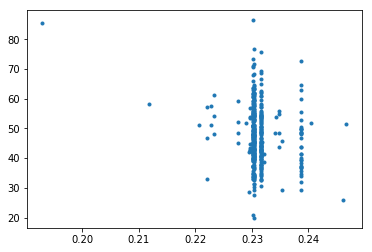

281 875 (445,)
[[ 1.         -0.19458293]
 [-0.19458293  1.        ]]


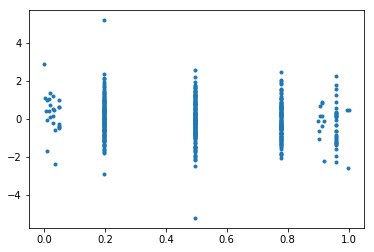

[[ 1.         -0.10977103]
 [-0.10977103  1.        ]]
DUX4
HOXC11
GRHL1


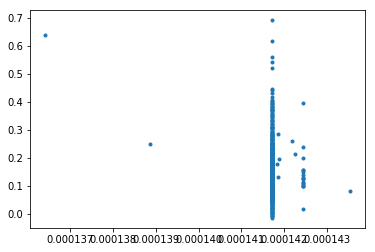

4 792 (445,)
[[ 1.         -0.19516049]
 [-0.19516049  1.        ]]


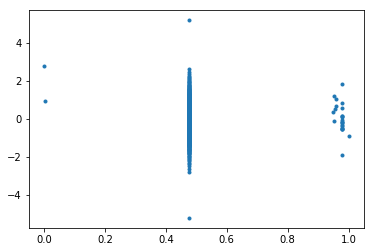

[[ 1.         -0.02148588]
 [-0.02148588  1.        ]]
DMBX1
TEF


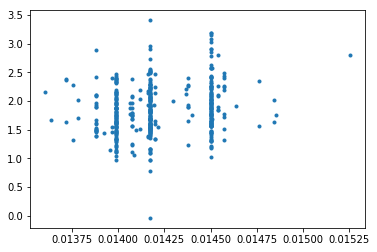

177 711 (445,)
[[1.         0.19584554]
 [0.19584554 1.        ]]


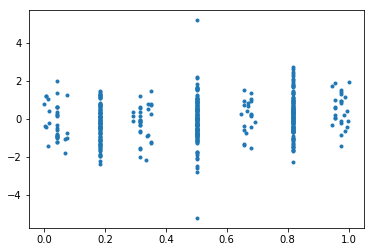

[[1.        0.1862796]
 [0.1862796 1.       ]]
IKZF1


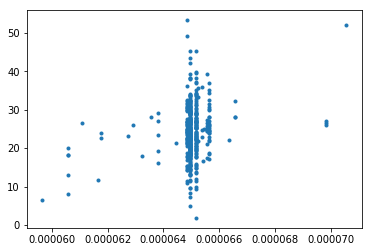

411 736 (445,)
[[1.         0.23369303]
 [0.23369303 1.        ]]


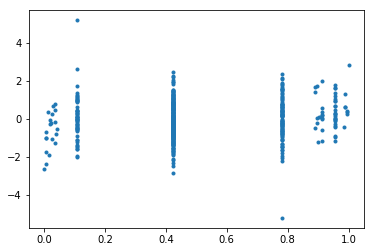

[[1.         0.12504607]
 [0.12504607 1.        ]]
ATF2


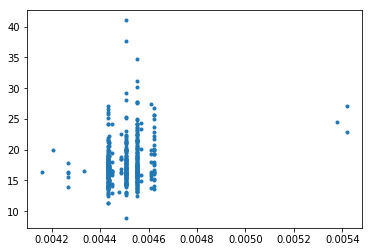

551 430 (445,)
[[1.         0.22590928]
 [0.22590928 1.        ]]


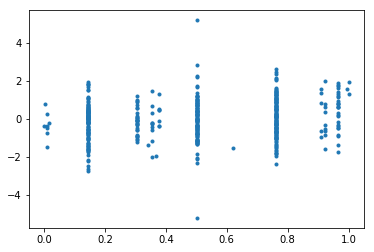

[[1.        0.1687576]
 [0.1687576 1.       ]]
ZIC3
SOX8


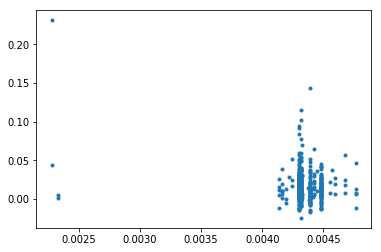

217 602 (445,)
[[ 1.         -0.23409861]
 [-0.23409861  1.        ]]


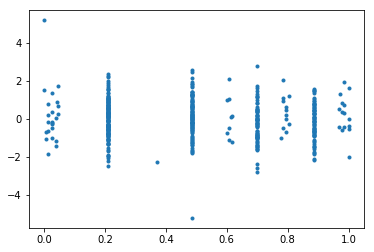

[[ 1.         -0.06602528]
 [-0.06602528  1.        ]]
MYCN
OLIG1


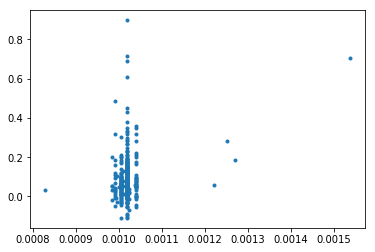

21 447 (445,)
[[1.         0.26368293]
 [0.26368293 1.        ]]


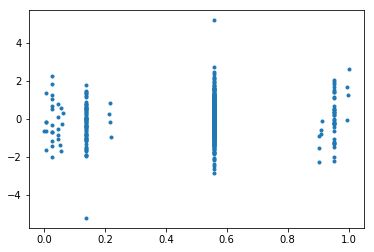

[[1.         0.10173076]
 [0.10173076 1.        ]]
OLIG2
MEIS2


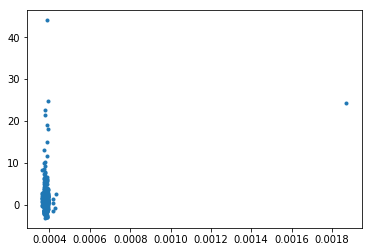

188 201 (445,)
[[1.         0.28898277]
 [0.28898277 1.        ]]


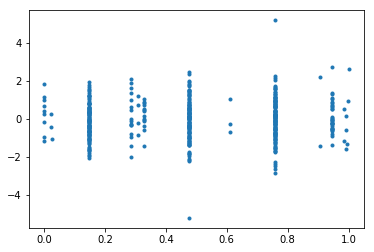

[[1.         0.04109468]
 [0.04109468 1.        ]]
CEBPB


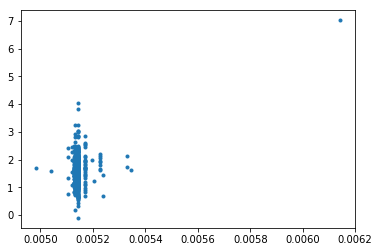

714 202 (445,)
[[1.         0.40960502]
 [0.40960502 1.        ]]


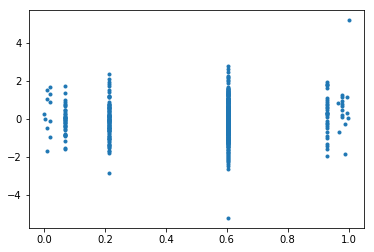

[[1.         0.06263215]
 [0.06263215 1.        ]]
ALX3


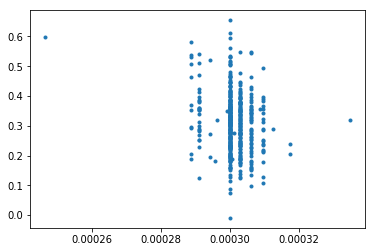

65 195 (445,)
[[ 1.         -0.21044292]
 [-0.21044292  1.        ]]


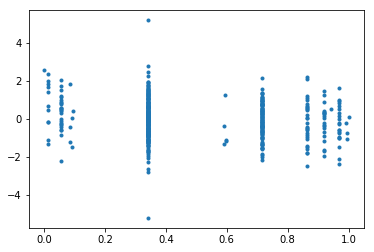

[[ 1.         -0.14747098]
 [-0.14747098  1.        ]]
ZBTB6


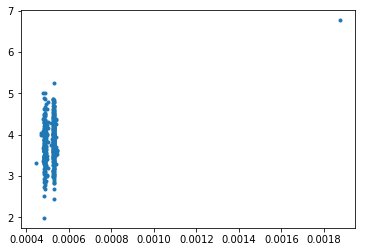

337 462 (445,)
[[1.         0.29925079]
 [0.29925079 1.        ]]


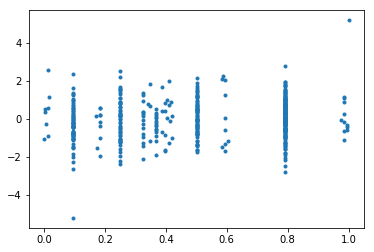

[[1.         0.13137407]
 [0.13137407 1.        ]]
PHOX2A
AIRE


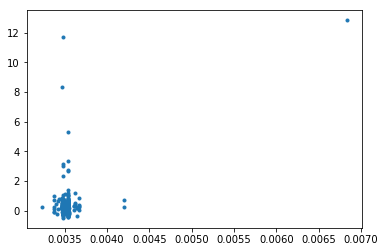

749 177 (445,)
[[1.         0.53841848]
 [0.53841848 1.        ]]


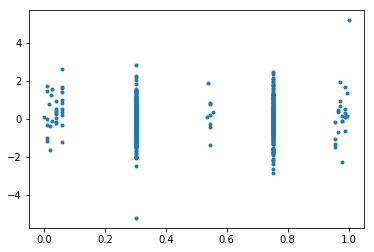

[[ 1.         -0.00344157]
 [-0.00344157  1.        ]]
TCF7L1


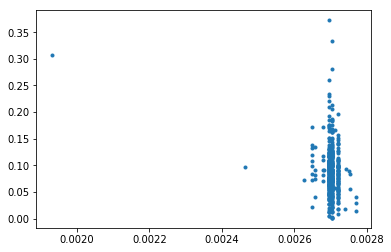

333 480 (445,)
[[ 1.         -0.23920355]
 [-0.23920355  1.        ]]


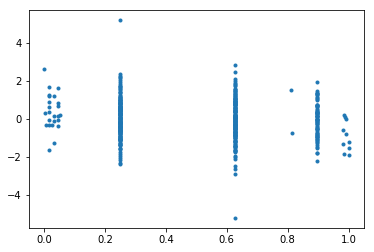

[[ 1.         -0.11972216]
 [-0.11972216  1.        ]]
MAFB
GFI1


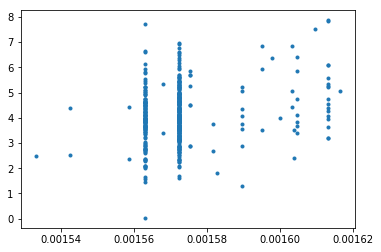

75 273 (445,)
[[1.         0.23472665]
 [0.23472665 1.        ]]


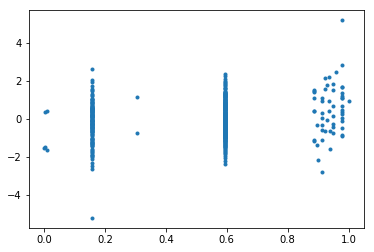

[[1.         0.18544497]
 [0.18544497 1.        ]]
MYOD1
E2F2


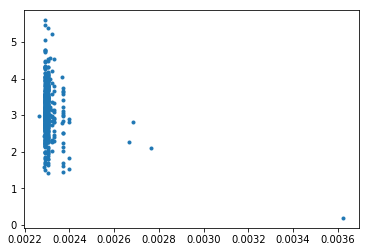

130 511 (445,)
[[ 1.         -0.23323545]
 [-0.23323545  1.        ]]


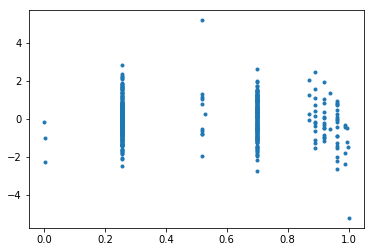

[[ 1.         -0.04580864]
 [-0.04580864  1.        ]]
KLF13


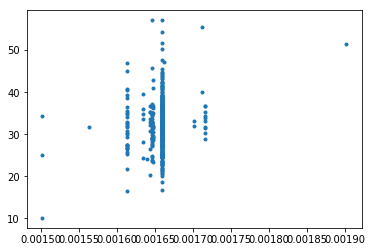

712 440 (445,)
[[1.        0.1848225]
 [0.1848225 1.       ]]


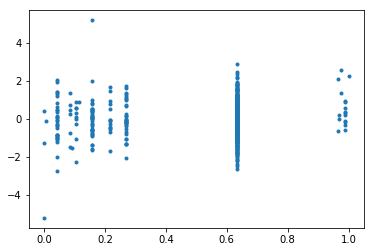

[[1.         0.07240274]
 [0.07240274 1.        ]]
MYC


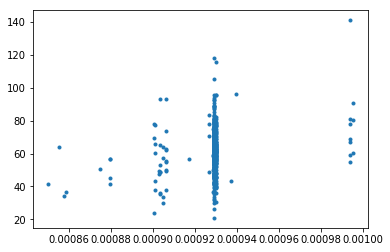

12 799 (445,)
[[1.         0.25071739]
 [0.25071739 1.        ]]


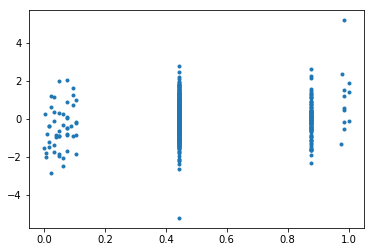

[[1.         0.13880279]
 [0.13880279 1.        ]]
IRF3


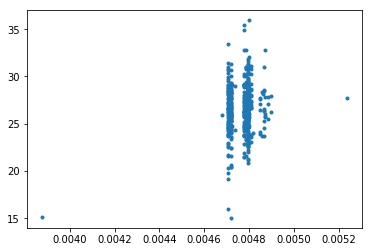

849 47 (445,)
[[1.         0.21672326]
 [0.21672326 1.        ]]


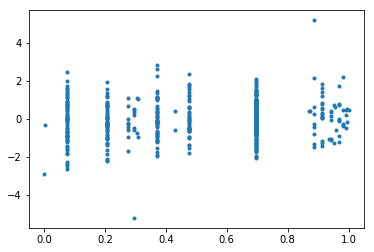

[[1.         0.11715209]
 [0.11715209 1.        ]]
CEBPG


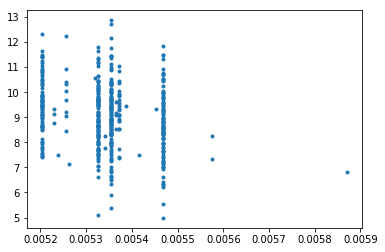

579 563 (445,)
[[ 1.         -0.22619385]
 [-0.22619385  1.        ]]


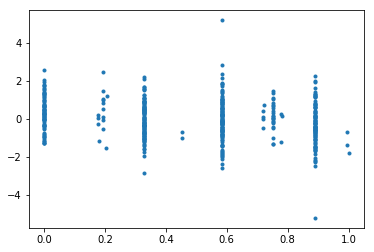

[[ 1.         -0.19459812]
 [-0.19459812  1.        ]]
IRX6


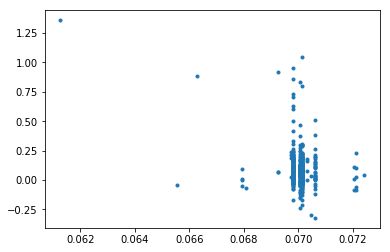

288 853 (445,)
[[ 1.         -0.32319174]
 [-0.32319174  1.        ]]


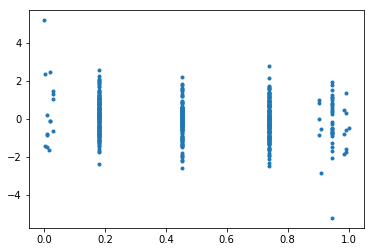

[[ 1.         -0.13228479]
 [-0.13228479  1.        ]]
BPTF


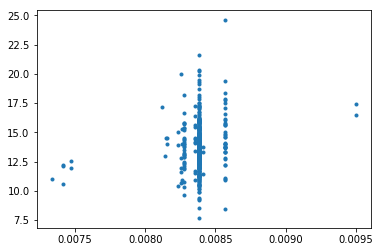

724 701 (445,)
[[1.         0.18396113]
 [0.18396113 1.        ]]


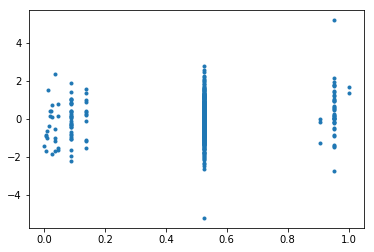

[[1.         0.13054426]
 [0.13054426 1.        ]]
DDIT3


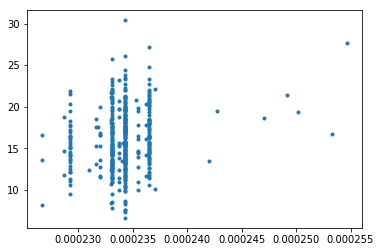

42 525 (445,)
[[1.         0.19581799]
 [0.19581799 1.        ]]


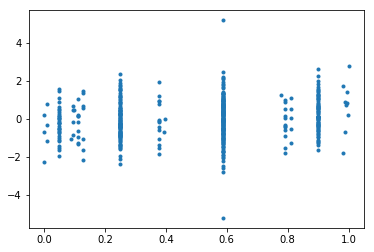

[[1.        0.1448671]
 [0.1448671 1.       ]]
ZNF143


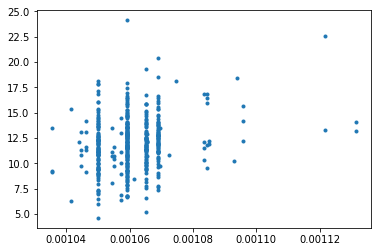

217 162 (445,)
[[1.         0.21609049]
 [0.21609049 1.        ]]


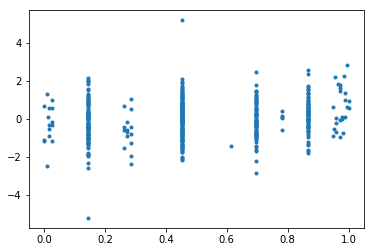

[[1.         0.17631627]
 [0.17631627 1.        ]]
ONECUT2


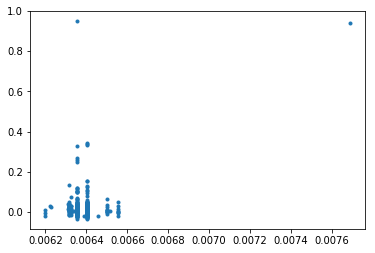

114 46 (445,)
[[1.         0.43679703]
 [0.43679703 1.        ]]


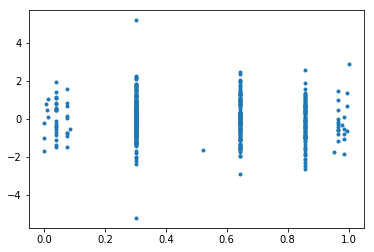

[[ 1.         -0.07631416]
 [-0.07631416  1.        ]]
SNAI2
SOX12


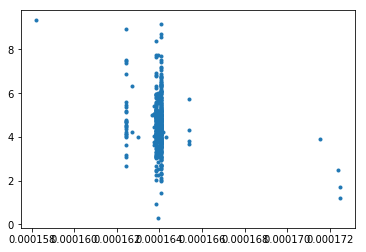

889 640 (445,)
[[ 1.         -0.23529991]
 [-0.23529991  1.        ]]


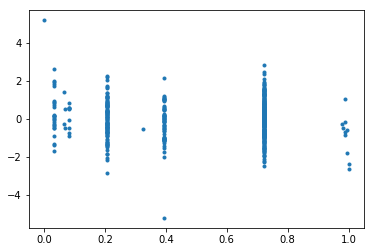

[[ 1.         -0.05508718]
 [-0.05508718  1.        ]]
ETV4


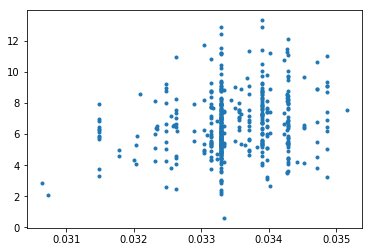

732 65 (445,)
[[1.         0.20529501]
 [0.20529501 1.        ]]


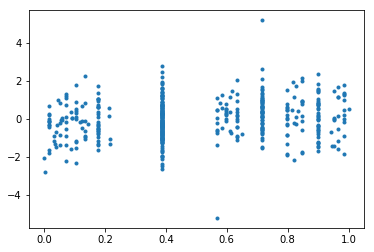

[[1.         0.17497513]
 [0.17497513 1.        ]]
EVX1
ZNF219


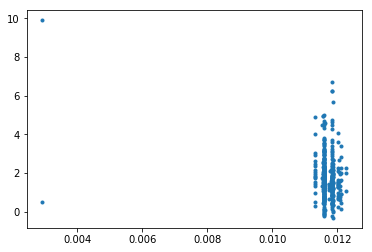

47 737 (445,)
[[ 1.         -0.21680805]
 [-0.21680805  1.        ]]


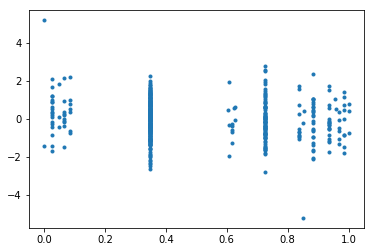

[[ 1.         -0.13380831]
 [-0.13380831  1.        ]]
NKX3-1


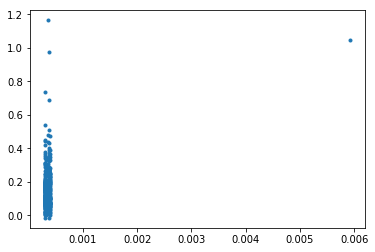

679 243 (445,)
[[1.         0.34123306]
 [0.34123306 1.        ]]


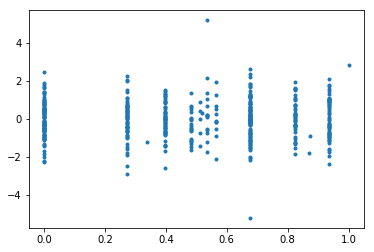

[[1.         0.01653259]
 [0.01653259 1.        ]]
SOX1
HSF4


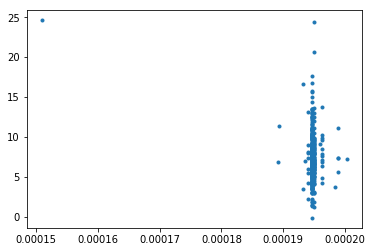

354 214 (445,)
[[ 1.         -0.26082001]
 [-0.26082001  1.        ]]


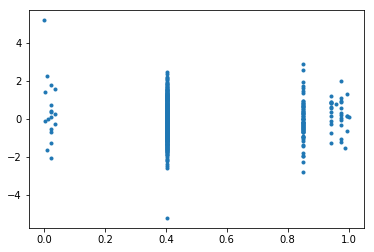

[[ 1.         -0.00261127]
 [-0.00261127  1.        ]]
BARX1
FOXC2
NR2F1
ZBTB33


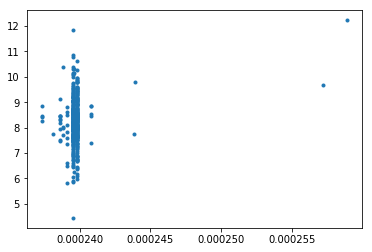

46 501 (445,)
[[1.         0.20089452]
 [0.20089452 1.        ]]


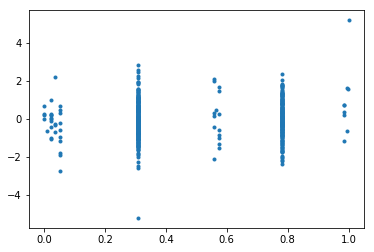

[[1.         0.07729649]
 [0.07729649 1.        ]]
ZBTB12


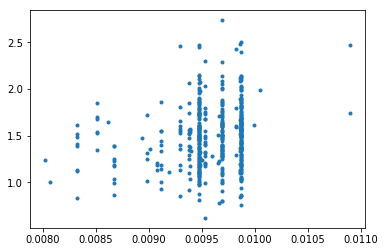

48 834 (445,)
[[1.         0.19342125]
 [0.19342125 1.        ]]


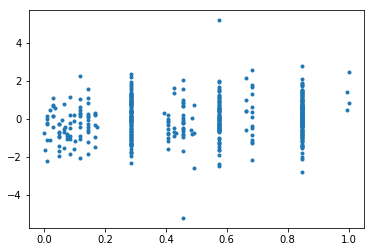

[[1.         0.15308018]
 [0.15308018 1.        ]]
SOX14
MLX


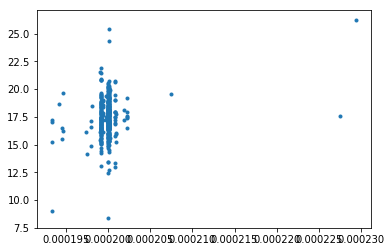

264 595 (445,)
[[1.         0.22607201]
 [0.22607201 1.        ]]


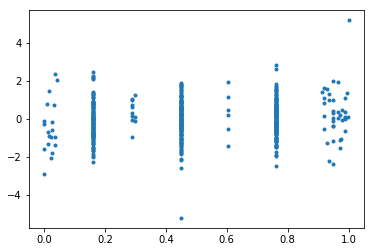

[[1.         0.11310461]
 [0.11310461 1.        ]]
ZEB1


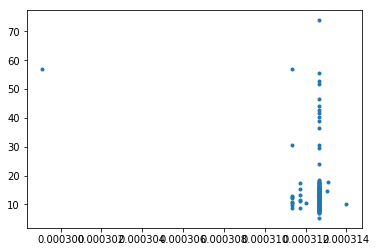

803 25 (445,)
[[ 1.         -0.30999019]
 [-0.30999019  1.        ]]


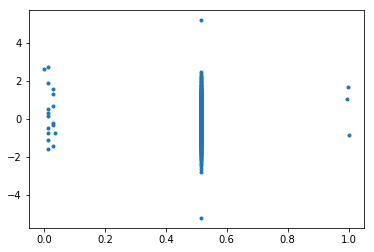

[[ 1.         -0.03754369]
 [-0.03754369  1.        ]]
IRX3
LHX6
SOX9


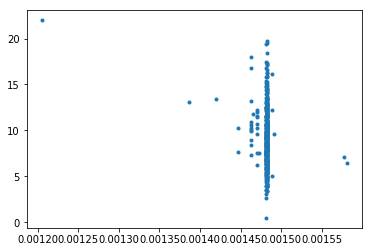

630 753 (445,)
[[ 1.         -0.22229274]
 [-0.22229274  1.        ]]


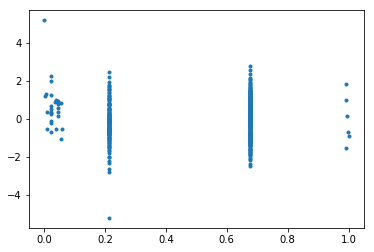

[[1.         0.00472341]
 [0.00472341 1.        ]]
SOX17
TCF7L2


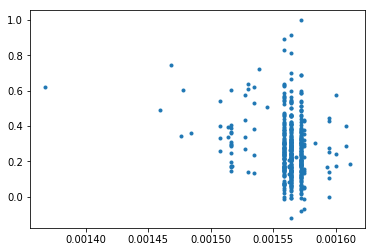

301 377 (445,)
[[ 1.         -0.21439454]
 [-0.21439454  1.        ]]


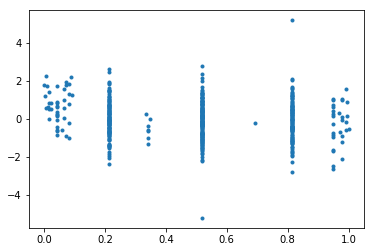

[[ 1.         -0.14143058]
 [-0.14143058  1.        ]]
DBX1
NR3C2


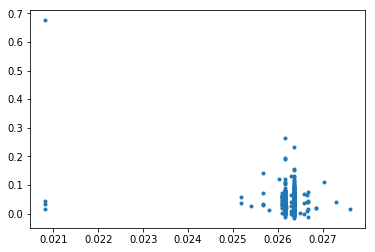

826 560 (445,)
[[ 1.         -0.31938103]
 [-0.31938103  1.        ]]


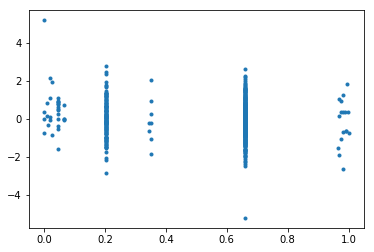

[[ 1.         -0.11078892]
 [-0.11078892  1.        ]]
NFE2L2


In [ ]:
gene_info = pd.read_csv("gene_info_"+sys.argv[8]+".txt", sep="\t",header = 0,index_col=0)
#print(dfexpr)
#print(gene_info)
for index, row in gene_info.iterrows():
    print(row["Gene name"])
    #print(row.name)
    try:
        np.where(dfexpr['TargetID'].str.contains(row.name))[0][0]
    except:
        continue
    #print(np.where(dfexpr['TargetID'].str.contains(row.name))[0][0])
    df= pd.read_csv("correlations/correlations_"+sys.argv[1]+"_"+sys.argv[3]+"/"+row["Gene name"]+".csv.gz", header=0, index_col=0)
    import matplotlib.pyplot as plt
    df=df.fillna(0)
    #print(list(df.abs().max().sort_values().iloc[-50:].index))
    #print(df.abs().idxmax())
    #df.abs().max().plot()
    #plt.show()
    #plt.scatter(df.abs().max().index, df.abs().max(),s=1)
    #plt.show()
    #get list of best positions
    pos=df.abs().max().sort_values().iloc[-50:]
    #get list of best mark at these positions
    mark=df.abs().idxmax()[list(pos.index)]
    import matplotlib.pyplot as plt
    position_i=(df.columns.get_loc(list(pos.index)[-1]))
    mark_i=(df.index.get_loc(list(mark)[-1]))
    plt.plot(answ[position_i,:,mark_i] , expr[np.where(dfexpr['TargetID'].str.contains(row.name))[0][0]],'.')
    plt.show()
    print(position_i,mark_i , expr[np.where(dfexpr['TargetID'].str.contains(row.name))[0][0]].shape)
    print(np.corrcoef(answ[position_i,:,mark_i] , expr[np.where(dfexpr['TargetID'].str.contains(row.name))[0][0]]))
    #answ=np.empty([sys.argv[2],445,919])
    #expr=np.empty([445])
    from sklearn.preprocessing import quantile_transform
    X=np.copy(answ[position_i,:,mark_i])
    Y=np.copy(expr[np.where(dfexpr['TargetID'].str.contains(row.name))[0][0]])
    X=X.reshape(-1, 1)
    Y=Y.reshape(-1, 1)
    X=quantile_transform(X, output_distribution="normal", copy=True)
    Y=quantile_transform(Y, output_distribution="normal", copy=True)
    plt.plot(X, Y,'.')
    plt.show()
    print(np.corrcoef(X.reshape(-1), Y.reshape(-1)))

In [128]:
df.abs().idxmax()[list(pos.index)]

-93400.0                        GM12878|EZH2|None
-45500.0                         HUVEC|c-Fos|None
23300.0                           HUVEC|CTCF|None
-103700.0                  A549|TAF1|EtOH_0.02pct
245600.0                           K562|EZH2|None
224000.0                      H1-hESC|H4K5ac|None
-47700.0                          HA-sp|CTCF|None
100100.0                      HeLa-S3|TCF7L2|None
-44200.0                       HeLa-S3|CEBPB|None
198200.0                       PANC-1|TCF7L2|None
-5800.0                          CD20+|DNase|None
-101300.0                      H7-hESC|DNase|None
30400.0                         NT2-D1|DNase|None
164500.0     Monocytes-CD14+RO01746|H3K36me3|None
-7900.0                      H1-hESC|H2BK5ac|None
158600.0                           iPS|DNase|None
223900.0                        H1-hESC|RXRA|None
-93300.0                      GM12878|STAT5A|None
-20800.0                        K562|H3K9me1|None
-18000.0                    NHDF-Ad|H3K27me3|None


In [ ]:
__logBase10of2 = 3.010299956639811952137388947244930267681898814621085413104274611e-1
def RoundToSigFigs_fp( x, sigfigs ):
    """
    Rounds the value(s) in x to the number of significant figures in sigfigs.
    Return value has the same type as x.

    Restrictions:
    sigfigs must be an integer type and store a positive value.
    x must be a real value.
    """
    if not ( type(sigfigs) is int or type(sigfigs) is long or
             isinstance(sigfigs, np.integer) ):
        raise TypeError( "RoundToSigFigs_fp: sigfigs must be an integer." )

    if sigfigs <= 0:
        raise ValueError( "RoundToSigFigs_fp: sigfigs must be positive." )

    if not np.isreal( x ).all():
        raise TypeError( "RoundToSigFigs_fp: x must be real." )

    xsgn = np.sign(x)
    mantissa, binaryExponent = np.frexp( xsgn * x )

    decimalExponent = __logBase10of2 * binaryExponent
    omag = np.floor(decimalExponent)

    mantissa *= 10.0**(decimalExponent - omag)

    if mantissa < 1.0:
        mantissa *= 10.0
        omag -= 1.0

    return xsgn * np.around( mantissa, decimals=sigfigs - 1 ) * 10.0**omag

In [ ]:
#print(RoundToSigFigs_fp(answ,3))

In [ ]:
np.savez_compressed('test_save_compressed',RoundToSigFigs_fp(answ,3))

In [ ]:
#try to compare time with
np.round(answ,3)